In [1]:
import json
import os
import re
import math

import pandas as pd
import numpy as np

from scipy.spatial import cKDTree
from scipy.stats import sem, ttest_ind 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import Patch, Circle, RegularPolygon
from matplotlib.colors import Normalize

from collections import Counter


plt.rcParams['font.family'] = 'serif'  #  'SimHei'、'Microsoft YaHei' 

# change animal here
mouse_id = "rodeo05"

Run "Data" and "Read Center and LM Coords" to prepare for all the following analysis

## Data

!! For now, ignore the reward if both reward timestamps and reward state are missing

In [2]:
#folder_path = f"/Volumes/voigtslab/mfb_task_2025/{mouse_id}/"
folder_path = f"//prfs.hhmi.org/voigtslab/mfb_task_2025/{mouse_id}/"

# Get list of all folders in the specified path
folders = [f"{folder_path}{f}" for f in os.listdir(folder_path)
           if os.path.isdir(os.path.join(folder_path, f)) and "LM1" in f]
print(folders)

all_files = {}

for folder in folders:
    all_files[folder] = {}
    beh_files = [f for f in os.listdir(folder) if f.startswith("behavData_")]
    all_files[folder]["beh_files"] = beh_files
    #beh_files = [f for folder in folders for f in os.listdir(folder) if f.startswith("beh")]
    #print(beh_files)
    reward_files = [f"/data/{f}" for f in os.listdir(folder + "/data") if f.startswith("reward")]
    all_files[folder]["reward_files"] = reward_files
    #reward_folders = [f + "/data/" for f in folders]
    #print(reward_folders)
    #reward_files = [f for folder in reward_folders for f in os.listdir(folder) if f.startswith("reward")]
    #print(reward_files)
    config_file = [f for f in os.listdir(folder) if f.startswith("config")]
    all_files[folder]["config_file"] = config_file

all_files

['//prfs.hhmi.org/voigtslab/mfb_task_2025/rodeo05/2025_07_25_rodeo05_LM1']


{'//prfs.hhmi.org/voigtslab/mfb_task_2025/rodeo05/2025_07_25_rodeo05_LM1': {'beh_files': ['behavData_2025_7_25_16_12_20__defaultmouse.txt'],
  'reward_files': ['/data/reward_times_0.csv'],
  'config_file': ['config.txt']}}

In [3]:
def open_behavior_file(file_path):
    # Check if file is empty
    if os.path.getsize(file_path) == 0:
        return None

    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print("Corrupt JSON detected – attempting to repair...")

        with open(file_path, 'r') as f:
            content = f.read()

        # Try to find the last complete JSON object in the array
        last_obj_end = content.rfind('}')
        if last_obj_end == -1:
            raise ValueError("No complete object found in corrupted JSON.")

        # Trim to last closing brace, then close the array properly
        repaired = content[:last_obj_end + 1]

        # Also trim to the last comma before a complete object if necessary
        last_open = repaired.rfind('{')
        if last_open == -1:
            raise ValueError("No valid JSON object starts found.")

        # Wrap with brackets and fix commas
        repaired = repaired[:last_obj_end + 1]
        repaired = repaired.strip()

        # Ensure it ends in a list format
        if repaired[-1] != '}':
            raise ValueError("Cannot repair JSON — last object incomplete.")

        # Make sure list is comma-separated
        repaired = repaired + ']'
        if repaired[0] != '[':
            repaired = '[' + repaired

        # Try loading repaired JSON
        try:
            data = json.loads(repaired)
        except json.JSONDecodeError as e:
            raise ValueError("Final JSON repair attempt failed.") from e

    df = pd.DataFrame([entry for entry in data if isinstance(entry, dict) and 'r' in entry])
    # Convert t_ms to datetime and set as index
    df['t_ms'] = pd.to_datetime(df['t_ms'], unit='ms', utc=True).dt.tz_convert('US/Eastern')
    df = df.set_index('t_ms')
    # Ensure index is unique by keeping last occurrence
    df = df[~df.index.duplicated(keep='last')]

    maze_coords = None
    maze_offset = None
    lm_ht_entries = []
    center_ht_entries = []
    for entry in data:
        bsm = entry.get('bsmOpts', {})
        if 'mazeCoords' in entry:
            maze_coords = entry['mazeCoords']
        if 'maze_offset' in bsm:
            maze_offset = entry['bsmOpts']['maze_offset']
        if 'LM_holding_time' in bsm:
            lm_ht_entries.append({
                'frame': entry['frame'],
                'lm_ht': bsm['LM_holding_time']
            })
        if "center_holding_time" in bsm:
            center_ht_entries.append({
                'frame': entry['frame'],
                'center_ht': bsm['center_holding_time']
            })

    if lm_ht_entries:
        lm_ht_df = (
            pd.DataFrame(lm_ht_entries)
              .sort_values('frame')
              .reset_index(drop=True)
        )

        lm_ht_df['start'] = lm_ht_df['frame'] 
        lm_ht_df['end'] = lm_ht_df['frame'].shift(-1)

        df['lm_ht'] = np.nan

        for _, row in lm_ht_df.iterrows():
            s = row['start']
            e = row['end']
            if pd.notna(e):
                mask = (df['frame'] >= s) & (df['frame'] < e)
            else:
                # last offset covers every subsequent frame
                mask = (df['frame'] >= s)
            df.loc[mask, ['lm_ht']] = row['lm_ht']

    if center_ht_entries:
        center_ht_df = (
            pd.DataFrame(center_ht_entries)
              .sort_values('frame')
              .reset_index(drop=True)
        )

        center_ht_df['start'] = center_ht_df['frame'] 
        center_ht_df['end'] = center_ht_df['frame'].shift(-1)

        df['center_ht'] = np.nan

        for _, row in center_ht_df.iterrows():
            s = row['start']
            e = row['end']
            if pd.notna(e):
                mask = (df['frame'] >= s) & (df['frame'] < e)
            else:
                # last offset covers every subsequent frame
                mask = (df['frame'] >= s)
            df.loc[mask, ['center_ht']] = row['center_ht']

    # geometry to store in attrs
    df.attrs['maze_coords'] = maze_coords
    df.attrs['maze_offset'] = maze_offset

    return df

def process_behavior_data(df):
    # Create columns for state transitions
    df['prev_state'] = df['s'].shift(1)  # Get previous state

    # Mark session end transitions (lights_out -> foraging)
    df['sess_end'] = ((df['prev_state'] == 'lightsOut') & (df['s'] == 'foraging')).astype(int)

    return df

def clean_behavior_data(df):
    df = df[df['x'].abs() <= 0.8]
    df = df[df['y'].abs() <= 0.75]
    df['x_smoothed'] = df['x'].rolling(window=500, center=True).mean()
    df['y_smoothed'] = df['y'].rolling(window=500, center=True).mean()

    df['x_diff'] = abs(df['x'] - df['x_smoothed'])
    df['y_diff'] = abs(df['y'] - df['y_smoothed'])

    df['x'] = df['x'][df['x_diff'] < 0.1]
    df['y'] = df['y'][df['y_diff'] < 0.1]

    df['x'] = df['x'].interpolate()
    df['y'] = df['y'].interpolate()

    df['x'] = df['x'].rolling(window=5, center=True).mean()
    df['y'] = df['y'].rolling(window=5, center=True).mean()

    return df


def open_reward_file(file_path):
    try:
        df = pd.read_csv(file_path, parse_dates=['Timestamp'])
    except:
        return None
    df = df.set_index('Timestamp')
    # Ensure index is unique by keeping last occurrence
    df = df[~df.index.duplicated(keep='last')]
    df['reward'] = 1
    return df

def open_all_data(beh_paths, reward_paths, day, day_count):
    beh_dfs = []
    for beh_path in beh_paths:
        full_path = f"{day}/{beh_path}"
        df_beh = open_behavior_file(full_path)
        if df_beh is None:
            continue
        df_beh = process_behavior_data(df_beh)
        #df_beh = clean_behavior_data(df_beh)
        beh_dfs.append(df_beh)

    # only concatenate if we actually loaded any behavior files
    if beh_dfs:
        df_beh = pd.concat(beh_dfs)
    else:
        print(f"[Warning] no behavior data for day {day}")
        df_beh = pd.DataFrame()

    reward_dfs = []
    for reward_path in reward_paths:
        full_path = f"{day}/{reward_path}"
        df_reward = open_reward_file(full_path)
        if df_reward is None:
            continue
        reward_dfs.append(df_reward)

    if reward_dfs:
        df_reward = pd.concat(reward_dfs)
    else:
        print(f"[Warning] no reward data for day {day}")
        df_reward = pd.DataFrame()

    # If both are empty, skip this day
    if df_beh.empty and df_reward.empty:
        return pd.DataFrame()
        
    # Print some diagnostic information
    print(f"Behavior data shape: {df_beh.shape}")
    print(f"Reward data shape: {df_reward.shape}")
    print(f"Behavior index unique: {df_beh.index.is_unique}")
    print(f"Reward index unique: {df_reward.index.is_unique}")
    

    df = pd.merge(df_beh, df_reward,
                  left_index=True, right_index=True,
                  how='outer')

    # ensure reward column exists
    if 'reward' in df.columns and df_reward.shape[0] > 3:
        df['reward'] = df['reward'].fillna(0)
    else:
        df['reward'] = (df['s'] == 'reward').astype(int)

    # cumsum & filter
    df['reward_sum'] = df['reward'].cumsum()

    #change_day = 3 if mouse_id == "red" else 4

    if (df['reward_sum'] == 0).all():
        df = df.copy()
        print("!!! no reward timestamp written and no reward state written today ")
    #elif day_count > change_day:
    #    df = df[df['reward_sum'] > 1].copy()
    #    print("drop the 1st trial")
    else:
        df = df[df['reward_sum'] >= 0].copy()
        print("drop no trial")
        
    df.drop('reward_sum', axis=1, inplace=True)

    # if no rows left, bail out now
    if df.empty:
        return df

    # only now is it safe to stamp first/last sess_end
    sess_idx = df.columns.get_loc('sess_end')
    df.iloc[0,  sess_idx] = 1.0
    df.iloc[-1, sess_idx] = 1.0
    return df

In [4]:
def combine_all_data(all_files):
    all_df = []
    for day_count, (day, files) in enumerate(all_files.items()):
        print(f"→ processing day {day} (#{day_count})")
        df = open_all_data(files['beh_files'], files['reward_files'], day, day_count)
        if df.empty:
            continue
        df['day'] = day_count
        all_df.append(df)

    if not all_df:
        raise ValueError("No data loaded for any day – check your file lists!")

    # The issue: pd.concat with ignore_index=True will reset the index to RangeIndex
    # Solution: use ignore_index=False to preserve the original DatetimeIndex
    combined = pd.concat(all_df, ignore_index=False)

    # If you want to ensure the index is a DatetimeIndex (not MultiIndex), reset and set again
    if not isinstance(combined.index, pd.DatetimeIndex):
        # Try to convert to DatetimeIndex if possible
        try:
            # Use utc=True to handle tz-aware datetimes
            combined.index = pd.to_datetime(combined.index, utc=True)
        except Exception as e:
            print("Warning: Could not convert index to DatetimeIndex:", e)

    return combined

df = combine_all_data(all_files)
df


→ processing day //prfs.hhmi.org/voigtslab/mfb_task_2025/rodeo05/2025_07_25_rodeo05_LM1 (#0)
Behavior data shape: (217223, 16)
Reward data shape: (23, 1)
Behavior index unique: True
Reward index unique: True
drop no trial


frame         x         y    h  \
2025-07-25 20:12:20.822000+00:00     880.0 -0.682781 -0.239794  0.0   
2025-07-25 20:12:20.835000+00:00     881.0 -0.655129 -0.264881  0.0   
2025-07-25 20:12:20.846000+00:00     882.0 -0.655129 -0.264881  0.0   
2025-07-25 20:12:20.856000+00:00     883.0 -0.658988 -0.264104  0.0   
2025-07-25 20:12:20.865000+00:00     884.0 -0.658988 -0.264104  0.0   
...                                    ...       ...       ...  ...   
2025-07-25 21:19:29.729000+00:00  224399.0  0.106432  0.270630  0.0   
2025-07-25 21:19:29.753000+00:00  224400.0  0.106432  0.270630  0.0   
2025-07-25 21:19:29.767000+00:00  224401.0  0.106432  0.270630  0.0   
2025-07-25 21:19:29.789000+00:00  224402.0  0.106432  0.270630  0.0   
2025-07-25 21:19:29.815000+00:00  224403.0  0.106432  0.270630  0.0   

                                          s      t_st  port  pport  lport  \
2025-07-25 20:12:20.822000+00:00   foraging      14.0   0.0    2.0    0.0   
2025-07-25 20:12:20.835000+00:00   foraging      25.0   0.0    2.0    0.0   
2025-07-25 20:12:20.846000+00:00   foraging      36.0   0.0    2.0    0.0   
2025-07-25 20:12:20.856000+00:00   foraging      46.0   0.0    2.0    0.0   
2025-07-25 20:12:20.865000+00:00   foraging      56.0   0.0    2.0    0.0   
...                                     ...       ...   ...    ...    ...   
2025-07-25 21:19:29.729000+00:00  lightsOut  419591.0   0.0    2.0    0.0   
2025-07-25 21:19:29.753000+00:00  lightsOut  419614.0   0.0    2.0    0.0   
2025-07-25 21:19:29.767000+00:00  lightsOut  419628.0   0.0    2.0    0.0   
2025-07-25 21:19:29.789000+00:00  lightsOut  419650.0   0.0    2.0    0.0   
2025-07-25 21:19:29.815000+00:00  lightsOut  419676.0   0.0    2.0    0.0   

                                    r    L  mscf   lm_ht  center_ht  \
2025-07-25 20:12:20.822000+00:00  3.0  0.0   0.0   100.0      100.0   
2025-07-25 20:12:20.835000+00:00  3.0  0.0   0.0   100.0      100.0   
2025-07-25 20:12:20.846000+00:00  3.0  0.0   0.0   100.0      100.0   
2025-07-25 20:12:20.856000+00:00  3.0  0.0   0.0   100.0      100.0   
2025-07-25 20:12:20.865000+00:00  3.0  0.0   0.0   100.0      100.0   
...                               ...  ...   ...     ...        ...   
2025-07-25 21:19:29.729000+00:00  1.0  0.0   0.0  1000.0      800.0   
2025-07-25 21:19:29.753000+00:00  1.0  0.0   0.0  1000.0      800.0   
2025-07-25 21:19:29.767000+00:00  1.0  0.0   0.0  1000.0      800.0   
2025-07-25 21:19:29.789000+00:00  1.0  0.0   0.0  1000.0      800.0   
2025-07-25 21:19:29.815000+00:00  1.0  0.0   0.0  1000.0      800.0   

                                 prev_state  sess_end  reward  day  
2025-07-25 20:12:20.822000+00:00       None       1.0     0.0    0  
2025-07-25 20:12:20.835000+00:00   foraging       0.0     0.0    0  
2025-07-25 20:12:20.846000+00:00   foraging       0.0     0.0    0  
2025-07-25 20:12:20.856000+00:00   foraging       0.0     0.0    0  
2025-07-25 20:12:20.865000+00:00   foraging       0.0     0.0    0  
...                                     ...       ...     ...  ...  
2025-07-25 21:19:29.729000+00:00  lightsOut       0.0     0.0    0  
2025-07-25 21:19:29.753000+00:00  lightsOut       0.0     0.0    0  
2025-07-25 21:19:29.767000+00:00  lightsOut       0.0     0.0    0  
2025-07-25 21:19:29.789000+00:00  lightsOut       0.0     0.0    0  
2025-07-25 21:19:29.815000+00:00  lightsOut       1.0     0.0    0  

[217246 rows x 18 columns]

In [5]:
df['s'][df['reward'] == 1].to_numpy()

array([nan, nan, nan, ..., nan, nan, nan], shape=(1171,), dtype=object)

## Read Center and Landmark Coordinates

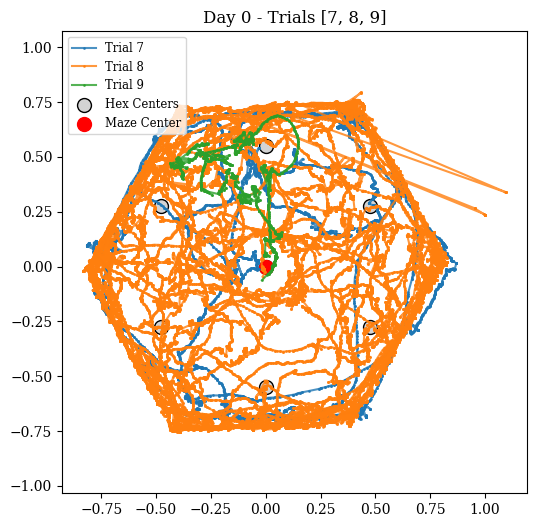

In [5]:
days = sorted(df["day"].unique())

hex_centers_by_day = {}
tree_by_day = {}

#LM_holding_time_list = []
#center_holding_time_list = []

for day in days:
    folder = list(all_files.keys())[day]
    sample_file = all_files[folder]["beh_files"][0]
    sample_df = open_behavior_file(os.path.join(folder, sample_file))

    '''
    config_file = all_files[folder]["config_file"][0]
    LM_ht = np.nan
    center_ht = np.nan
    try:
        with open(os.path.join(folder, config_file), "r") as f:
            config = json.load(f)
            LM_ht = float(config.get("LM_holding_time", np.nan))
            center_ht = float(config.get("center_holding_time", np.nan))
    except Exception:
        pass
    if day == 7:
        LM_ht, center_ht = 400.0, 400.0
    LM_holding_time_list.append(LM_ht)
    center_holding_time_list.append(center_ht)
    '''
    
    coords = np.array(sample_df.attrs["maze_coords"])[:, :2]
    offset = np.array(sample_df.attrs["maze_offset"])
    
    hexc = coords + offset  # shape (N,2)
    
    center = np.array([0.0, 0.0])
    up = hexc[2]  
    angles = np.deg2rad(np.arange(6) * 60)
    pts = [center] + [(rot := np.array([[np.cos(a), -np.sin(a)],
                                         [np.sin(a),  np.cos(a)]]).dot(up)) for a in angles]
    hexc = np.vstack(pts)
    hexc[:,1] *= -1  # y flip
    
    hex_centers_by_day[day] = hexc
    tree_by_day[day] = cKDTree(hexc)

#print(LM_holding_time_list, center_holding_time_list)

def plot_trials_with_hex_centers(df, day=0, trial_idxs=None):
    d = df[df["day"]==day].sort_index().reset_index(drop=True)
    ends = np.where(d["sess_end"]==1)[0]
    starts = np.concatenate(([0], ends[:-1]+1))
    n_trials = len(ends)
    if trial_idxs is None:
        trial_idxs = list(range(min(5, n_trials)))
    
    hexc = hex_centers_by_day[day]
    
    plt.figure(figsize=(6,6))
    for ti in trial_idxs:
        if ti >= n_trials:
            break
        sf, ef = starts[ti], ends[ti]
        x = d["x"].to_numpy()[sf:ef+1]
        y = -d["y"].to_numpy()[sf:ef+1]
        finite = np.isfinite(x)&np.isfinite(y)
        if not finite.any(): 
            continue
        plt.plot(x[finite], y[finite], "-o", ms=1, alpha=0.8, label=f"Trial {ti}")
    
    plt.scatter(hexc[:,0], hexc[:,1], s=100, c="lightgray",
                edgecolor="k", label="Hex Centers")
    plt.scatter(0,0, s=100, c="r", marker="o", label="Maze Center")
    plt.legend(loc="upper left", fontsize="small")
    plt.axis("equal")
    plt.title(f"Day {day} - Trials {trial_idxs}")
    plt.show()

plot_trials_with_hex_centers(df, day=0, trial_idxs=[7,8,9])


In [18]:
hex_centers_by_day

{np.int64(0): array([[ 0.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  5.50000000e-01],
        [ 4.76313972e-01,  2.75000000e-01],
        [ 4.76313972e-01, -2.75000000e-01],
        [ 6.73555740e-17, -5.50000000e-01],
        [-4.76313972e-01, -2.75000000e-01],
        [-4.76313972e-01,  2.75000000e-01]])}

## Funs and Variables for Analysis

In [31]:
def clean_big_jumps(df, jump_thresh=0.5, ext_time_s=1):

    t_dt = df.index.tz_convert("US/Eastern")
    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
    dt[0] = np.median(dt[1:])  
    median_dt = np.median(dt)
    speed_th = jump_thresh / median_dt 

    xw = df["x"].to_numpy()
    yw = -df["y"].to_numpy()
    r = df["r"].to_numpy()

    mask_edge = (df["x"].abs() > 0.8) | (df["y"].abs() > 0.75)
    dx = np.concatenate(([0], np.diff(xw)))
    dy = np.concatenate(([0], np.diff(yw)))
    speed = np.hypot(dx, dy) / dt
    jumps = speed > speed_th

    ext_frames = max(1, int(ext_time_s / median_dt))
    mask_jump = np.convolve(jumps.astype(int),np.ones(ext_frames, dtype=int), mode="same") > 0
    mask = mask_edge | mask_jump

    xw[mask] = np.nan
    yw[mask] = np.nan
    speed[mask] = np.nan
    r[mask] = np.nan

    return xw, yw, speed, r


from scipy.ndimage import gaussian_filter1d


def speed_smooth(raw_speed, t_dt, method="gaussian"):
    sp = pd.Series(raw_speed, index=t_dt)
    sp[sp > 5] = np.nan

    nan_mask = sp.isna().to_numpy()
    print(f"NaN mask: {nan_mask.sum()} out of {len(sp)} values are NaN")

    sp1s = sp.resample("1s").mean().dropna()

    if method == "gaussian":
        # Smooth only valid (non-nan) values, keep nans in original locations
        smoothed = gaussian_filter1d(sp1s, sigma=1.5, mode='nearest')
        sp_smoothed = pd.Series(smoothed, index=sp1s.index)
        sp_smoothed = sp_smoothed.interpolate(method="linear", limit_direction="both")
    elif method == "rolling":
        sp_smoothed = sp1s.rolling(window=5, center=True, min_periods=1).median()
        sp_smoothed = sp_smoothed.interpolate(method="linear", limit_direction="both")
    else:
        raise ValueError(f"Unknown smoothing method: {method}")


    #sp_smoothed = sp_smoothed.tz_convert("US/Eastern")
    #sp1s = sp1s.tz_convert("US/Eastern")

    return sp_smoothed, sp1s

NaN mask: 7 out of 27 values are NaN
2023-01-01 00:00:00    0.742857
2023-01-01 00:00:01    0.999700
2023-01-01 00:00:02    0.363667
Freq: s, dtype: float64 2023-01-01 00:00:00    0.739142
2023-01-01 00:00:01    0.671998
2023-01-01 00:00:02    0.557536
Freq: s, dtype: float64


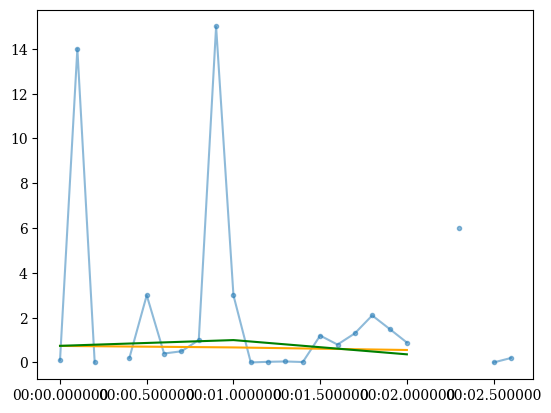

In [20]:
speed_test = [0.1,14,0, np.nan, 0.2, 3, 0.4, 0.5, 1, 15,3,0.002,0.03,0.045,0.02,1.2,0.8, 1.3, 2.1,1.5,0.89,np.nan, np.nan, 6, np.nan, 0.001, 0.2]
t_dt = pd.date_range(start='2023-01-01', periods=len(speed_test), freq='0.1s')
sp_smoothed, sp1s = speed_smooth(speed_test, t_dt, method="gaussian")
plt.plot(t_dt, speed_test, label="Raw Speed", marker='o', markersize=3, alpha=0.5)
plt.plot(sp_smoothed.index, sp_smoothed, label="Smoothed Speed", color='orange')
plt.plot(sp1s.index, sp1s, label="1s Resampled Speed", color='green')
print(sp1s, sp_smoothed)

In [102]:
def analysis_variables_df(df, jump_thresh=0.5, ext_time_s=1, speed_method="gaussian"):
    
    days = sorted(df["day"].unique())
    analysis_df = pd.DataFrame()
    sp1s_list = []
    sp_smoothed_list = []

    for day in days:
        d = df[df["day"] == day].sort_index()
        
        x_clean, y_clean, speed, r = clean_big_jumps(d, jump_thresh=jump_thresh, ext_time_s=ext_time_s)

        '''
        # Align sp1s to d.index and ensure it has the same length as other variables
        sp1s_aligned = sp1s.reindex(sp_smoothed.index, method='nearest', tolerance=pd.Timedelta('1s'))
        if len(sp1s_aligned) != len(x_clean):
            sp1s_aligned = sp1s_aligned.reindex(range(len(x_clean)), fill_value=np.nan)
        '''

        ends = np.where(d["sess_end"]==1)[0]-1  
        if len(ends) == 0:
            print(f"[Warning] No trials found for day {day}")
            continue
        starts = np.concatenate(([0], ends[:-1]+1))

        trials = np.zeros(len(x_clean), dtype=int)
        trial = 0
        task_state = np.full(len(x_clean), "unknown", dtype=object)
        lm_ht = np.zeros(len(x_clean), dtype=int)
        center_ht = np.zeros(len(x_clean), dtype=int)

        for sf, ef in zip(starts, ends):
            idx = np.arange(sf, ef + 1)

            mask_in = d["s"].isin(["lightsOut"]).to_numpy()[idx]
            mask_out = d["s"].isin(["foraging", "reward"]).to_numpy()[idx]
            mask_f = d["s"].isin(["foraging"]).to_numpy()[idx]
            finite_mask = np.isfinite(x_clean[idx]) & np.isfinite(y_clean[idx])

            valid_mask_in = finite_mask & mask_in
            valid_mask_out = finite_mask & mask_out
            valid_mask_f = finite_mask & mask_f
            if not valid_mask_in.any() or not valid_mask_out.any():
                continue

            task_state[idx[valid_mask_in]] = "inbound"
            task_state[idx[valid_mask_out]] = "outbound"

            lm_ht_trial = np.max(d["lm_ht"][idx[valid_mask_f]])
            center_ht_trial = np.max(d["center_ht"][idx[valid_mask_f]])
            lm_ht[idx] = lm_ht_trial
            center_ht[idx] = center_ht_trial 

            trials[idx] = trial
            trial += 1


        analysis_df_day = pd.DataFrame({
            "idx": np.arange(0, len(x_clean)),
            "x": x_clean,
            "y": y_clean,
            "speed": speed,
            "r": r,
            "trial": trials,
            "task_state": task_state,
            "lm_ht": lm_ht,
            "center_ht": center_ht,
            "state": d["s"].to_numpy(),
            "day": np.full(len(x_clean), day, dtype=int)
        })
        # Ensure the DataFrame has the same index as d
        analysis_df_day.index = d.index.tz_convert("US/Eastern")

        #analysis_df_day = analysis_df_day[analysis_df_day["trial"] > 0]
        analysis_df_day = analysis_df_day[analysis_df_day["task_state"]!="unknown"]
        
        #check whether trials are constent every day
        if not analysis_df_day["trial"].is_monotonic_increasing:
            print(f"[Warning] Trials are not consistent for day {day}.")

        sp_smoothed, sp1s = speed_smooth(analysis_df_day["speed"],
                                         analysis_df_day.index,
                                         method=speed_method)


        analysis_df = pd.concat([analysis_df, analysis_df_day],
                                ignore_index=False)
        
        sp1s_list.append(sp1s)
        sp_smoothed_list.append(sp_smoothed)
        

    return analysis_df, sp1s_list, sp_smoothed_list


analysis_df, sp1s_list, sp_smoothed_list = analysis_variables_df(df, jump_thresh=0.5, ext_time_s=1, speed_method="gaussian")
days = sorted(analysis_df["day"].unique())
analysis_df

C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\3384030315.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lm_ht_trial = np.max(d["lm_ht"][idx[valid_mask_f]])
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\3384030315.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center_ht_trial = np.max(d["center_ht"][idx[valid_mask_f]])


NaN mask: 575 out of 210219 values are NaN


idx         x         y     speed    r  \
2025-07-25 16:12:20.822000-04:00       0 -0.682781  0.239794  0.000000  3.0   
2025-07-25 16:12:20.835000-04:00       1 -0.655129  0.264881  2.872051  3.0   
2025-07-25 16:12:20.846000-04:00       2 -0.655129  0.264881  0.000000  3.0   
2025-07-25 16:12:20.856000-04:00       3 -0.658988  0.264104  0.393656  3.0   
2025-07-25 16:12:20.865000-04:00       4 -0.658988  0.264104  0.000000  3.0   
...                                  ...       ...       ...       ...  ...   
2025-07-25 17:19:29.702000-04:00  217240  0.106432 -0.270630  0.000000  1.0   
2025-07-25 17:19:29.729000-04:00  217241  0.106432 -0.270630  0.000000  1.0   
2025-07-25 17:19:29.753000-04:00  217242  0.106432 -0.270630  0.000000  1.0   
2025-07-25 17:19:29.767000-04:00  217243  0.106432 -0.270630  0.000000  1.0   
2025-07-25 17:19:29.789000-04:00  217244  0.106432 -0.270630  0.000000  1.0   

                                  trial task_state  lm_ht  center_ht  \
2025-07-25 16:12:20.822000-04:00      0   outbound    100        100   
2025-07-25 16:12:20.835000-04:00      0   outbound    100        100   
2025-07-25 16:12:20.846000-04:00      0   outbound    100        100   
2025-07-25 16:12:20.856000-04:00      0   outbound    100        100   
2025-07-25 16:12:20.865000-04:00      0   outbound    100        100   
...                                 ...        ...    ...        ...   
2025-07-25 17:19:29.702000-04:00     12    inbound   1000        800   
2025-07-25 17:19:29.729000-04:00     12    inbound   1000        800   
2025-07-25 17:19:29.753000-04:00     12    inbound   1000        800   
2025-07-25 17:19:29.767000-04:00     12    inbound   1000        800   
2025-07-25 17:19:29.789000-04:00     12    inbound   1000        800   

                                      state  day  
2025-07-25 16:12:20.822000-04:00   foraging    0  
2025-07-25 16:12:20.835000-04:00   foraging    0  
2025-07-25 16:12:20.846000-04:00   foraging    0  
2025-07-25 16:12:20.856000-04:00   foraging    0  
2025-07-25 16:12:20.865000-04:00   foraging    0  
...                                     ...  ...  
2025-07-25 17:19:29.702000-04:00  lightsOut    0  
2025-07-25 17:19:29.729000-04:00  lightsOut    0  
2025-07-25 17:19:29.753000-04:00  lightsOut    0  
2025-07-25 17:19:29.767000-04:00  lightsOut    0  
2025-07-25 17:19:29.789000-04:00  lightsOut    0  

[210219 rows x 11 columns]

## Outbound/Inbound Duration

- inbound: whether animals learns the center - expect the inbound duration decreases by day
- outbound: whether animals need to search for the LMs but not so much exploration - expect the outbound duration converge to a stable range of value, not too short or too long

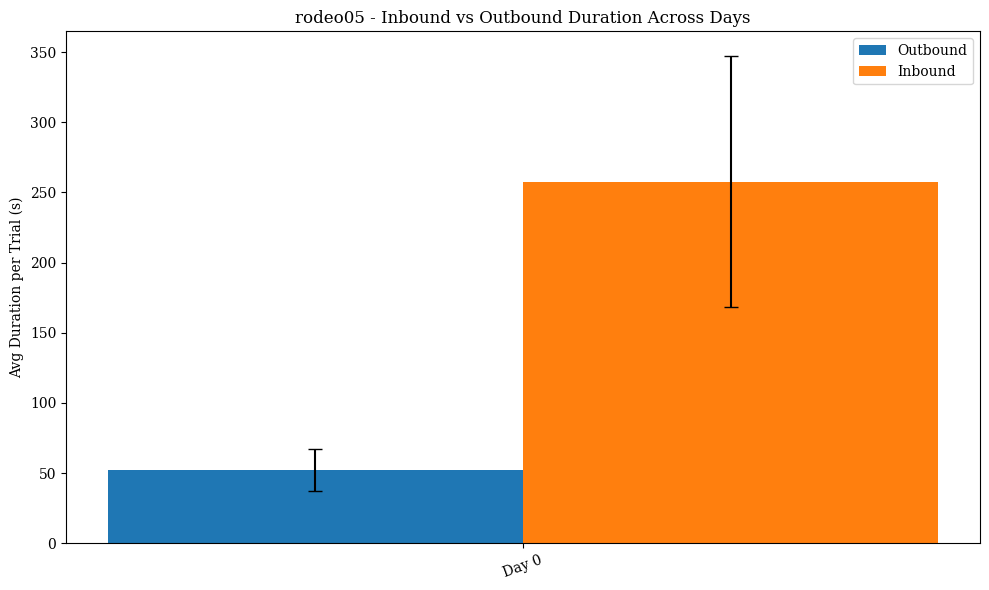

In [36]:
durations_inbound = []
durations_outbound = []


for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()

    day_in = []
    day_out = []

    for ti, trial_df in d.groupby("trial"):

        dt = trial_df.index.to_series().diff().dt.total_seconds().to_numpy()
        dt[0] = np.median(dt[1:])  # set first value

        mask_in = trial_df["task_state"] == "inbound"
        mask_out = trial_df["task_state"] == "outbound"
        finite_mask = np.isfinite(trial_df["x"].to_numpy()) & np.isfinite(trial_df["y"].to_numpy())

        valid_mask_in = finite_mask & mask_in
        valid_mask_out = finite_mask & mask_out
        if not valid_mask_in.any() or not valid_mask_out.any():
            continue
        dt_in = dt[valid_mask_in]
        dt_out = dt[valid_mask_out]

        dur_in = dt_in.sum()
        dur_out = dt_out.sum()

        day_in.append(dur_in)
        day_out.append(dur_out)

    durations_inbound.append(day_in)
    durations_outbound.append(day_out)

means_in = [np.mean(x) for x in durations_inbound]
sems_in = [sem(x, ddof=1) for x in durations_inbound]
means_out = [np.mean(x) for x in durations_outbound]
sems_out = [sem(x, ddof=1) for x in durations_outbound]

x = np.arange(len(days))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, means_out, width, yerr=sems_out, capsize=5, label="Outbound")
ax.bar(x + width/2, means_in,  width, yerr=sems_in,  capsize=5, label="Inbound")

ax.set_xticks(x)
ax.set_xticklabels([f"Day {d}" for d in days], rotation=20, ha="center")
ax.set_ylabel("Avg Duration per Trial (s)")
ax.set_title(f"{mouse_id} - Inbound vs Outbound Duration Across Days")
ax.legend()

plt.tight_layout()
plt.show()

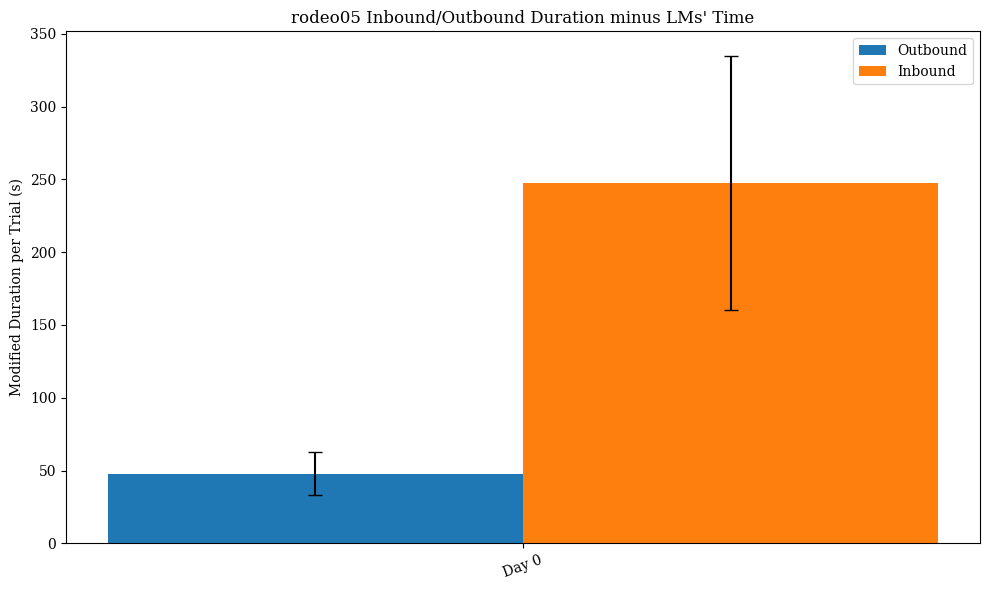

In [37]:
hex_round = (0.55/3)/np.sqrt(3)+0.01  # radius of hex

# indices in task_space
center_idx, corr_idx, wrong_idx = 0, 1, 2

durations_in_in = []  
durations_out_in = [] 

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()
    tree = tree_by_day[day]
    
    day_in = []
    day_out = []

    for ti, trial_df in d.groupby("trial"):

        dt = trial_df.index.to_series().diff().dt.total_seconds().to_numpy()
        dt[0] = np.median(dt[1:])  # set first value

        mask_in = trial_df["task_state"] == "inbound"
        mask_out = trial_df["task_state"] == "outbound"
        finite_mask = np.isfinite(trial_df["x"].to_numpy()) & np.isfinite(trial_df["y"].to_numpy())

        valid_mask_in = finite_mask & mask_in
        valid_mask_out = finite_mask & mask_out
        if not valid_mask_in.any() or not valid_mask_out.any():
            continue
    
        raw_in = dt[valid_mask_in]
        raw_out = dt[valid_mask_out]
        
        occ_in = np.zeros(7)
        occ_out = np.zeros(7)

        pts_in = np.column_stack([trial_df['x'].to_numpy()[valid_mask_in], trial_df['y'].to_numpy()[valid_mask_in]])
        pts_out = np.column_stack([trial_df['x'].to_numpy()[valid_mask_out], trial_df['y'].to_numpy()[valid_mask_out]])

        for (xpt, ypt), dt_frame in zip(pts_in, raw_in):
                hex_ids = tree.query_ball_point([xpt, ypt], r=hex_round)
                for h in hex_ids:
                    occ_in[h] += dt_frame

        for (xpt, ypt), dt_frame in zip(pts_out, raw_out):
                hex_ids = tree.query_ball_point([xpt, ypt], r=hex_round)
                for h in hex_ids:
                    occ_out[h] += dt_frame
        
        # subtract correct&wrong LM occupancy
        net_in = raw_in.sum()  - (occ_in[corr_idx] + occ_in[wrong_idx] + occ_in[center_idx])
        net_out = raw_out.sum() - (occ_out[corr_idx] + occ_out[wrong_idx] + occ_out[center_idx])
        
        day_in.append(net_in)
        day_out.append(net_out)
        
    durations_in_in.append(day_in)
    durations_out_in.append(day_out)

means_in = [np.mean(x) for x in durations_in_in]
sems_in = [sem(x, ddof=1) for x in durations_in_in]
means_out = [np.mean(x) for x in durations_out_in]
sems_out = [sem(x, ddof=1) for x in durations_out_in]


x = np.arange(len(days))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, means_out, width, yerr=sems_out, capsize=5, label="Outbound")
ax.bar(x + width/2, means_in,  width, yerr=sems_in,  capsize=5, label="Inbound")

ax.set_xticks(x)
ax.set_xticklabels([f"Day {d}" for d in days], rotation=20, ha="center")
ax.set_ylabel("Modified Duration per Trial (s)")
ax.set_title(f"{mouse_id} Inbound/Outbound Duration minus LMs' Time")
ax.legend()

plt.tight_layout()
plt.show()


### By trial

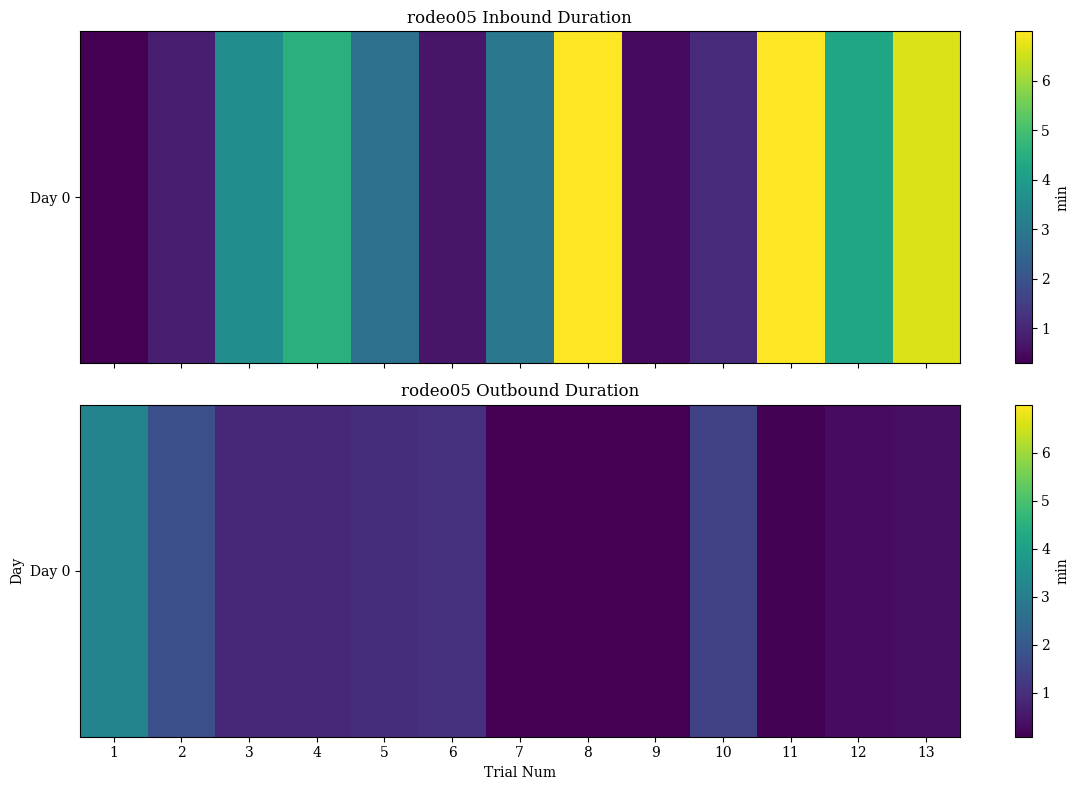

In [38]:
n_days = len(days)

inbound_heat  = []
outbound_heat = []

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()

    trial_durs_out = []
    trial_durs_in = []
    for ti, trial_df in d.groupby("trial"):

        t_dt = trial_df.index

        # which part of the trial to use
        mask_state_out = trial_df["task_state"]=="outbound"
        mask_state_in = trial_df["task_state"]=="inbound"

        t_out = t_dt[mask_state_out]
        t_in = t_dt[mask_state_in]

        if len(t_out) > 0:
            t_out_dur = (t_out[-1] - t_out[0]).total_seconds() / 60
            if t_out_dur > 0:
                trial_durs_out.append(t_out_dur)
            else:
                trial_durs_out.append(np.nan)
        else:
            trial_durs_out.append(np.nan)
        if len(t_in) > 0:
            t_in_dur = (t_in[-1] - t_in[0]).total_seconds() / 60
            if t_in_dur > 0:
                trial_durs_in.append(t_in_dur)
            else:
                trial_durs_in.append(np.nan)
        else: 
            trial_durs_in.append(np.nan)
            
    inbound_heat.append(trial_durs_in)
    outbound_heat.append(trial_durs_out)

max_trials_in = max(len(x) for x in inbound_heat)
max_trials_out = max(len(x) for x in outbound_heat)

heat_in = np.full((n_days, max_trials_in), np.nan)
heat_out = np.full((n_days, max_trials_out), np.nan)

for i, durs in enumerate(inbound_heat):
    heat_in[i, :len(durs)] = durs
for i, durs in enumerate(outbound_heat):
    heat_out[i, :len(durs)] = durs

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True)

# inbound
all_heat = np.concatenate([heat_in.flatten(), heat_out.flatten()])
c1 = ax1.imshow(heat_in, aspect="auto", interpolation="none", cmap="viridis", vmax=np.nanpercentile(all_heat, 95))
ax1.set_title(f"{mouse_id} Inbound Duration")
ax1.set_yticks(np.arange(n_days))
ax1.set_yticklabels([f"Day {d}" for d in days])
ax1.set_xticks(np.arange(0, max_trials_in, max(1, max_trials_in//20)))
ax1.set_xticklabels(np.arange(1, max_trials_in+1, max(1, max_trials_in//20)))
#ax1.hlines(3.5, *ax.get_xlim(), color="r", lw=1.5)


# outbound
c2 = ax2.imshow(heat_out, aspect="auto", interpolation="none", cmap="viridis", vmax=np.nanpercentile(all_heat, 95))  
ax2.set_ylabel("Day")
ax2.set_xlabel("Trial Num")
ax2.set_title(f"{mouse_id} Outbound Duration")
ax2.set_yticks(np.arange(n_days))
ax2.set_yticklabels([f"Day {d}" for d in days])
ax2.set_xticks(np.arange(0, max_trials_out, max(1, max_trials_out//20)))
ax2.set_xticklabels(np.arange(1, max_trials_out+1, max(1, max_trials_out//20)))
#ax2.hlines(3.5, *ax.get_xlim(), color="r", lw=1.5)


fig.colorbar(c1, ax=ax1, label="min")
fig.colorbar(c2, ax=ax2, label="min")

plt.tight_layout()
#fig.savefig(f"{mouse_id}fig/Time_Dur.png", dpi=150, bbox_inches="tight")
plt.show()
#plt.close(fig)

## Hex Occupancy 

- task space hex occupancy (time spent in the certain hex): whether unevenly distributed across hexes 
    - for outbound, expect to see larger occupancy time in the center and the wrong LM，and evenly distributed low occupancy time in the other hexes. As training goes by, the center time and wrong LM time should decrease to show that animals would actively leave the center to search for LMs, and would not always sit on the wrong LMs.
    - for inbound, all the occupancy is expected to decrease by day.

- room space: whether unevenly distributed across certain hexes (preference of certain hexes)
    - for inbound and outbound, expect to see similar occupancy of all the 6 hexes (allow unevenly distribution for a day, might due to animals leaving some smells or marks to certain hexes; pay attention to continuously high/low occupancy over days)

- importantly, the holding time is included in all the plots, thus for some days the hex occupancy is higher might due to the prolonged holding time.

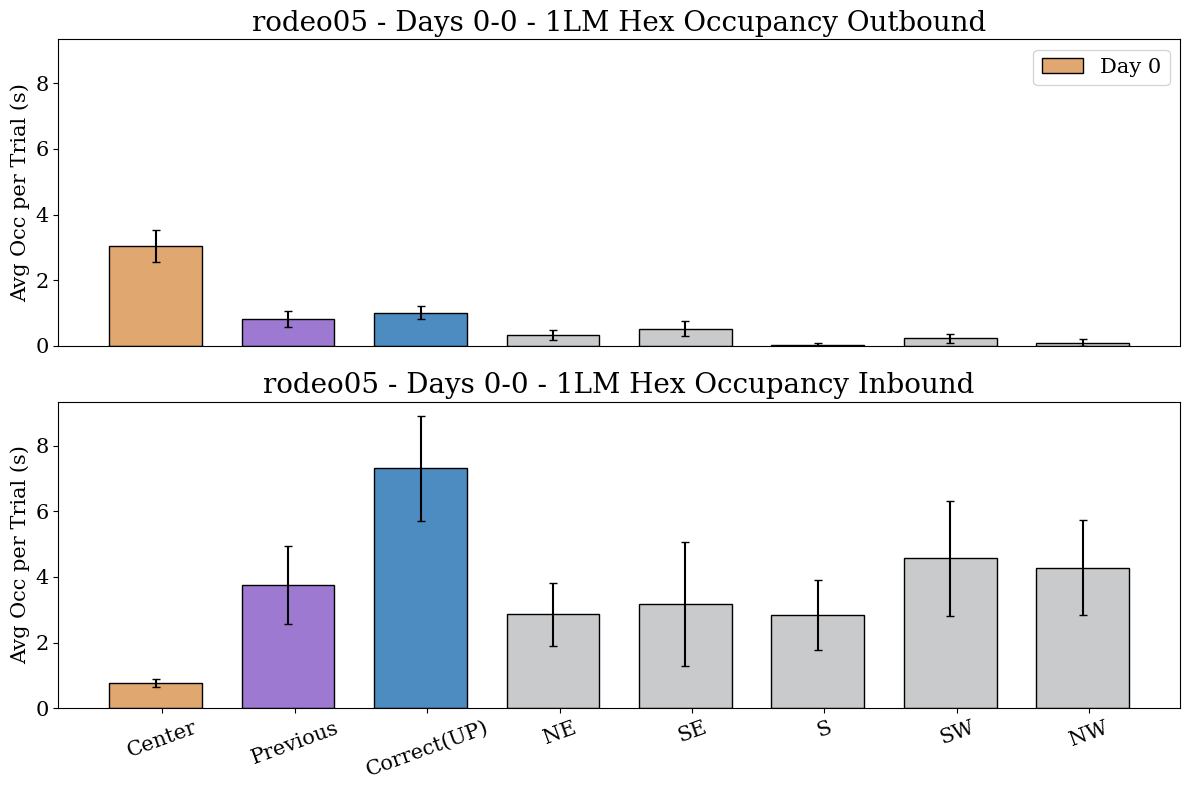

In [49]:
#os.makedirs(f"{mouse_id}fig/hist/inbound", exist_ok=True)
#os.makedirs(f"{mouse_id}fig/hist/outbound", exist_ok=True)

# ----- Config -----
hex_round = (0.55/3)/np.sqrt(3)+0.01  # radius of hex

#task_space = ["Center","Previous","Correct(UP)","Wrong(NE)","SE","S","SW","NW"]
task_space = ["Center","Previous","Correct(UP)","NE","SE","S","SW","NW"]
hex_colors = {
    "Center": "#e0a771",
    "Previous": "#9e79d1",
    "Correct(UP)": "#4d8cc1",
    #"Wrong(NE)": "#a9ccdb",
    "NE":"#c9cacb",
    "SE": "#c9cacb",
    "S": "#c9cacb",
    "SW": "#c9cacb",
    "NW": "#c9cacb"
}
n_hex = len(task_space)
n_days = len(days)

mean_mat_in = np.zeros((n_days, n_hex))
sem_mat_in = np.zeros((n_days, n_hex))
mean_mat_out = np.zeros((n_days, n_hex))
sem_mat_out = np.zeros((n_days, n_hex))

for direction in ["outbound","inbound"]:
    mean_mat = mean_mat_in if direction == "inbound" else mean_mat_out
    sem_mat = sem_mat_in if direction == "inbound" else sem_mat_out

    for di, day in enumerate(days):
        d = analysis_df[analysis_df["day"] == day].sort_index()
        tree = tree_by_day[day]

        trial_occs = []
        prev_occs = []
        r_last_trial = None

        for ti, trial_df in d.groupby("trial"):

            # Directional mask
            if direction == "inbound":
                t_df = trial_df[trial_df["task_state"]=="inbound"]
            else:
                t_df = trial_df[trial_df["task_state"]=="outbound"]


            pts = np.column_stack([t_df["x"], t_df["y"]])
            t_dt = t_df.index
            dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
            dt[0] = np.median(dt[1:]) 
            r = t_df["r"]

            occ = np.zeros(7, dtype=float)
            for (xpt, ypt), dt_frame in zip(pts, dt):
                hex_ids = tree.query_ball_point([xpt, ypt], r=hex_round)
                for h in hex_ids:
                    occ[h] += dt_frame

            r_trial = np.unique(r)[0]
            if r_last_trial is None:
                r_last_trial = r_trial
                continue

            up_last_trial = ((6-r_last_trial) % 6) + 1
            hex_this_trial = (up_last_trial + r_trial) % 6
            prev_occ = occ[int(hex_this_trial)]
            r_last_trial = r_trial

            trial_occs.append(occ)
            prev_occs.append(prev_occ)

        occ_arr = np.vstack(trial_occs) if len(trial_occs) > 0 else np.zeros((0, 7))
        mean_occ = occ_arr.mean(axis=0)
        sem_occ = occ_arr.std(axis=0, ddof=1)/np.sqrt(len(trial_occs)) if len(trial_occs) > 0 else np.zeros(7)

        prev_occ_arr = np.array(prev_occs)
        mean_prev = prev_occ_arr.mean() if len(prev_occs) > 0 else 0
        sem_prev = prev_occ_arr.std(ddof=1) / np.sqrt(len(prev_occs)) if len(prev_occs) > 0 else 0

        heights = np.hstack([ mean_occ[0], mean_prev, mean_occ[1:]])
        errors = np.hstack([ sem_occ[0], sem_prev, sem_occ[1:] ])

        mean_mat[di,:] = heights
        sem_mat[di,:] = errors

# maximum 7 days in a fig
group_size = 7
n_groups = math.ceil(n_days / group_size)
group_x = np.arange(n_hex)

for group_idx in range(n_groups):
    group_start = group_idx * group_size
    group_end = min((group_idx+1)*group_size, n_days)
    group_days = days[group_start:group_end]
    group_inds = np.arange(group_start, group_end)
    width = 0.7 / len(group_inds)

    fig, axs = plt.subplots(2, 1, figsize=(12,8), sharey=True)
    for ax, mean_mat, sem_mat, direction in zip(axs, [mean_mat_out, mean_mat_in], [sem_mat_out, sem_mat_in], ["Outbound","Inbound"]):
        for hi, lab in enumerate(task_space):
            for idx, di in enumerate(group_inds):
                x = group_x[hi] - 0.4 + (idx+0.5)*width
                ax.bar(x,
                       mean_mat[di,hi],
                       width=width,
                       yerr=sem_mat[di,hi],
                       capsize=3,
                       color=hex_colors[lab],
                       edgecolor="k",
                       label=f"Day {days[di]}" if hi==0 else None)

        ax.set_ylabel("Avg Occ per Trial (s)", fontsize=15)
        ax.set_title(f"{mouse_id} - Days {days[group_start]}-{days[group_end-1]} - 1LM Hex Occupancy {direction}", fontsize=20)
        if direction == "Outbound":
            ax.legend(bbox_to_anchor=(1,1), fontsize = 15) 
            ax.set_xticks([]) 
        else:
            ax.set_xticks(group_x)
            ax.set_xticklabels(task_space, rotation=20, ha="center", fontsize=15)
        ax.tick_params(axis='y', labelsize=15)  
    plt.tight_layout()
    plt.show()


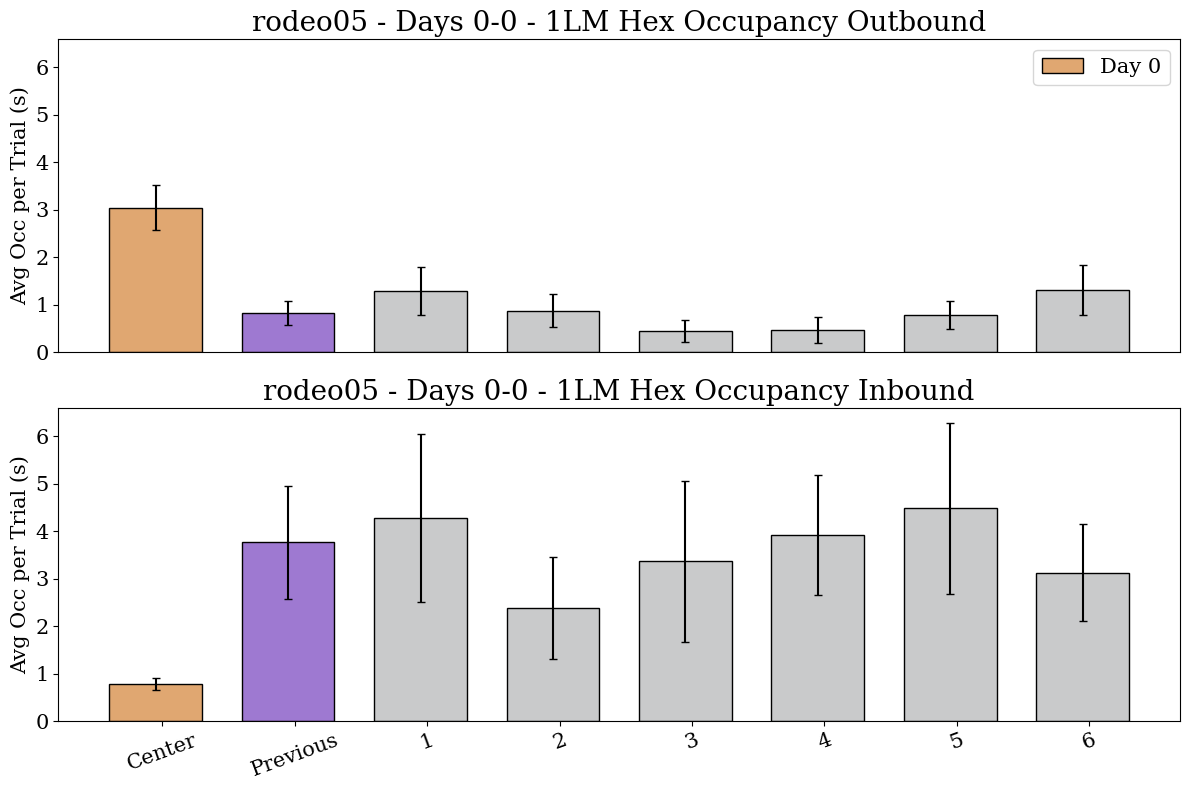

In [50]:
# ----- Config ----- 
hex_round = (0.55/3)/np.sqrt(3)+0.01  # radius of hex

#task_space = ["Center","Previous","Correct(UP)","Wrong(NE)","SE","S","SW","NW"]
room_space = ["Center","Previous","1","2","3","4","5","6"]


hex_colors = {
    "Center": "#e0a771",
    "Previous": "#9e79d1",
    "1": "#c9cacb",
    "2": "#c9cacb",
    "3": "#c9cacb",
    "4": "#c9cacb",
    "5": "#c9cacb",
    "6": "#c9cacb"
}
n_hex = len(room_space)
n_days = len(days)

mean_mat_in = np.zeros((n_days, n_hex))
sem_mat_in = np.zeros((n_days, n_hex))
mean_mat_out = np.zeros((n_days, n_hex))
sem_mat_out = np.zeros((n_days, n_hex))

for direction in ["outbound","inbound"]:
    mean_mat = mean_mat_in if direction == "inbound" else mean_mat_out
    sem_mat = sem_mat_in if direction == "inbound" else sem_mat_out

    for di, day in enumerate(days):
        d = analysis_df[analysis_df["day"] == day].sort_index()
        tree = tree_by_day[day]

        trial_occs = []
        prev_occs = []
        room_trial_occs = []
        r_last_trial = None

        for ti, trial_df in d.groupby("trial"):

            # Directional mask
            if direction == "inbound":
                t_df = trial_df[trial_df["task_state"]=="inbound"]
            else:
                t_df = trial_df[trial_df["task_state"]=="outbound"]


            pts = np.column_stack([t_df["x"], t_df["y"]])
            t_dt = t_df.index
            dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
            dt[0] = np.median(dt[1:]) 
            r = t_df["r"]

            occ = np.zeros(7, dtype=float)
            room_occ = np.zeros(7, dtype=float)
            for (xpt, ypt), dt_frame in zip(pts, dt):
                hex_ids = tree.query_ball_point([xpt, ypt], r=hex_round)
                for h in hex_ids:
                    occ[h] += dt_frame

            r_trial = np.unique(r)[0]

            if r_last_trial is None:
                r_last_trial = r_trial
                continue

            # map r_last_trial to r = 0
            up_last_trial = ((6-r_last_trial) % 6) + 1 # 1, 2, 3, 4, 5, 6 in room space

            # map r=0 to r_trial
            hex_this_trial = (up_last_trial + r_trial) % 6 # UP, NE, SE, S, SW, NW

            prev_occ = occ[int(hex_this_trial)]
            room_occ[0] = occ[0]  # Center
            for i in range (6):
                room_occ[i+1] = occ[int((i+1+r_trial) % 6)]
        
            r_last_trial = r_trial

            trial_occs.append(occ)
            prev_occs.append(prev_occ)
            room_trial_occs.append(room_occ)
            

        occ_arr = np.vstack(trial_occs) if len(trial_occs) > 0 else np.zeros((0, 7))
        mean_occ = occ_arr.mean(axis=0)
        sem_occ = occ_arr.std(axis=0, ddof=1)/np.sqrt(len(trial_occs)) if len(trial_occs) > 0 else np.zeros(7)

        prev_occ_arr = np.array(prev_occs)
        mean_prev = prev_occ_arr.mean()
        sem_prev = prev_occ_arr.std(ddof=1) / np.sqrt(len(prev_occs))

        room_occ_arr = np.vstack(room_trial_occs) if len(room_trial_occs) > 0 else np.zeros((0, 7))
        mean_room_occ = room_occ_arr.mean(axis=0)
        sem_room_occ = room_occ_arr.std(axis=0, ddof=1) / np.sqrt(len(room_trial_occs))

        heights = np.hstack([ mean_room_occ[0], mean_prev, mean_room_occ[1:]])
        errors = np.hstack([ sem_room_occ[0], sem_prev, sem_room_occ[1:] ])

        mean_mat[di,:] = heights
        sem_mat[di,:] = errors

'''
width = 0.7 / n_days           
group_x = np.arange(n_hex)    

fig, axs = plt.subplots(2, 1, figsize=(12,8), sharey=True)
for ax, mean_mat, sem_mat, direction in zip(axs, [mean_mat_out, mean_mat_in], [sem_mat_out, sem_mat_in], ["Outbound","Inbound"]):
    for hi, lab in enumerate(room_space):
        for di, day in enumerate(days): 
            x = group_x[hi] - 0.4 + (di+0.5)*width
            ax.bar(x,
                   mean_mat[di,hi],
                   width=width,
                   yerr=sem_mat[di,hi],
                   capsize=3,
                   color=hex_colors[lab],
                   edgecolor="k",
                   label=f"Day {day}" if hi==0 else None)

    ax.set_ylabel("Avg Occ per Trial (s)", fontsize=15)
    ax.set_title(f"{mouse_id} - Days - 2LM Hex Occupancy {direction}", fontsize=20)
    if direction == "Outbound":
        ax.legend(bbox_to_anchor=(1,1), fontsize = 15) 
        ax.set_xticks([])  
    else:
        ax.set_xticks(group_x)
        ax.set_xticklabels(room_space, rotation=20, ha="center", fontsize=15)
    ax.tick_params(axis='y', labelsize=15)  
plt.tight_layout()
plt.show()
'''

# maximum 7 days in a fig
group_size = 7
n_groups = math.ceil(n_days / group_size)
group_x = np.arange(n_hex)

for group_idx in range(n_groups):
    group_start = group_idx * group_size
    group_end = min((group_idx+1)*group_size, n_days)
    group_days = days[group_start:group_end]
    group_inds = np.arange(group_start, group_end)
    width = 0.7 / len(group_inds)

    fig, axs = plt.subplots(2, 1, figsize=(12,8), sharey=True)
    for ax, mean_mat, sem_mat, direction in zip(axs, [mean_mat_out, mean_mat_in], [sem_mat_out, sem_mat_in], ["Outbound","Inbound"]):
        for hi, lab in enumerate(room_space):
            for idx, di in enumerate(group_inds):
                x = group_x[hi] - 0.4 + (idx+0.5)*width
                ax.bar(x,
                       mean_mat[di,hi],
                       width=width,
                       yerr=sem_mat[di,hi],
                       capsize=3,
                       color=hex_colors[lab],
                       edgecolor="k",
                       label=f"Day {days[di]}" if hi==0 else None)

        ax.set_ylabel("Avg Occ per Trial (s)", fontsize=15)
        ax.set_title(f"{mouse_id} - Days {days[group_start]}-{days[group_end-1]} - 1LM Hex Occupancy {direction}", fontsize=20)
        if direction == "Outbound":
            ax.legend(bbox_to_anchor=(1,1), fontsize = 15) 
            ax.set_xticks([]) 
        else:
            ax.set_xticks(group_x)
            ax.set_xticklabels(room_space, rotation=20, ha="center", fontsize=15)
        ax.tick_params(axis='y', labelsize=15)  
    plt.tight_layout()
    plt.show()


### Spatial Occupancy Heatmap

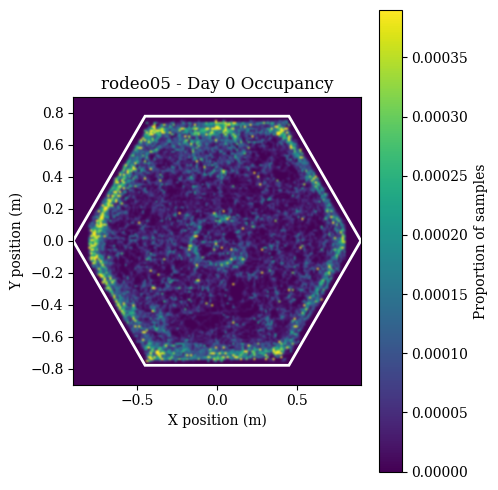

In [51]:
nbins = 150
arena_r = 0.9

xedges = np.linspace(-arena_r, arena_r, nbins+1)
yedges = np.linspace(-arena_r, arena_r, nbins+1)

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()

    # raw counts
    H_counts, _, _ = np.histogram2d(d["x"], d["y"], bins=[xedges, yedges])
    H = H_counts.T

    # normalize
    H_prop = H / H.sum()

    # take 99th percentile as vmax
    vmax = np.percentile(H_prop, 99)

    fig, ax = plt.subplots(figsize=(5,5))
    norm = Normalize(vmin=0, vmax=vmax, clip=True)
    im = ax.imshow(H_prop,
                   origin='lower',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   #cmap=plt.get_cmap('managua').reversed(),
                   cmap = 'viridis',
                   norm=norm,
                   interpolation='bicubic',
                   aspect='equal')

    hexagon = RegularPolygon((0,0),
                             numVertices=6,
                             radius=arena_r,
                             orientation=np.pi/6,
                             facecolor='none',
                             edgecolor='w',
                             linewidth=2)
    ax.add_patch(hexagon)

    ax.set_title(f'{mouse_id} - Day {day} Occupancy')
    ax.set_xlabel('X position (m)')
    ax.set_ylabel('Y position (m)')
    cbar = fig.colorbar(im, ax=ax, label='Proportion of samples')
    cbar.ax.set_ylim(0, vmax)  
    plt.tight_layout()
    plt.show()


## First-visited LM Hist & Rotation Check

Function **find_event_list** will return a structure like [{hex_id: "visit"/"sit"}, ...], indicating the order hexes visited/sit during inbound/outbound
- If "visit": (x,y) point falls into the large hex zone (r = 0.275) but not in the small hex zone (the real radius of hex) for the holding time 
- If "sit": (x,y) point falls into the small hex zone for the holding time

Define "visit"
- During **outbound period**, except {0: "visit"} (leaving the center zone), the first hex zone either "visit" or "sit"

To test whether animals might know direction of LMs or have biases (still uneven distribution test), expect to see
- for 6 hexes, first visit rates are all around chance level

Rotation degree check
- whether the rotation degree chosen every trial is aligned with random choice probability
- should not have rotation degree probability significantly different from chance level

In [53]:
def find_event_list(x, y, tree, r_small, r_large, ht, ht_center, dt):

    # get a list like: [{2:visit}, {3:visit}, {2:sit}, {1:visit}, {1:sit}]

    events = []
    N = len(x)
    pos = 0

    while pos < N:
        # in r_large?
        j = pos
        while j < N:
            ids = tree.query_ball_point([x[j], y[j]], r_large)
            if ids:
                cur_id = ids[0]
                break
            j += 1
        else:
            break 


        dwell_small = 0.0
        k = j
        while k < N:
            ids_large = tree.query_ball_point([x[k], y[k]], r_large)
            if not ids_large or ids_large[0] != cur_id:
                break
            # also in r_small?
            ids_small = tree.query_ball_point([x[k], y[k]], r_small)
            if ids_small and ids_small[0] == cur_id:
                dwell_small += dt[k]
            k += 1

        # sit or visit?
        threshold = ht_center if cur_id == 0 else ht
        evt_type = "sit" if dwell_small >= threshold else "visit"
        events.append({cur_id: evt_type})

        # starts from k next time
        pos = k

    # ensure the last event's value is "sit"
    last_id = list(events[-1].keys())[0]
    events[-1][last_id] = "sit"

    # 校正最后一个sit事件
    last_id, last_type = list(events[-1].items())[0]
    if last_type == "sit" and last_id in [0,1]:
        for idx in range(len(events)-1):
            eid, etype = list(events[idx].items())[0]
            if eid == last_id and etype == "sit":
                events[idx] = {eid: "visit"}


    # 合并连续相同id的visit为一个，并且如果visit后紧跟sit（同id）只保留sit
    merged_events = []
    i = 0
    while i < len(events):
        cur_id, cur_type = list(events[i].items())[0]
        # 合并连续visit
        if cur_type == "visit":
            j = i + 1
            while j < len(events):
                next_id, next_type = list(events[j].items())[0]
                if next_type == "visit" and next_id == cur_id:
                    j += 1
                else:
                    break
            # 如果合并后紧跟一个sit且id相同，只保留sit
            if j < len(events):
                next_id, next_type = list(events[j].items())[0]
                if next_type == "sit" and next_id == cur_id:
                    merged_events.append({cur_id: "sit"})
                    i = j + 1
                    continue
            merged_events.append({cur_id: "visit"})
            i = j
        else:
            merged_events.append(events[i])
            i += 1
    events = merged_events

    return events

C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\1950951024.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  LM_holding_time = t_df["lm_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\1950951024.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center_holding_time = t_df["center_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\2139655089.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ids = tr

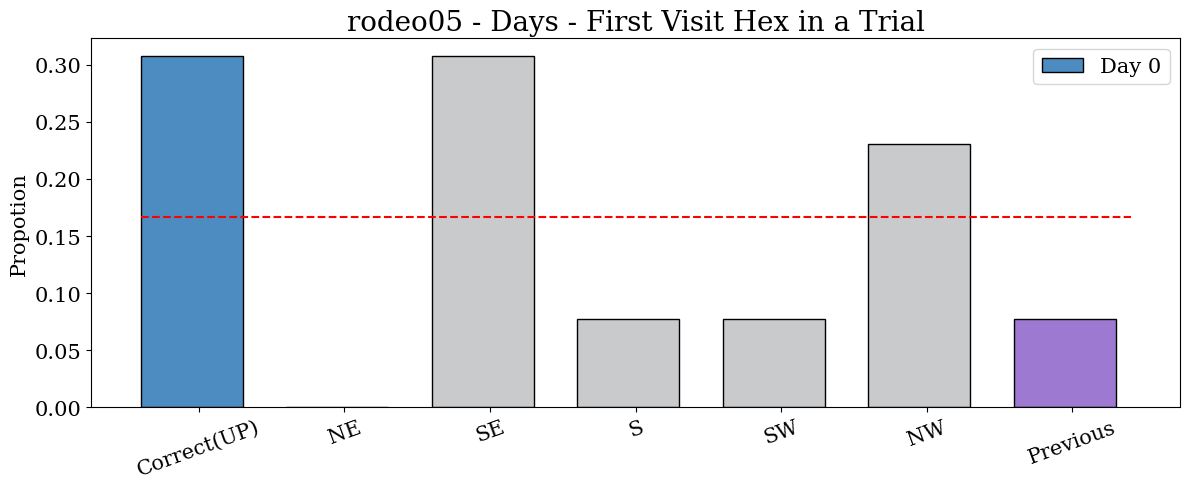

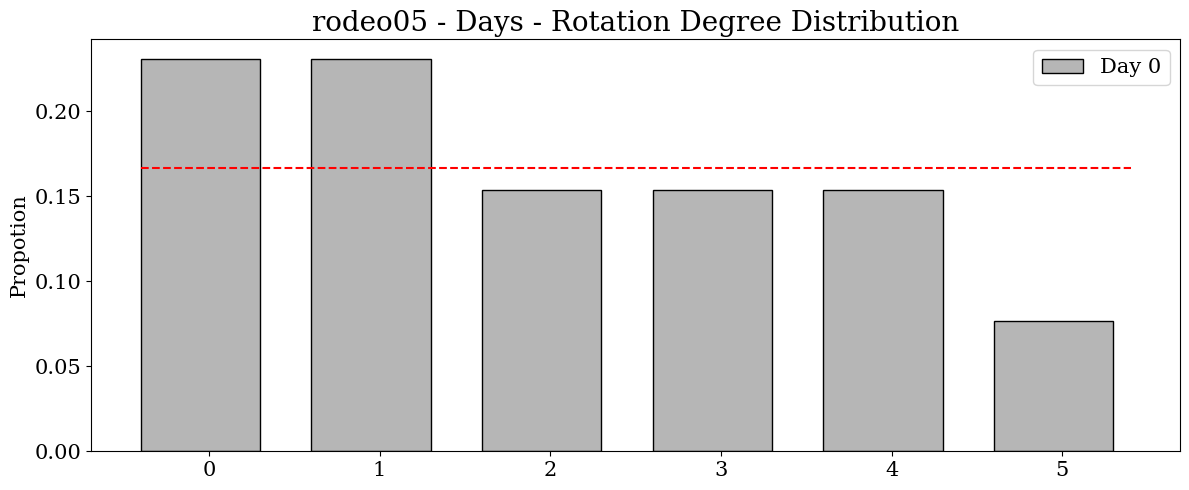

In [54]:
#os.makedirs(f"{mouse_id}fig/hist/", exist_ok=True)

# ----- Config -----
   
#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211
#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158
#hex_zone_r = 0.275 # max
hex_zone_r = (0.55/3)/np.sqrt(3)+0.01  # radius of hex

#task_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]
task_space = ["Correct(UP)","NE","SE","S","SW","NW","Previous"]

hex_colors = {
    "Correct(UP)": "#4d8cc1",
    #"Wrong(NE)": "#a9ccdb",
    "NE": "#c9cacb",
    "SE": "#c9cacb",
    "S": "#c9cacb",
    "SW": "#c9cacb",
    "NW": "#c9cacb",
    "Previous": "#9e79d1"
}

n_hex = len(task_space)
n_days = len(days)

prop_mat = np.zeros((n_days, n_hex))
r_mat = np.zeros((n_days, 6))


for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()
    tree = tree_by_day[day]
    

    hex_visit = np.zeros(6, dtype=float)
    prev_hex = 0
    trials = 0
    r_last_trial = None
    r_trial_day = np.zeros(6, dtype=float)

    for ti, trial_df in d.groupby("trial"):
        t_df = trial_df[trial_df["task_state"]=="outbound"]

        # extract the cleaned coords & dt for this trial
        x_pts = t_df["x"]
        y_pts = t_df["y"]
        
        t_dt = t_df.index
        dt_pts = t_dt.to_series().diff().dt.total_seconds().to_numpy()
        dt_pts[0] = np.median(dt_pts[1:]) 

        LM_holding_time = t_df["lm_ht"][0] / 1000
        center_holding_time = t_df["center_ht"][0] / 1000
        r = t_df["r"]

        events = find_event_list(
            x_pts, y_pts, tree,
            r_small=hex_zone_r,
            r_large=0.275,
            ht=LM_holding_time,
            ht_center=center_holding_time,
            dt=dt_pts
        )

        if not events:
            continue

        for event in events:
            id, _ = list(event.items())[0]
            if id == 0:
                continue
            else:
                first_id = id
                break

        hex_visit[first_id-1] += 1

        trials += 1

        # rotation‐distribution as before
        r_trial = int(np.unique(r)[0])
        r_trial_day[r_trial] += 1

        # for “previous” logic: compare the first two events
        if len(events) > 1 and r_last_trial is not None:
            # map last rotation → target hex in room space
            up_last = ((6 - r_last_trial) % 6) + 1
            hex_this = (up_last + r_trial) % 6
            if first_id == hex_this:
                prev_hex += 1

        r_last_trial = r_trial

    # after loop:
    if trials>0:
        prop_visit = hex_visit / trials
        prop_prev  = prev_hex   / trials
        r_prop     = r_trial_day / trials

        prop_mat[di,:] = np.hstack([prop_visit, prop_prev])
        r_mat   [di,:] = r_prop

width = 0.7 / n_days           
group_x = np.arange(n_hex)  
group_x2 = np.arange(6)  

fig, ax = plt.subplots(figsize=(12,5))

for hi, lab in enumerate(task_space):
    for di, day in enumerate(days):
        x = group_x[hi] - 0.4 + (di+0.5)*width
        ax.bar(x,
               prop_mat[di,hi],
               width=width,
               capsize=3,
               color=hex_colors[lab],
               edgecolor="k",
               label=f"Day {day}" if hi==0 else None)
        
ax.set_xticks(group_x)
ax.set_xticklabels(task_space, rotation=20, ha="center",fontsize = 15)
ax.set_ylabel("Propotion", fontsize = 15)
ax.set_title(f"{mouse_id} - Days - First Visit Hex in a Trial", fontsize = 20)
ax.legend(bbox_to_anchor=(1,1), fontsize = 15)
ax.hlines(1/6, group_x[0] - 0.4, group_x[-1] + 0.4, colors='r', linestyles='dashed')
ax.tick_params(axis='y', labelsize=15) 
plt.tight_layout()

#fig.savefig(f"{mouse_id}fig/hist/First_Visit.png", dpi=150, bbox_inches="tight")
plt.show()
#plt.close(fig)

fig2, ax2 = plt.subplots(figsize=(12,5))

for hi, lab in enumerate([0,1,2,3,4,5]):
    for di, day in enumerate(days):
        x = group_x2[hi] - 0.4 + (di+0.5)*width
        ax2.bar(x,
               r_mat[di,hi],
               width=width,
               capsize=3,
               color = "#b6b6b6",
               edgecolor="k",
               label=f"Day {day}" if hi==0 else None)
        
ax2.set_xticks(group_x2)
ax2.set_xticklabels([0,1,2,3,4,5], ha="center", fontsize = 15)
ax2.set_ylabel("Propotion", fontsize = 15)
ax2.set_title(f"{mouse_id} - Days - Rotation Degree Distribution", fontsize = 20)
ax2.legend(bbox_to_anchor=(1,1), fontsize = 15)
ax2.hlines(1/6, group_x2[0] - 0.4, group_x2[-1] + 0.4, colors='r', linestyles='dashed')
ax2.tick_params(axis='y', labelsize=15) 
plt.tight_layout()

#fig.savefig(f"{mouse_id}fig/hist/First_Visit.png", dpi=150, bbox_inches="tight")
plt.show()
#plt.close(fig)



In [55]:
hex_visit

array([4., 0., 4., 1., 1., 3.])

Independent t‑test
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


c:\Users\sunr\AppData\Local\miniconda3\envs\JVLabEnv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


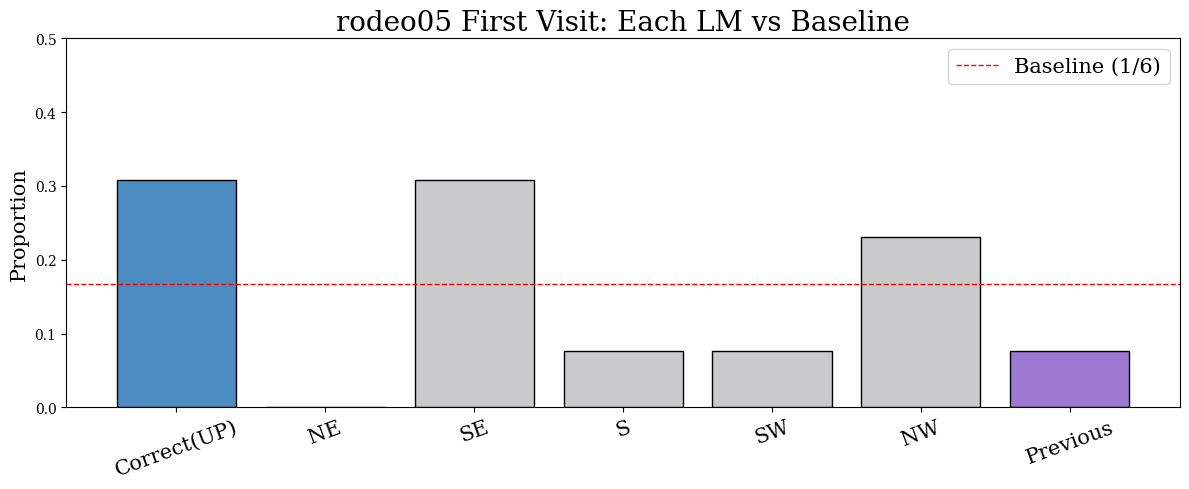

In [56]:
prop_mean = np.nanmean(prop_mat, axis=0)
prop_sem = np.nanstd(prop_mat, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(prop_mat), axis=0))

baseline = np.ones(len(prop_mat[:,0]), dtype=float) * (1/6)

# t test
pvals = []
for i in range(7):
    _, p = ttest_ind(prop_mat[:,i], baseline, equal_var=False)
    pvals.append(p)

print("Independent t‑test")
print(pvals)


fig, ax = plt.subplots(figsize=(12,5))
x_pos = np.arange(7)
#colors = ["#4d8cc1", "#a9ccdb", "#c9cacb", "#c9cacb", "#c9cacb", "#c9cacb", "#9e79d1"]
colors = ["#4d8cc1", "#c9cacb", "#c9cacb", "#c9cacb", "#c9cacb", "#c9cacb", "#9e79d1"]

ax.bar(x_pos, prop_mean, yerr=prop_sem, capsize=5, color=colors, edgecolor='k')

def sig_label(p):
    if p < 0.001: return '***'
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return 'ns'

y_max = max(prop_mean + prop_sem)
h_step = 0.03

for i, p in enumerate(pvals):
    y = prop_mean[i] + prop_sem[i] + h_step
    ax.text(i, y, sig_label(p), ha='center', va='bottom', fontsize=15)

ax.axhline(1/6, color='r', linestyle='--', lw=1, label='Baseline (1/6)')
ax.set_xticks(x_pos)
ax.set_ylim([0,0.5])
ax.set_xticklabels(task_space, rotation=20, ha='center', fontsize = 15)
ax.set_ylabel('Proportion', fontsize = 15)
ax.set_title(f'{mouse_id} First Visit: Each LM vs Baseline', fontsize = 20)
ax.legend(fontsize = 15)
ax2.tick_params(axis='y', labelsize=15) 
plt.tight_layout()
#fig.savefig(f"{mouse_id}fig/hist/First_Visit_vs_baseline.png", dpi=150, bbox_inches="tight")
plt.show()
#plt.close(fig)


Independent t‑test
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


c:\Users\sunr\AppData\Local\miniconda3\envs\JVLabEnv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


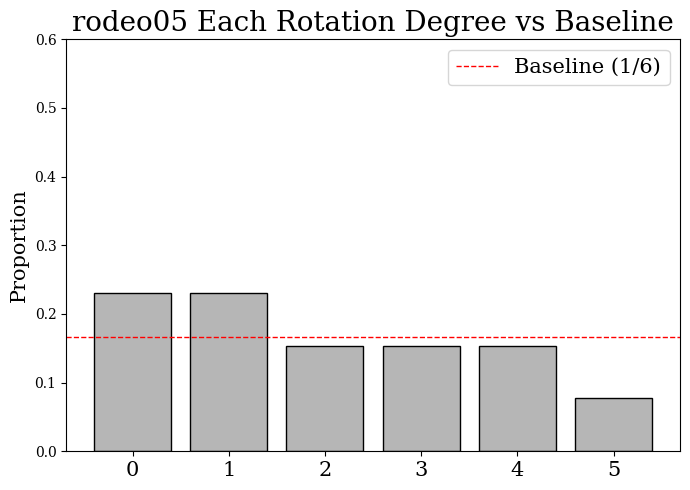

In [57]:
prop_mean = np.nanmean(r_mat, axis=0)
prop_sem = np.nanstd(r_mat, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(r_mat), axis=0))

baseline = np.ones(len(r_mat[:,0]), dtype=float) * (1/6)

# t test
pvals = []
for i in range(6):
    _, p = ttest_ind(r_mat[:,i], baseline, equal_var=False)
    pvals.append(p)

print("Independent t‑test")
print(pvals)


fig, ax = plt.subplots(figsize=(7,5))
x_pos = np.arange(6)

ax.bar(x_pos, prop_mean, yerr=prop_sem, capsize=5, color="#b6b6b6", edgecolor='k')

def sig_label(p):
    if p < 0.001: return '***'
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return 'ns'

y_max = max(prop_mean + prop_sem)
h_step = 0.03

for i, p in enumerate(pvals):
    y = prop_mean[i] + prop_sem[i] + h_step
    ax.text(i, y, sig_label(p), ha='center', va='bottom', fontsize=15)

ax.axhline(1/6, color='r', linestyle='--', lw=1, label='Baseline (1/6)')
ax.set_xticks(x_pos)
ax.set_ylim([0,0.6])
ax.set_xticklabels([0,1,2,3,4,5], ha='center', fontsize = 15)
ax.set_ylabel('Proportion', fontsize = 15)
ax.set_title(f'{mouse_id} Each Rotation Degree vs Baseline', fontsize = 20)
ax.legend(fontsize = 15)
ax2.tick_params(axis='y', labelsize=15) 
plt.tight_layout()
#fig.savefig(f"{mouse_id}fig/hist/First_Visit_vs_baseline.png", dpi=150, bbox_inches="tight")
plt.show()
#plt.close(fig)


## False Positive Rate & Beh Strategy

The function "find_hold_list", the block outbound and block inbound are no longer used

Function **find_event_list** will return a structure like [{hex_id: "visit"/"sit"}, ...], indicating the order hexes visited/sit during inbound/outbound
- If "visit": (x,y) point falls into the large hex zone (r = 0.275) but not in the small hex zone (the real radius of hex) for the holding time 
- If "sit": (x,y) point falls into the small hex zone for the holding time

**false positive rate for outbound**: valid cases but with {2: "sit"} in the list (has sit on the wrong LM before the correct LM) / valid cases({1: "sit"} the correct LM is the last hex in the list)

**analysis of the next hex visited after sitting on the wrong LM**: expect to see more left turns than the right turns (turn left to the right LM), so that it could indicate animals know the relative position of the two LMs

**outbound sit rate of two LMs**: try to figure out how many chances when approaching the LM, animals will sit instead of just visit; expect the sit rate for correct LM is between 0.5-1, and for wrong LM is 0-0.5

**direct return rate for inbound**: [1, 0] list case / valid case ({0: "sit"} the center is the last hex in the list and {1: "sit"/"visit"} the correct LM is the first), so as to see how much proportion of trials animals directly go back to center right after being rewarded

In [23]:
def find_hold_list(x, y, tree, hex_r, hold_time, dt):
    """
    get a list of hexes id that the mouse has spent > holding time on before LM reward
    """

    def scan(idx_start, exclude_id=None):
        last_id = None
        dwell = 0.0

        for i in idx_start:
            ids = tree.query_ball_point([x[i], y[i]], r=hex_r)

            if not ids or ids[0] == exclude_id:
                last_id = None
                dwell = 0.0
                continue

            h = ids[0]
            if h == last_id:
                dwell += dt[i]
            else:
                last_id = h
                dwell = dt[i]

            if dwell >= hold_time:
                return h, i
            
        return None, None

    hold_list = []
    start_idx = -1
    last_h = None
    while start_idx+1 < len(x):

        h, i = scan(np.arange(start_idx+1, len(x)), exclude_id=last_h)

        if h is None:
            break

        last_h = h
        start_idx = i
        hold_list.append(h)


    return hold_list


In [24]:
def find_event_list(x, y, tree, r_small, r_large, ht, ht_center, dt):

    # get a list like: [{2:visit}, {3:visit}, {2:sit}, {1:visit}, {1:sit}]

    events = []
    N = len(x)
    pos = 0

    while pos < N:
        # in r_large?
        j = pos
        while j < N:
            ids = tree.query_ball_point([x[j], y[j]], r_large)
            if ids:
                cur_id = ids[0]
                break
            j += 1
        else:
            break 


        dwell_small = 0.0
        k = j
        while k < N:
            ids_large = tree.query_ball_point([x[k], y[k]], r_large)
            if not ids_large or ids_large[0] != cur_id:
                break
            # also in r_small?
            ids_small = tree.query_ball_point([x[k], y[k]], r_small)
            if ids_small and ids_small[0] == cur_id:
                dwell_small += dt[k]
            k += 1

        # sit or visit?
        threshold = ht_center if cur_id == 0 else ht
        evt_type = "sit" if dwell_small >= threshold else "visit"
        events.append({cur_id: evt_type})

        # starts from k next time
        pos = k

    # ensure the last event's value is "sit"
    last_id = list(events[-1].keys())[0]
    events[-1][last_id] = "sit"

    # 校正最后一个sit事件
    last_id, last_type = list(events[-1].items())[0]
    if last_type == "sit" and last_id in [0,1]:
        for idx in range(len(events)-1):
            eid, etype = list(events[idx].items())[0]
            if eid == last_id and etype == "sit":
                events[idx] = {eid: "visit"}


    # 合并连续相同id的visit为一个，并且如果visit后紧跟sit（同id）只保留sit
    merged_events = []
    i = 0
    while i < len(events):
        cur_id, cur_type = list(events[i].items())[0]
        # 合并连续visit
        if cur_type == "visit":
            j = i + 1
            while j < len(events):
                next_id, next_type = list(events[j].items())[0]
                if next_type == "visit" and next_id == cur_id:
                    j += 1
                else:
                    break
            # 如果合并后紧跟一个sit且id相同，只保留sit
            if j < len(events):
                next_id, next_type = list(events[j].items())[0]
                if next_type == "sit" and next_id == cur_id:
                    merged_events.append({cur_id: "sit"})
                    i = j + 1
                    continue
            merged_events.append({cur_id: "visit"})
            i = j
        else:
            merged_events.append(events[i])
            i += 1
    events = merged_events

    return events

### Outbound

In [35]:
'''
os.makedirs(f"{mouse_id}fig/hist/", exist_ok=True)

# ----- Config -----
jump_thresh = 0.5
ext_time_s = 1
   
#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211
#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158
#hex_zone_r = 0.275
#hex_zone_r = 0.12
hex_zone_r = (0.55/3)/np.sqrt(3) 

task_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]
hex_colors = {
    "Correct(UP)": "#4d8cc1",
    "Wrong(NE)": "#a9ccdb",
    "SE": "#c9cacb",
    "S": "#c9cacb",
    "SW": "#c9cacb",
    "NW": "#c9cacb",
    "Previous": "#9e79d1"
}

n_hex = len(task_space)
n_days = len(days)

fpr_list = []
prob21_list = []
prob23_list = []

for di, day in enumerate(days):


    d = df[df["day"]==day].sort_index().copy()
    tree = tree_by_day[day]
    LM_holding_time = LM_holding_time_list[di] / 1000
    
    # timestamp & dt 
    t_dt = d.index.tz_convert("US/Eastern")
    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
    dt[0] = np.median(dt[1:])  
    median_dt = np.median(dt)
    speed_th = jump_thresh / median_dt 

    
    # traj clean: remove jumps
    xw = d["x"].to_numpy()
    yw = -d["y"].to_numpy()
    r = d["r"].to_numpy()

    mask_edge = (d["x"].abs() > 0.8) | (d["y"].abs() > 0.75)

    dx = np.concatenate(([0], np.diff(xw)))
    dy = np.concatenate(([0], np.diff(yw)))
    speed = np.hypot(dx, dy) / dt
    jumps = speed > speed_th

    ext_frames = max(1, int(ext_time_s / median_dt))
    mask_jump = np.convolve(jumps.astype(int),np.ones(ext_frames, dtype=int), mode="same") > 0

    mask = mask_edge | mask_jump

    x_clean = xw.copy(); 
    x_clean[mask] = np.nan
    y_clean = yw.copy(); 
    y_clean[mask] = np.nan
    r_clean = r.copy()
    r_clean[mask] = np.nan

    # trials: skip first three
    ends = np.where(d["sess_end"]==1)[0][1:]-1  
    if len(ends) == 0:
        print(f"[Warning] No trials found for day {day}")
        continue
    starts = np.concatenate(([1], ends[:-1]+1))

    trials = []
    next_after2 = []
    
    for sf, ef in zip(starts, ends):
        idx = np.arange(sf, ef+1)

        # which part of the trial to use
        mask_state = d["s"].isin(["foraging","reward"]).to_numpy()[idx]
        #mask_state = d["s"].isin(["lightsOut"]).to_numpy()[idx]

        finite_mask = np.isfinite(x_clean[idx]) & np.isfinite(y_clean[idx])
        valid_mask = finite_mask & mask_state
        #valid_mask = finite_mask
        if not valid_mask.any():
            continue

        xpt = x_clean[idx][valid_mask]
        ypt = y_clean[idx][valid_mask]

        dt_f = dt[idx][valid_mask]

        hold_list = find_hold_list(xpt, ypt, tree, hex_zone_r, LM_holding_time, dt_f)
        print(hold_list)
        last_h = hold_list[-1] if len(hold_list) > 0 else None
        before_last_h = hold_list[-2] if len(hold_list) > 1 else None

        for j in range(len(hold_list)-1):
            if hold_list[j] == 2:
                next_after2.append(hold_list[j+1])

        #is_fp = (last_h == 1) and (before_last_h == 2)
        is_fp = (last_h == 1) and (2 in hold_list)

        #if last_h is None or (last_h is not None and 2 in hold_list[:-3] and before_last_h != 2):
        #    print(hold_list)
        if last_h != 1:
            continue
        else:
            trials.append({
                'last': last_h,
                'before last': before_last_h,
                'is_fp': is_fp
            })

    if len(next_after2) > 0:
        p21 = next_after2.count(1) / len(next_after2)
        p23 = next_after2.count(3) / len(next_after2)
    else:
        p21 = 0.0
        p23 = 0.0

    prob21_list.append(p21)
    prob23_list.append(p23)
             

    df_t = pd.DataFrame(trials)
    # FPR
    fpr = df_t['is_fp'].mean()
    fpr_list.append(fpr)

    fp_only = df_t[df_t['is_fp']]
    trans_counts = Counter(fp_only['before last'])
    total_fp = len(fp_only)
    trans_probs = {h: cnt/total_fp for h,cnt in trans_counts.items()}

plt.plot(days, fpr_list, marker = 'o')
plt.ylabel("False Positive Rate")
plt.xlabel("Day")

plt.figure(figsize=(6,4))
plt.hlines(0.5, xmin=days[0], xmax=days[-1], color="k", linestyle="--", alpha=0.7)
plt.plot(days, prob21_list, marker='o', label='2 → 1')
plt.plot(days, prob23_list, marker='o', label='2 → 3')
plt.ylabel("P(next hold | first = wrong)")
plt.xlabel("Day")
plt.legend()
plt.title("Wrong→Left(Correct) Hex vs Wrong→Right Hex")
plt.tight_layout()
plt.show()
'''

'\nos.makedirs(f"{mouse_id}fig/hist/", exist_ok=True)\n\n# ----- Config -----\njump_thresh = 0.5\next_time_s = 1\n\n#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211\n#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158\n#hex_zone_r = 0.275\n#hex_zone_r = 0.12\nhex_zone_r = (0.55/3)/np.sqrt(3) \n\ntask_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]\nhex_colors = {\n    "Correct(UP)": "#4d8cc1",\n    "Wrong(NE)": "#a9ccdb",\n    "SE": "#c9cacb",\n    "S": "#c9cacb",\n    "SW": "#c9cacb",\n    "NW": "#c9cacb",\n    "Previous": "#9e79d1"\n}\n\nn_hex = len(task_space)\nn_days = len(days)\n\nfpr_list = []\nprob21_list = []\nprob23_list = []\n\nfor di, day in enumerate(days):\n\n\n    d = df[df["day"]==day].sort_index().copy()\n    tree = tree_by_day[day]\n    LM_holding_time = LM_holding_time_list[di] / 1000\n\n    # timestamp & dt \n    t_dt = d.index.tz_convert("US/Eastern")\n    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()\n    dt[0] = np.median(dt[1:])  \n    median_dt =

In [36]:
'''
mean = [np.nanmean(prob21_list, axis=0), np.nanmean(prob23_list, axis=0)]
sem = [np.nanstd(prob21_list, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(prob21_list), axis=0)),
       np.nanstd(prob23_list, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(prob23_list), axis=0))]


_, p = ttest_ind(prob21_list, prob23_list, equal_var=False)


fig, ax = plt.subplots(figsize=(7,5))
x_pos = np.arange(2)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.bar(x_pos, mean, yerr=sem, capsize=5, edgecolor='k', color=[default_colors[0], default_colors[1]], alpha = 0.85)

def sig_label(p):
    if p < 0.001: return '***'
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return 'ns'

y_max = max(mean + sem)
h_step = 0.03


y = np.max(mean) + np.max(sem) + h_step
ax.text(0.5, y, sig_label(p), ha='center', va='bottom', fontsize=15)

ax.set_xticks(x_pos)
ax.set_ylim([0,1])
ax.set_xticklabels(["Wrong→Left(Correct) Hex", "Wrong→Right Hex"], ha='center', fontsize = 15)
ax.set_ylabel('Proportion', fontsize = 15)
ax.set_title(f'{mouse_id} Next Hex of Wrong LM', fontsize = 20)
ax.tick_params(axis='y', labelsize=15) 
plt.tight_layout()
#fig.savefig(f"{mouse_id}fig/hist/First_Visit_vs_baseline.png", dpi=150, bbox_inches="tight")
plt.show()
#plt.close(fig)
'''


'\nmean = [np.nanmean(prob21_list, axis=0), np.nanmean(prob23_list, axis=0)]\nsem = [np.nanstd(prob21_list, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(prob21_list), axis=0)),\n       np.nanstd(prob23_list, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(prob23_list), axis=0))]\n\n\n_, p = ttest_ind(prob21_list, prob23_list, equal_var=False)\n\n\nfig, ax = plt.subplots(figsize=(7,5))\nx_pos = np.arange(2)\n\ndefault_colors = plt.rcParams[\'axes.prop_cycle\'].by_key()[\'color\']\nax.bar(x_pos, mean, yerr=sem, capsize=5, edgecolor=\'k\', color=[default_colors[0], default_colors[1]], alpha = 0.85)\n\ndef sig_label(p):\n    if p < 0.001: return \'***\'\n    if p < 0.01: return \'**\'\n    if p < 0.05: return \'*\'\n    return \'ns\'\n\ny_max = max(mean + sem)\nh_step = 0.03\n\n\ny = np.max(mean) + np.max(sem) + h_step\nax.text(0.5, y, sig_label(p), ha=\'center\', va=\'bottom\', fontsize=15)\n\nax.set_xticks(x_pos)\nax.set_ylim([0,1])\nax.set_xticklabels(["Wrong→Left(Correct) Hex", "Wrong→Right H

### Inbound

In [37]:
'''
os.makedirs(f"{mouse_id}fig/hist/", exist_ok=True)

# ----- Config -----
jump_thresh = 0.5
ext_time_s = 1
   
#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211
#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158
#hex_zone_r = 0.275
#hex_zone_r = 0.12
hex_zone_r = (0.55/3)/np.sqrt(3) 

task_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]
hex_colors = {
    "Correct(UP)": "#4d8cc1",
    "Wrong(NE)": "#a9ccdb",
    "SE": "#c9cacb",
    "S": "#c9cacb",
    "SW": "#c9cacb",
    "NW": "#c9cacb",
    "Previous": "#9e79d1"
}

n_hex = len(task_space)
n_days = len(days)

drr_list = []

for di, day in enumerate(days):

    d = df[df["day"]==day].sort_index().copy()
    tree = tree_by_day[day]
    if day <= 6:
        center_holding_time = 100 / 1000
    else:
        center_holding_time = center_holding_time_list[di] / 1000
    
    # timestamp & dt 
    t_dt = d.index.tz_convert("US/Eastern")
    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
    dt[0] = np.median(dt[1:])  
    median_dt = np.median(dt)
    speed_th = jump_thresh / median_dt 

    
    # traj clean: remove jumps
    xw = d["x"].to_numpy()
    yw = -d["y"].to_numpy()
    r = d["r"].to_numpy()

    mask_edge = (d["x"].abs() > 0.8) | (d["y"].abs() > 0.75)

    dx = np.concatenate(([0], np.diff(xw)))
    dy = np.concatenate(([0], np.diff(yw)))
    speed = np.hypot(dx, dy) / dt
    jumps = speed > speed_th

    ext_frames = max(1, int(ext_time_s / median_dt))
    mask_jump = np.convolve(jumps.astype(int),np.ones(ext_frames, dtype=int), mode="same") > 0

    mask = mask_edge | mask_jump

    x_clean = xw.copy(); 
    x_clean[mask] = np.nan
    y_clean = yw.copy(); 
    y_clean[mask] = np.nan
    r_clean = r.copy()
    r_clean[mask] = np.nan

    # trials: skip first three
    ends = np.where(d["sess_end"]==1)[0][1:]-1  
    if len(ends) == 0:
        print(f"[Warning] No trials found for day {day}")
        continue
    starts = np.concatenate(([1], ends[:-1]+1))

    trials = []
    next_after2 = []
    
    for sf, ef in zip(starts, ends):
        idx = np.arange(sf, ef+1)

        # which part of the trial to use
        #mask_state = d["s"].isin(["foraging","reward"]).to_numpy()[idx]
        mask_state = d["s"].isin(["lightsOut"]).to_numpy()[idx]

        finite_mask = np.isfinite(x_clean[idx]) & np.isfinite(y_clean[idx])
        valid_mask = finite_mask & mask_state
        #valid_mask = finite_mask
        if not valid_mask.any():
            continue

        xpt = x_clean[idx][valid_mask]
        ypt = y_clean[idx][valid_mask]

        dt_f = dt[idx][valid_mask]

        hold_list = find_hold_list(xpt, ypt, tree, hex_zone_r, center_holding_time, dt_f)
        print(hold_list)
        last_h = hold_list[-1] if len(hold_list) > 0 else None
        before_last_h = hold_list[-2] if len(hold_list) > 1 else None

        #is_fp = (last_h == 1) and (before_last_h == 2)
        is_direct_return = (len(hold_list) == 2) and (last_h == 0) and (hold_list[0] == 1)

        #if last_h is None or (last_h is not None and 2 in hold_list[:-3] and before_last_h != 2):
        #    print(hold_list)
        if last_h != 0:
            continue
        else:
            trials.append({
                'last': last_h,
                'before last': before_last_h,
                'is_direct_return': is_direct_return
            })
             

    df_t = pd.DataFrame(trials)
    # FPR
    drr = df_t['is_direct_return'].mean()
    drr_list.append(drr)

    dr_only = df_t[df_t['is_direct_return']]
    trans_counts = Counter(dr_only['before last'])
    total_dr = len(dr_only)
    trans_probs = {h: cnt/total_dr for h,cnt in trans_counts.items()}

plt.plot(days, drr_list, marker = 'o')
plt.ylabel("Direct Return Rate")
plt.xlabel("Day")
'''

'\nos.makedirs(f"{mouse_id}fig/hist/", exist_ok=True)\n\n# ----- Config -----\njump_thresh = 0.5\next_time_s = 1\n\n#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211\n#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158\n#hex_zone_r = 0.275\n#hex_zone_r = 0.12\nhex_zone_r = (0.55/3)/np.sqrt(3) \n\ntask_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]\nhex_colors = {\n    "Correct(UP)": "#4d8cc1",\n    "Wrong(NE)": "#a9ccdb",\n    "SE": "#c9cacb",\n    "S": "#c9cacb",\n    "SW": "#c9cacb",\n    "NW": "#c9cacb",\n    "Previous": "#9e79d1"\n}\n\nn_hex = len(task_space)\nn_days = len(days)\n\ndrr_list = []\n\nfor di, day in enumerate(days):\n\n    d = df[df["day"]==day].sort_index().copy()\n    tree = tree_by_day[day]\n    if day <= 6:\n        center_holding_time = 100 / 1000\n    else:\n        center_holding_time = center_holding_time_list[di] / 1000\n\n    # timestamp & dt \n    t_dt = d.index.tz_convert("US/Eastern")\n    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()\n   

### Sit vs Visit

#### outbound

C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\2581648872.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  LM_holding_time = t_df["lm_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\2581648872.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center_holding_time = t_df["center_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\2139655089.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ids = tr

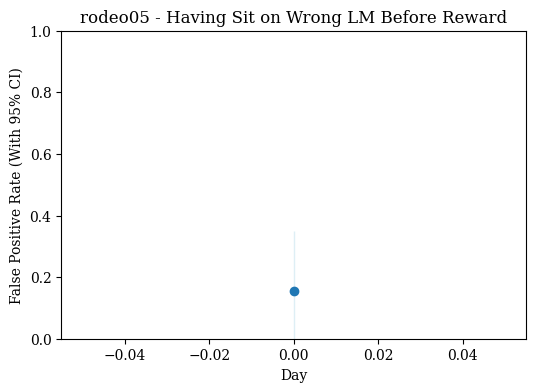

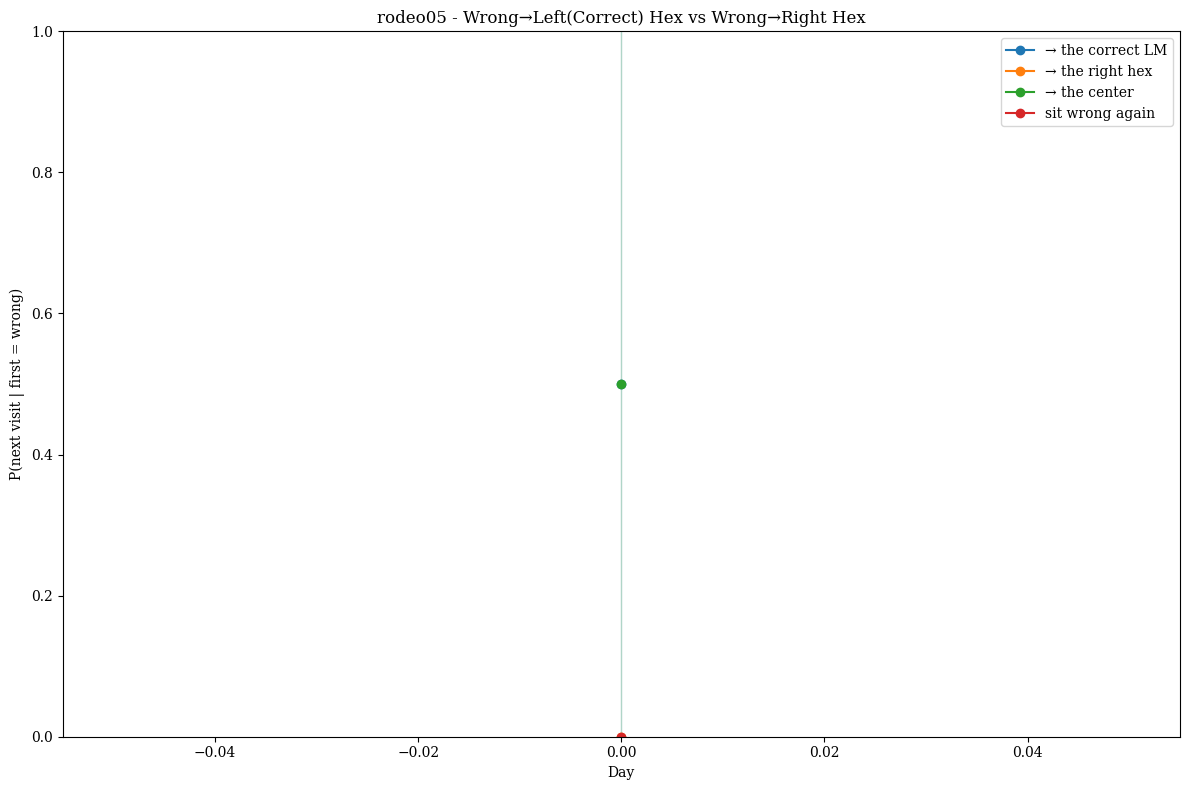

In [62]:
# ----- Config -----
from scipy.stats import norm
   
#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211
#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158
#hex_zone_r = 0.275
#hex_zone_r = 0.12
hex_zone_r = (0.55/3)/np.sqrt(3)+ 0.01 

task_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]

n_hex = len(task_space)
n_days = len(days)

# 95% CI z-score
z95 = norm.ppf(0.975)

fpr_list = []
fpr_n = []   # valid fpr trial num per day
next_n = []  # next hold num per day
prob21_list = []
prob23_list = []
prob20_list = []
prob22_list = []

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()
    tree = tree_by_day[day]
    
    trials = []
    next_after2 = []
    
    for ti, trial_df in d.groupby("trial"):

        t_df = trial_df[trial_df["task_state"]=="outbound"]
        #t_df = trial_df[trial_df["task_state"]=="inbound"]

        xpt = t_df["x"]
        ypt = t_df["y"]

        t_dt = t_df.index
        dt_f = t_dt.to_series().diff().dt.total_seconds().to_numpy()
        dt_f[0] = np.median(dt_f[1:]) 

        LM_holding_time = t_df["lm_ht"][0] / 1000
        center_holding_time = t_df["center_ht"][0] / 1000
        r = t_df["r"]

        #hold_list = find_hold_list(xpt, ypt, tree, hex_zone_r, LM_holding_time, dt_f)
        #print(hold_list)

        events_list = find_event_list(xpt, ypt, tree, r_small = hex_zone_r, r_large = 0.275, 
                                 ht = LM_holding_time, ht_center = center_holding_time, dt = dt_f)
        #sit_list = [item for item in events_list if list(item.values())[0] == "sit"]
        #print(sit_list)

        last = events_list[-1] if len(events_list) > 0 else None
        before_last = events_list[-2] if len(events_list) > 1 else None


        for j in range(len(events_list)-1):
            if events_list[j] == {2:"sit"}:
                # the first event not {2:'visit'}
                for k in range(j+1, len(events_list)):
                    if events_list[k] != {2:"visit"}:
                        next_after2.append(events_list[k])
                        break

        #is_fp = (last_h == 1) and (before_last_h == 2)

        #if last_h is None or (last_h is not None and 2 in hold_list[:-3] and before_last_h != 2):
        #    print(hold_list)
        if last != {1:"sit"}:
            continue
        else:
            is_fp = {2:"sit"} in events_list
            trials.append({
                'last': last,
                'before last': before_last,
                'is_fp': is_fp
            })

    if len(next_after2) > 0:
        p21 = [list(n.keys())[0] for n in next_after2].count(1) / len(next_after2)
        p23 = [list(n.keys())[0] for n in next_after2].count(3) / len(next_after2)
        p20 = [list(n.keys())[0] for n in next_after2].count(0) / len(next_after2)
        p22 = [list(n.keys())[0] for n in next_after2].count(2) / len(next_after2)
    else:
        p21 = 0.0
        p23 = 0.0
        p20 = 0.0
        p22 = 0.0

    next_n.append(len(next_after2))

    prob21_list.append(p21)
    prob23_list.append(p23)
    prob20_list.append(p20)
    prob22_list.append(p22)
             

    df_t = pd.DataFrame(trials)
    # FPR
    fpr = df_t['is_fp'].mean()
    fpr_list.append(fpr)

    fpr_n.append(len(df_t))

    '''
    fp_only = df_t[df_t['is_fp']]
    trans_counts = Counter(fp_only['before last'])
    total_fp = len(fp_only)
    trans_probs = {h: cnt/total_fp for h,cnt in trans_counts.items()}
    '''

fpr_list = np.array(fpr_list)
fpr_n = np.array(fpr_n)
fpr_se = np.sqrt(fpr_list * (1 - fpr_list) / fpr_n)
fpr_ci = z95 * fpr_se

next_n = np.array(next_n)
prob21_list = np.array(prob21_list)
prob23_list = np.array(prob23_list)
prob20_list = np.array(prob20_list)
prob22_list = np.array(prob22_list)
next_se21 = np.sqrt(prob21_list*(1-prob21_list)/next_n)
next_se23 = np.sqrt(prob23_list*(1-prob23_list)/next_n)
next_se20 = np.sqrt(prob20_list*(1-prob20_list)/next_n)
next_se22 = np.sqrt(prob22_list*(1-prob22_list)/next_n)
next_ci21 = z95 * next_se21
next_ci23 = z95 * next_se23
next_ci20 = z95 * next_se20
next_ci22 = z95 * next_se22


plt.figure(figsize=(6,4))

plt.fill_between(days,
                 fpr_list - fpr_ci,
                 fpr_list + fpr_ci,
                 color='lightblue', alpha=0.4,
                 label='95% CI')

plt.plot(days, fpr_list, marker = 'o')
plt.ylim([0, 1])
plt.title(f"{mouse_id} - Having Sit on Wrong LM Before Reward")
plt.ylabel("False Positive Rate (With 95% CI)")
plt.xlabel("Day")



plt.figure(figsize=(12,8))
plt.hlines(0.25, xmin=days[0], xmax=days[-1], color="k", linestyle="--", alpha=0.7)

# Plot with fill_between for CI, matching line color
line1, = plt.plot(days, prob21_list, marker='o', label='→ the correct LM', color='#1f77b4')
plt.fill_between(days, prob21_list - next_ci21, prob21_list + next_ci21, color=line1.get_color(), alpha=0.2)

line2, = plt.plot(days, prob23_list, marker='o', label='→ the right hex', color='#ff7f0e')
plt.fill_between(days, prob23_list - next_ci23, prob23_list + next_ci23, color=line2.get_color(), alpha=0.2)

line3, = plt.plot(days, prob20_list, marker='o', label='→ the center', color='#2ca02c')
plt.fill_between(days, prob20_list - next_ci20, prob20_list + next_ci20, color=line3.get_color(), alpha=0.2)

line4, = plt.plot(days, prob22_list, marker='o', label='sit wrong again', color='#d62728')
plt.fill_between(days, prob22_list - next_ci22, prob22_list + next_ci22, color=line4.get_color(), alpha=0.2)

plt.ylim([0, 1])
plt.ylabel("P(next visit | first = wrong)")
plt.xlabel("Day")
plt.legend()
plt.title(f"{mouse_id} - Wrong→Left(Correct) Hex vs Wrong→Right Hex")
plt.tight_layout()
plt.show()



c:\Users\sunr\AppData\Local\miniconda3\envs\JVLabEnv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


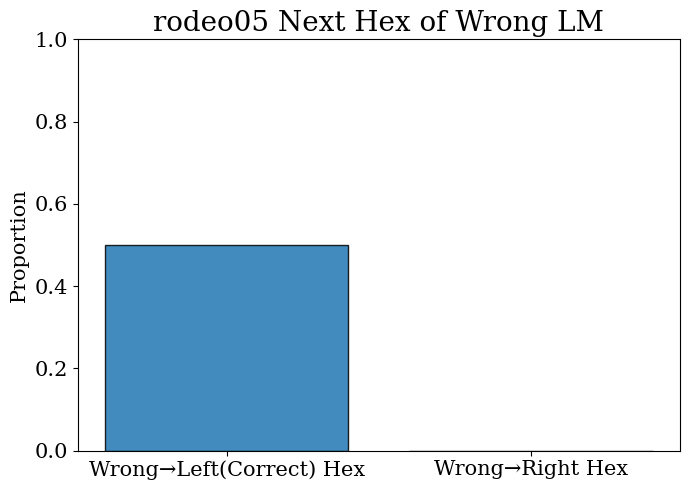

In [60]:
mean = [np.nanmean(prob21_list, axis=0), np.nanmean(prob23_list, axis=0)]
sem = [np.nanstd(prob21_list, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(prob21_list), axis=0)),
       np.nanstd(prob23_list, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(prob23_list), axis=0))]


_, p = ttest_ind(prob21_list, prob23_list, equal_var=False)


fig, ax = plt.subplots(figsize=(7,5))
x_pos = np.arange(2)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.bar(x_pos, mean, yerr=sem, capsize=5, edgecolor='k', color=[default_colors[0], default_colors[1]], alpha = 0.85)

def sig_label(p):
    if p < 0.001: return '***'
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return 'ns'

y_max = max(mean + sem)
h_step = 0.03


y = np.max(mean) + np.max(sem) + h_step
ax.text(0.5, y, sig_label(p), ha='center', va='bottom', fontsize=15)

ax.set_xticks(x_pos)
ax.set_ylim([0,1])
ax.set_xticklabels(["Wrong→Left(Correct) Hex", "Wrong→Right Hex"], ha='center', fontsize = 15)
ax.set_ylabel('Proportion', fontsize = 15)
ax.set_title(f'{mouse_id} Next Hex of Wrong LM', fontsize = 20)
ax.tick_params(axis='y', labelsize=15) 
plt.tight_layout()
#fig.savefig(f"{mouse_id}fig/hist/First_Visit_vs_baseline.png", dpi=150, bbox_inches="tight")
plt.show()
#plt.close(fig)


C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\3634517335.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  LM_holding_time = t_df["lm_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\3634517335.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center_holding_time = t_df["center_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\2139655089.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ids = tr

[{6: 'visit'}, {1: 'visit'}, {6: 'visit'}, {5: 'sit'}, {4: 'visit'}, {3: 'visit'}, {4: 'visit'}, {5: 'visit'}, {6: 'visit'}, {1: 'visit'}, {2: 'visit'}, {1: 'visit'}, {6: 'visit'}, {5: 'sit'}, {4: 'sit'}, {3: 'sit'}, {2: 'visit'}, {1: 'visit'}, {6: 'visit'}, {5: 'visit'}, {4: 'visit'}, {0: 'sit'}, {1: 'visit'}, {2: 'visit'}, {3: 'visit'}, {4: 'visit'}, {5: 'visit'}, {6: 'visit'}, {1: 'visit'}, {2: 'visit'}, {3: 'visit'}, {4: 'visit'}, {5: 'visit'}, {6: 'visit'}, {1: 'visit'}, {6: 'visit'}, {5: 'visit'}, {4: 'visit'}, {3: 'visit'}, {2: 'visit'}, {1: 'sit'}]
[{0: 'sit'}, {6: 'visit'}, {1: 'visit'}, {2: 'visit'}, {3: 'visit'}, {4: 'visit'}, {3: 'visit'}, {2: 'visit'}, {1: 'visit'}, {6: 'visit'}, {5: 'visit'}, {4: 'visit'}, {3: 'visit'}, {4: 'visit'}, {5: 'visit'}, {6: 'visit'}, {1: 'visit'}, {2: 'sit'}, {1: 'sit'}]
[{0: 'sit'}, {3: 'visit'}, {0: 'visit'}, {5: 'visit'}, {4: 'visit'}, {5: 'visit'}, {6: 'visit'}, {1: 'visit'}, {2: 'visit'}, {3: 'sit'}, {2: 'visit'}, {1: 'sit'}]
[{0: 'sit'}, 

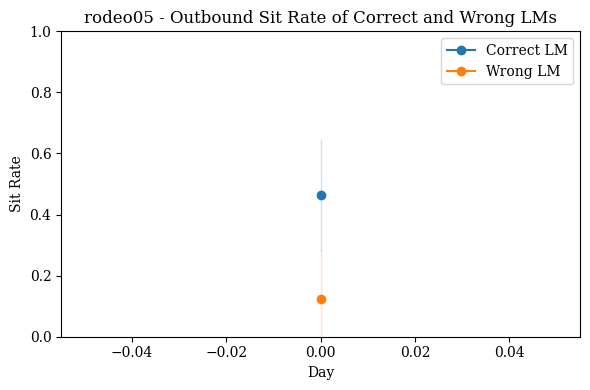

In [63]:
# ----- Config -----
   
#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211
#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158
#hex_zone_r = 0.275
#hex_zone_r = 0.12
hex_zone_r = (0.55/3)/np.sqrt(3)+0.01

task_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]

n_hex = len(task_space)
n_days = len(days)

vs1_list = []
vs2_list = []

vs_n1_list = []  
vs_n2_list = []  

z95 = norm.ppf(0.975)  

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()
    tree = tree_by_day[day]
    
    trials = []
    next_after2 = []
    all_list = []
    sit_list = []
    for ti, trial_df in d.groupby("trial"):

        t_df = trial_df[trial_df["task_state"]=="outbound"]
        #t_df = trial_df[trial_df["task_state"]=="inbound"]

        xpt = t_df["x"]
        ypt = t_df["y"]

        t_dt = t_df.index
        dt_f = t_dt.to_series().diff().dt.total_seconds().to_numpy()
        dt_f[0] = np.median(dt_f[1:]) 

        LM_holding_time = t_df["lm_ht"][0] / 1000
        center_holding_time = t_df["center_ht"][0] / 1000
        r = t_df["r"]

        #hold_list = find_hold_list(xpt, ypt, tree, hex_zone_r, LM_holding_time, dt_f)
        #print(hold_list)

        events_list = find_event_list(xpt, ypt, tree, r_small = hex_zone_r, r_large = 0.275, 
                                 ht = LM_holding_time, ht_center = center_holding_time, dt = dt_f)
        #sit_list = [item for item in events_list if list(item.values())[0] == "sit"]
        #print(sit_list)

        print(events_list)

        all = [item for item in events_list if list(item.keys())[0] in [1,2]]
        sit = [item for item in all if list(item.values())[0] == "sit"]

        all_list += all
        sit_list += sit

    all1 = [list(n.keys())[0] for n in all_list].count(1)
    all2 = [list(n.keys())[0] for n in all_list].count(2)

    if all1 > 0 and all2 > 0:
        vs1 = [list(n.keys())[0] for n in sit_list].count(1) / all1
        vs2 = [list(n.keys())[0] for n in sit_list].count(2) / all2
    else:
        vs1 = 0.0
        vs2 = 0.0


    vs_n1_list.append(all1)
    vs_n2_list.append(all2)

    vs1_list.append(vs1)
    vs2_list.append(vs2)     

vs1_list = np.array(vs1_list)
vs2_list = np.array(vs2_list)
vs_n1_list = np.array(vs_n1_list)
vs_n2_list = np.array(vs_n2_list)
vs1_se = np.sqrt(vs1_list * (1 - vs1_list) / vs_n1_list)
vs2_se = np.sqrt(vs2_list * (1 - vs2_list) / vs_n2_list)
vs1_ci = z95 * vs1_se
vs2_ci = z95 * vs2_se   

plt.figure(figsize=(6,4))
line1, = plt.plot(days, vs1_list, marker='o', label='Correct LM')
plt.fill_between(days, vs1_list - vs1_ci, vs1_list + vs1_ci, color=line1.get_color(), alpha=0.2)
line2, = plt.plot(days, vs2_list, marker='o', label='Wrong LM')
plt.fill_between(days, vs2_list - vs2_ci, vs2_list + vs2_ci, color=line2.get_color(), alpha=0.2)

plt.ylim(0, 1)
plt.ylabel("Sit Rate")
plt.xlabel("Day")
plt.legend()
plt.title(f"{mouse_id} - Outbound Sit Rate of Correct and Wrong LMs")
plt.tight_layout()
plt.show()

#### inbound

C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\358776758.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  LM_holding_time = t_df["lm_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\358776758.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center_holding_time = t_df["center_ht"][0] / 1000
C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\2139655089.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ids = tree

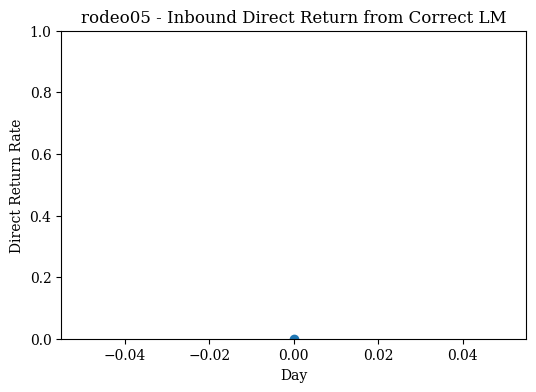

In [66]:
# ----- Config -----

#hex_zone_r = (0.55*2/3)/np.sqrt(3)  #0.211
#hex_zone_r = (0.55/2)/np.sqrt(3)  #0.158
#hex_zone_r = 0.275
#hex_zone_r = 0.12
hex_zone_r = (0.55/3)/np.sqrt(3)+0.01

task_space = ["Correct(UP)","Wrong(NE)","SE","S","SW","NW","Previous"]

n_hex = len(task_space)
n_days = len(days)

drr_list = []
drr_n = [] 

z95 = norm.ppf(0.975)  

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()
    tree = tree_by_day[day]
    
    trials = []
    for ti, trial_df in d.groupby("trial"):

        t_df = trial_df[trial_df["task_state"]=="inbound"]

        xpt = t_df["x"]
        ypt = t_df["y"]

        t_dt = t_df.index
        dt_f = t_dt.to_series().diff().dt.total_seconds().to_numpy()
        dt_f[0] = np.median(dt_f[1:]) 

        LM_holding_time = t_df["lm_ht"][0] / 1000
        center_holding_time = t_df["center_ht"][0] / 1000
        r = t_df["r"]

        #hold_list = find_hold_list(xpt, ypt, tree, hex_zone_r, LM_holding_time, dt_f)
        #print(hold_list)

        events_list = find_event_list(xpt, ypt, tree, r_small = hex_zone_r, r_large = 0.275, 
                                 ht = LM_holding_time, ht_center = center_holding_time, dt = dt_f)
        #sit_list = [item for item in events_list if list(item.values())[0] == "sit"]
        #print(sit_list)

        last = events_list[-1] if len(events_list) > 0 else None
        first = events_list[0] if len(events_list) > 0 else None

        #is_fp = (last_h == 1) and (before_last_h == 2)
        #is_direct_return = (last == {0:"sit"}) and (not {2:"sit"} in events_list) 

        event_ids = [list(e.keys())[0] for e in events_list]\

        if (last != {0:"sit"}) or (event_ids[0] != 1):
            continue
        else:
            #is_direct_return = set(event_ids) == {0, 1}
            is_direct_return = len(events_list) < 5 and {2:"sit"} not in events_list
            trials.append({
                'last': last,
                'is_direct_return': is_direct_return
            })
             

    df_t = pd.DataFrame(trials)
    # FPR
    drr = df_t['is_direct_return'].mean()
    drr_list.append(drr)
    drr_n.append(len(df_t))

    '''
    dr_only = df_t[df_t['is_direct_return']]
    trans_counts = Counter(dr_only['before last'])
    total_dr = len(dr_only)
    trans_probs = {h: cnt/total_dr for h,cnt in trans_counts.items()}
    '''

drr_list = np.array(drr_list)
drr_n = np.array(drr_n)
drr_se = np.sqrt(drr_list * (1 - drr_list) / drr_n)
drr_ci = z95 * drr_se   

plt.figure(figsize=(6,4))
plt.plot(days, drr_list, marker = 'o')
plt.fill_between(days,
                 drr_list - drr_ci,
                 drr_list + drr_ci,
                 color='lightblue', alpha=0.4,
                 label='95% CI')
plt.ylim([0, 1])
plt.title(f"{mouse_id} - Inbound Direct Return from Correct LM")
plt.ylabel("Direct Return Rate")
plt.xlabel("Day")
plt.show()

## Speed

Currently use guass filter to smooth, and bin speed into 1s choosing the mean of it as one data point (also, remove >5m/s speed which might be big jumps)

### Colored by trial

C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\995872018.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  borders = pd.date_range(start=t0,


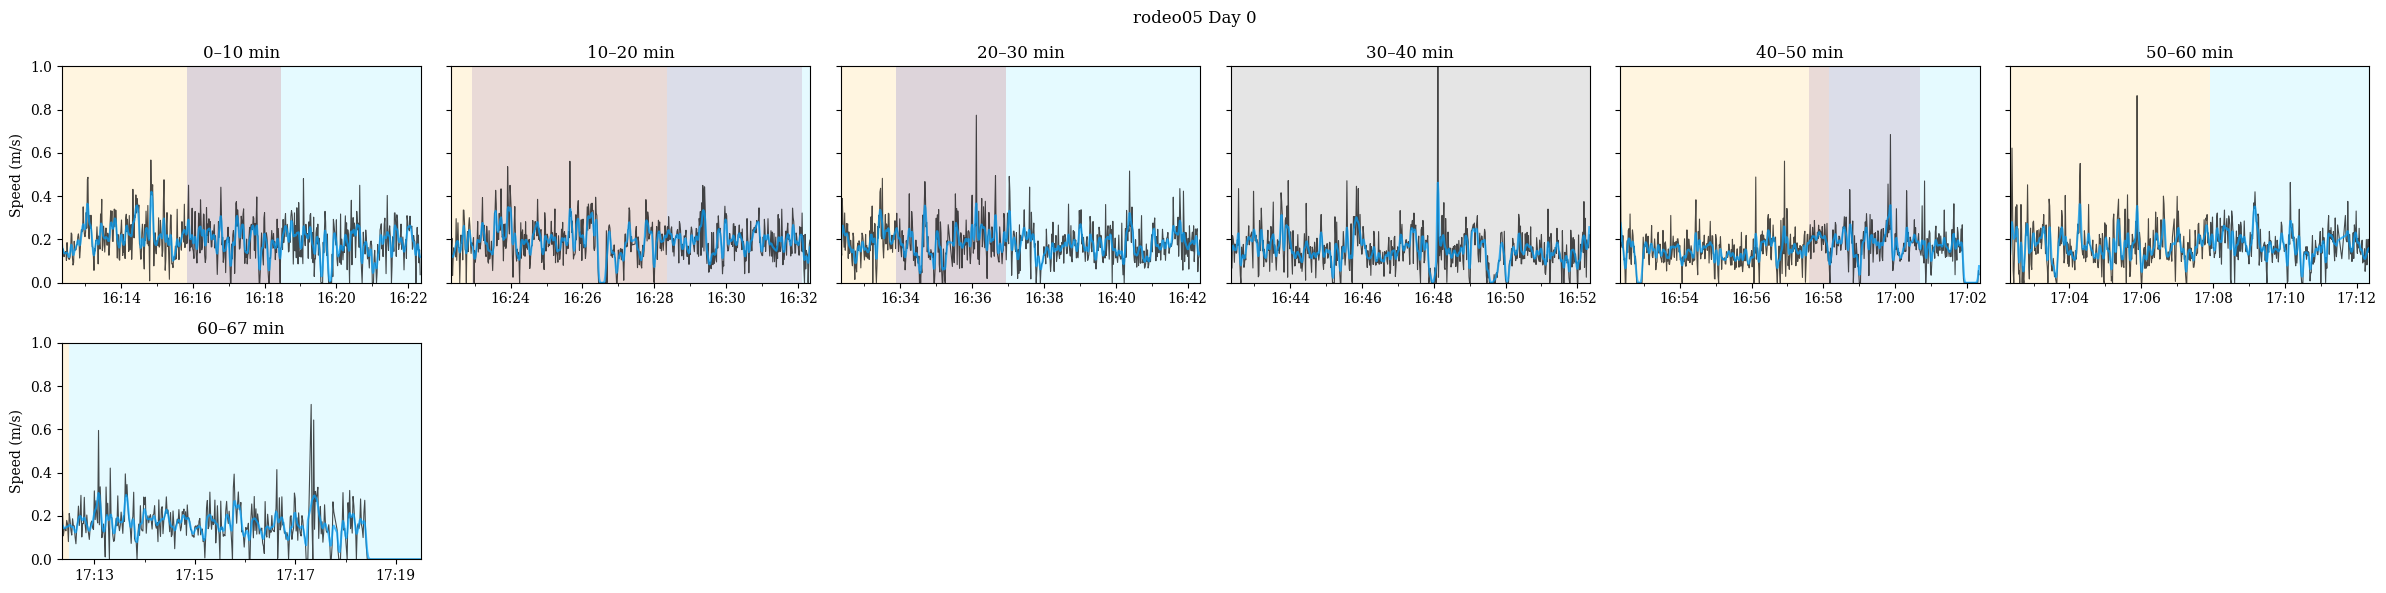

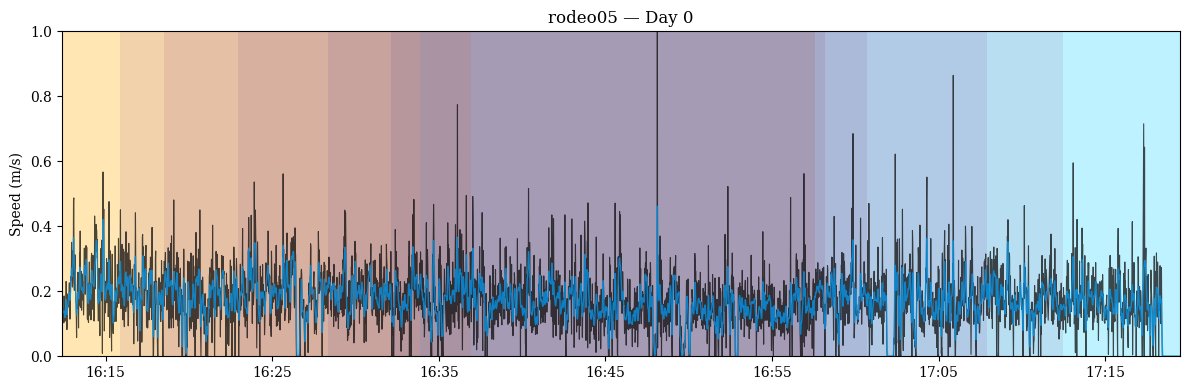

In [76]:
#os.makedirs(f"{mouse_id}fig/speed/", exist_ok=True)

chunk_size = 10 

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()

    sp_smoothed = sp_smoothed_list[di]
    sp1s = sp1s_list[di]

    t_dt = d.index.tz_localize(None)

    d['prev_trial'] = d['trial'].shift(-1).fillna(0).astype(int)
    trial_ends = np.where(d['trial'] != d['prev_trial'])[0]  # find trial ends
    trial_starts = np.concatenate(([0], trial_ends[:-1] + 1))  # trial starts

    starts_dt = t_dt[trial_starts]
    ends_dt = t_dt[trial_ends]


    t0 = t_dt[0]  # first non-NaN timestamp
    tmax = t_dt[-1]
    mins = (tmax - t0).total_seconds()/60
    borders = pd.date_range(start=t0,
                            periods=int(np.ceil(mins/chunk_size))+2,
                            freq=f"{chunk_size}T")
    borders = borders[borders<=tmax]  

    n_chunks = len(borders)
    ncols = min(6, n_chunks)
    nrows = int(np.ceil(n_chunks/ncols))

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4*ncols, 3*nrows),
                             sharey=True)
    # Ensure axes is always a 1D numpy array
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for ci in range(n_chunks):
        ax = axes[ci]
        t_start, t_end = borders[ci], borders[ci+1] if ci < n_chunks-1 else tmax

        trials = [(st, en) for st,en in zip(starts_dt, ends_dt)
                  if (st < t_end and en > t_start)]
        M = len(trials)
        cmap = plt.get_cmap("managua")  
        for ti,(st,en) in enumerate(trials):
            color = cmap(ti/(M-1)) if M>1 else "grey"
            ax.axvspan(max(st, t_start), min(en, t_end),
                       facecolor=color, alpha=0.2)

        mask_chunk = (sp1s.index.tz_localize(None) >= t_start) & (sp1s.index.tz_localize(None) < t_end)
        ax.plot(sp1s.index.tz_localize(None)[mask_chunk],
                sp1s[mask_chunk],
                color="k", lw=0.8, alpha=0.7)
        
        mask_chunk2 = (sp_smoothed.index.tz_localize(None) >= t_start) & (sp_smoothed.index.tz_localize(None) < t_end)
        ax.plot(sp_smoothed.index.tz_localize(None)[mask_chunk2],
                sp_smoothed[mask_chunk2],
                color="#00A2FF", lw=1.5, alpha=0.7)

        ax.set_xlim(t_start, t_end)
        ax.set_ylim(0, 1)
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
        ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
        ax.xaxis.set_minor_locator(mdates.MinuteLocator())
        if ci % ncols == 0:
            ax.set_ylabel("Speed (m/s)")
        ax.set_title(f"{(t_start-t0).total_seconds()/60:.0f}–"
                     f"{(t_end-t0).total_seconds()/60:.0f} min")

    for j in range(n_chunks, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{mouse_id} Day {day}")
    plt.tight_layout()
    #fig.savefig(f"{mouse_id}fig/speed/day_{day}_speed.png", dpi=150, bbox_inches="tight")
    plt.show()
    #plt.close(fig)


    fig2, ax2 = plt.subplots(figsize=(12,4))

    trials = [(st, en) for st,en in zip(starts_dt, ends_dt)]
    M = len(trials)
    cmap = plt.get_cmap("managua")  
    for ti,(st,en) in enumerate(trials):
        color = cmap(ti/(M-1)) if M>1 else "grey"
        ax2.axvspan(st, en, facecolor=color, alpha=0.5)

    ax2.plot(sp1s.index.tz_localize(None), sp1s, color="k", lw=0.8, alpha=0.7)
    ax2.plot(sp_smoothed.index.tz_localize(None), sp_smoothed, color="#00A2FF", lw=1, alpha=0.7)

    ax2.set_xlim(t0, tmax)
    ax2.set_ylim(0, 1)
    ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    ax2.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax2.set_ylabel("Speed (m/s)")
    ax2.set_title(f"{mouse_id} — Day {day}")
    plt.tight_layout()
    #fig2.savefig(f"{mouse_id}fig/speed/day_{day}_speed.png", dpi=150, bbox_inches="tight")
    plt.show()
    #plt.close(fig2)

### Colored by task state

C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\4209895390.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  borders = pd.date_range(start=t0,


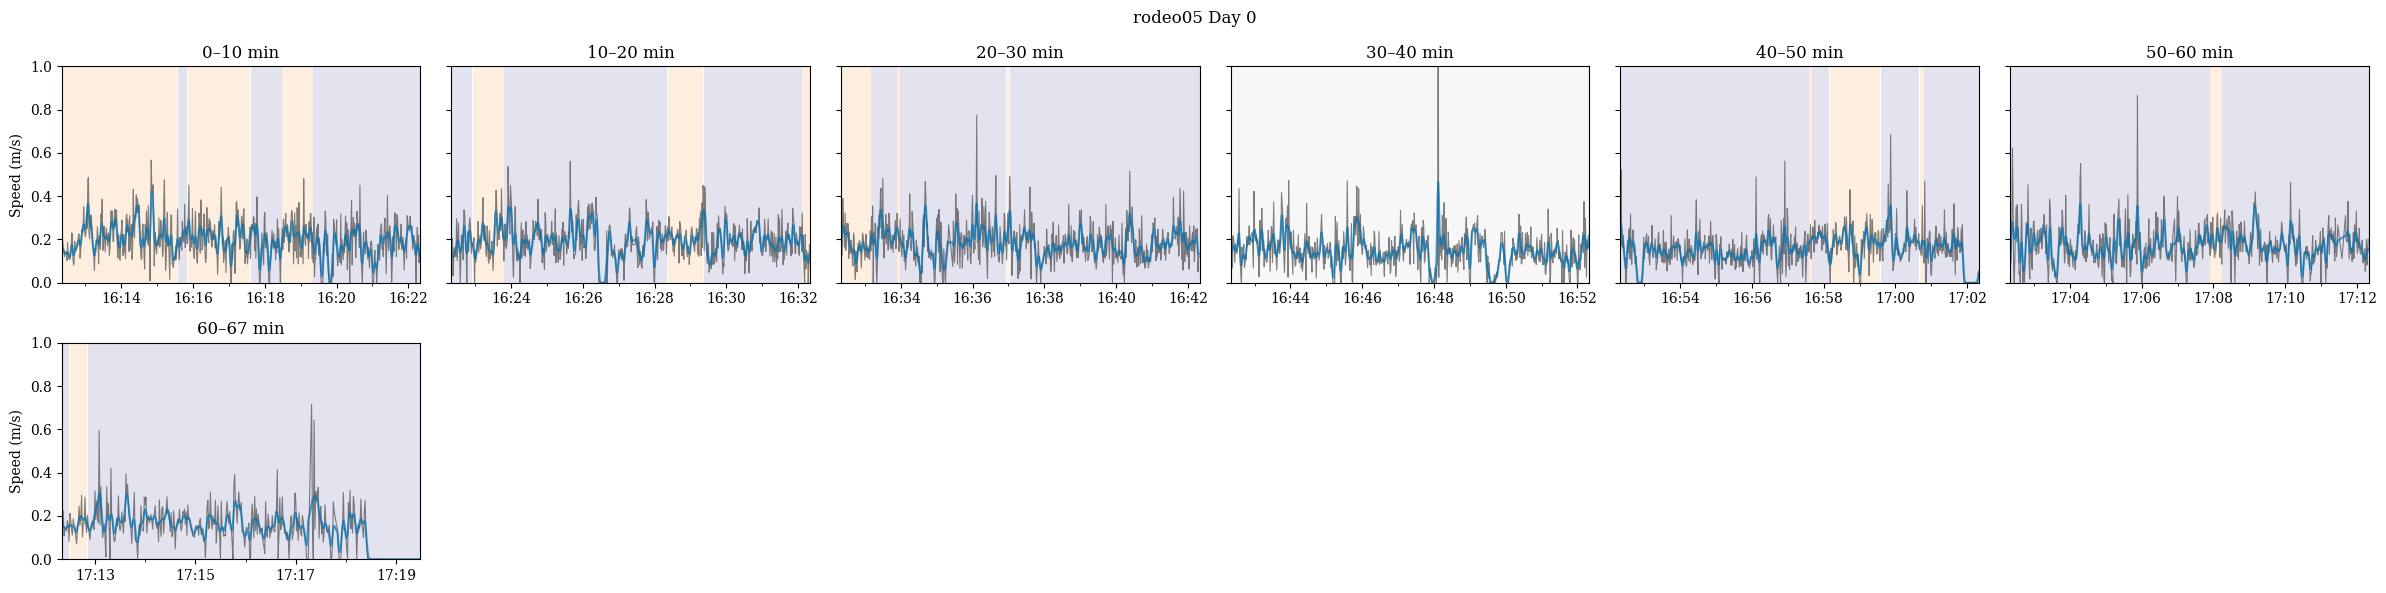

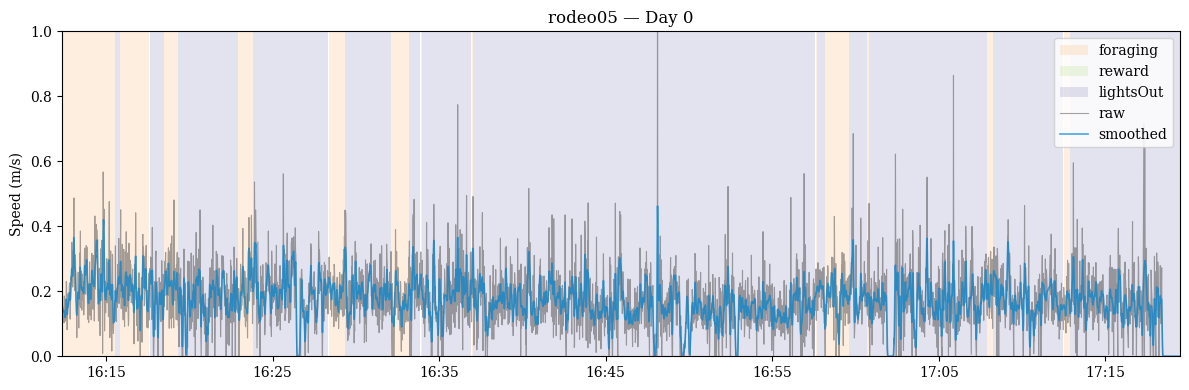

In [85]:
#os.makedirs(f"{mouse_id}fig/speed/", exist_ok=True)

'''
state_colors = {
    "foraging": "#d1e5f0",
    "reward":   "#92c5de",
    "lightsOut":"#f4a582"
}
'''

state_colors = {
    'foraging':   '#FDAE61',  
    'reward':    '#A6D96A',   
    'lightsOut': '#7570B3',   
}

chunk_size = 10   

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()
    
    sp1s_smoothed = sp_smoothed_list[di]
    sp1s = sp1s_list[di]

    t_dt = d.index.tz_localize(None)

    d['prev_trial'] = d['trial'].shift(-1).fillna(0).astype(int)
    trial_ends = np.where(d['trial'] != d['prev_trial'])[0]  # find trial ends
    trial_starts = np.concatenate(([0], trial_ends[:-1] + 1))  # trial starts

    starts_dt = t_dt[trial_starts]
    ends_dt = t_dt[trial_ends]

    t0 = sp1s.index.tz_localize(None)[0]  # first non-NaN timestamp
    tmax = sp1s.index.tz_localize(None)[-1]
    mins = (tmax - t0).total_seconds()/60

    # A Series of states aligned to t_dt
    state_ser = pd.Series(
        d['state'].values,
        index=t_dt
    )
    state_ser = state_ser.reindex(sp1s.index.tz_localize(None), method='ffill')

    # shade by state
    runs = (state_ser != state_ser.shift()).cumsum()
    run_groups = state_ser.groupby(runs)

    borders = pd.date_range(start=t0,
                            periods=int(np.ceil(mins/chunk_size))+2,
                            freq=f"{chunk_size}T")
    borders = borders[borders<=tmax]  

    n_chunks = len(borders)
    ncols = min(6, n_chunks)
    nrows = int(np.ceil(n_chunks/ncols))

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4*ncols, 3*nrows),
                             sharey=True)
    # Ensure axes is always a 1D numpy array
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for ci in range(n_chunks):
        ax = axes[ci]
        t_start, t_end = borders[ci], borders[ci+1] if ci < n_chunks-1 else tmax

        # Determine if there is at least one trial in this chunk
        trials_in_chunk = [
            (st, en) for st, en in zip(starts_dt, ends_dt)
            if (st < t_end and en > t_start)
        ]
        if len(trials_in_chunk) <= 1:
            ax.axvspan(t_start, t_end, facecolor='#d9d9d9', alpha=0.2)
        else:
            for run_id, grp in run_groups:
                st, en = grp.index[0], grp.index[-1]
                if en < t_start or st > t_end:
                    continue
                ax.axvspan(max(st, t_start), min(en, t_end),
                    facecolor=state_colors.get(grp.iloc[0], "#ccc"), alpha=0.2)

        mask_chunk = (sp1s.index.tz_localize(None) >= t_start) & (sp1s.index.tz_localize(None) < t_end)
        ax.plot(sp1s.index.tz_localize(None)[mask_chunk],
                sp1s[mask_chunk],
                color='#4A4A4A', lw=0.8, alpha=0.7)
        ax.plot(sp1s_smoothed.index.tz_localize(None)[mask_chunk],
                sp1s_smoothed[mask_chunk],
                color='#0072B2', lw=1.5, alpha=0.7)

        ax.set_xlim(t_start, t_end)
        ax.set_ylim(0, 1)  
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
        ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
        ax.xaxis.set_minor_locator(mdates.MinuteLocator())
        if ci % ncols == 0:
            ax.set_ylabel("Speed (m/s)")
        ax.set_title(f"{(t_start-t0).total_seconds()/60:.0f}–"
                     f"{(t_end-t0).total_seconds()/60:.0f} min")

    for j in range(n_chunks, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{mouse_id} Day {day}")
    plt.tight_layout()
    #fig.savefig(f"{mouse_id}fig/speed/day_{day}_speed.png", dpi=150, bbox_inches="tight")
    plt.show()
    #plt.close(fig)

    fig2, ax2 = plt.subplots(figsize=(12,4))

    for run_id, grp in state_ser.groupby(runs):
        st, en = grp.index.tz_localize(None)[0], grp.index.tz_localize(None)[-1]
        color = state_colors.get(grp.iloc[0], 'grey')
        ax2.axvspan(st, en, facecolor=color, alpha=0.2, edgecolor=None)

    ax2.plot(sp1s.index.tz_localize(None), sp1s, color="#4A4A4A", lw=0.8, alpha=0.5, label='raw')
    ax2.plot(sp1s_smoothed.index.tz_localize(None), sp1s_smoothed, color="#0084D0", lw=1.2, alpha=0.7, label='smoothed')

    ax2.set_xlim(sp1s.index.tz_localize(None)[0], sp1s.index.tz_localize(None)[-1])
    ax2.set_ylim(0, 1)
    ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    ax2.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax2.set_ylabel("Speed (m/s)")
    ax2.set_title(f"{mouse_id} — Day {day}")
    # Custom legend for background colors (state)
    legend_elements = [
        Patch(facecolor=state_colors['foraging'], edgecolor='none', alpha=0.2, label='foraging'),
        Patch(facecolor=state_colors['reward'], edgecolor='none', alpha=0.2, label='reward'),
        Patch(facecolor=state_colors['lightsOut'], edgecolor='none', alpha=0.2, label='lightsOut')
    ]
    ax2.legend(handles=legend_elements + ax2.get_lines(), loc='upper right')

    plt.tight_layout()
    plt.show()

### Speed pattern

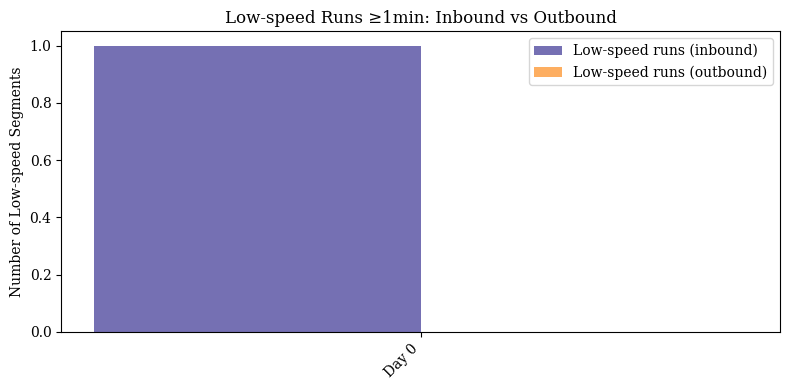

   day  low_speed_threshold_m_per_s
0    0                     0.136939


In [88]:
# define low-speed threshold per-day as the 50th percentile of smoothed speed
min_run_sec = 60
min_seg_sec = 30


inbound_count_list = []
outbound_count_list = []

low_thresh_list = []
for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()
    
    sp1s_smoothed = sp_smoothed_list[di].tz_localize(None)
    sp1s = sp1s_list[di].tz_localize(None)

    t_dt = d.index.tz_localize(None)
    
    state_ser = pd.Series(d['state'].values, index=t_dt)
    state_ser = state_ser.reindex(sp1s_smoothed.index, method='ffill')
    
    # Threshold
    low_thresh = sp1s_smoothed.quantile(0.25)
    low_mask = sp1s_smoothed < low_thresh
    low_thresh_list.append(low_thresh)

    runs = (low_mask != low_mask.shift()).cumsum()

    segments = []
    for run_id, grp in low_mask.groupby(runs):
        if not grp.iloc[0]:
            continue
        start, end = grp.index[0], grp.index[-1]
        segments.append((start, end))

    long_segments = [(start, end) for (start, end) in segments if (end - start).total_seconds() >= min_seg_sec]
    # merge nearby segments
    merged_segments = []
    for seg in long_segments:
        if not merged_segments:
            merged_segments.append(seg)
        else:
            prev_start, prev_end = merged_segments[-1]
            curr_start, curr_end = seg
            gap = (curr_start - prev_end).total_seconds()
            if gap < 5:
                merged_segments[-1] = (prev_start, curr_end)
            else:
                merged_segments.append(seg)

    new_low_mask = pd.Series(False, index=low_mask.index)
    for start, end in merged_segments:
        new_low_mask[start:end] = True
    low_mask = new_low_mask

    inbound_runs = 0
    outbound_runs = 0

    for start, end in merged_segments:
        grp = low_mask.loc[start:end]
        if not grp.iloc[0]:
            continue  
        dur = (end - start).total_seconds()
        if dur < min_run_sec:
            continue
        # classify by majority state in this run
        states = state_ser.loc[start:end]
        inbound_prop = (states == 'lightsOut').mean()
        outbound_prop = (states.isin(['foraging', 'reward'])).mean()
        if inbound_prop > outbound_prop:
            inbound_runs += 1
        else:
            outbound_runs += 1

    inbound_count_list.append(inbound_runs)
    outbound_count_list.append(outbound_runs)

# 5) Plot per-day counts
x = np.arange(len(days))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width/2, inbound_count_list, width, label='Low-speed runs (inbound)', color='#7570B3')
ax.bar(x + width/2, outbound_count_list, width, label='Low-speed runs (outbound)', color='#FDAE61')

ax.set_xticks(x)
ax.set_xticklabels([f"Day {d}" for d in days], rotation=45, ha='right')
ax.set_ylabel("Number of Low-speed Segments")
ax.set_title("Low-speed Runs ≥1min: Inbound vs Outbound")
ax.legend()
plt.tight_layout()
plt.show()


thresh_df = pd.DataFrame({
    'day': days,
    'low_speed_threshold_m_per_s': low_thresh_list
})
print(thresh_df)


#### In different hex zones

## Traj All and by Trial

### Traj all

C:\Users\sunr\AppData\Local\Temp\ipykernel_7528\516267424.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(d["x"][sel], d["y"][sel], "-", lw=0.8, alpha=0.8, color=colors[ti])


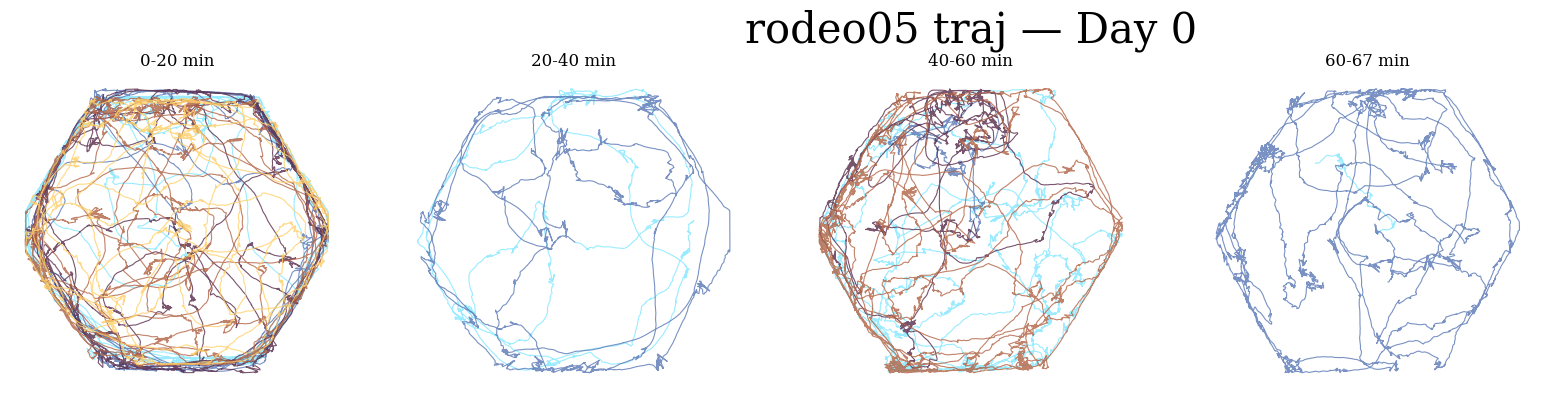

In [91]:
# ----- Config -----
chunk_size = 20
hex_round = (0.55/3)/np.sqrt(3)  # radius of hex
traj_cmap = plt.get_cmap("managua")  
center_color = "#e0a771"
up_color = "#4d8cc1"
other_color = "#c9cacb"
hist_colors = [center_color, up_color] + [other_color]*5

#os.makedirs(f"{mouse_id}fig/traj", exist_ok=True)

for di, day in enumerate(days):
    d = analysis_df[analysis_df["day"] == day].sort_index()

    t_dt = d.index

    d['prev_trial'] = d['trial'].shift(-1).fillna(0).astype(int)
    ends = np.where(d['trial'] != d['prev_trial'])[0]  # find trial ends
    starts = np.concatenate(([0], trial_ends[:-1] + 1))  # trial starts

    # 10m chunks
    t_min = (t_dt - t_dt[0]).total_seconds() / 60
    borders = np.unique(np.concatenate((
        np.arange(0, t_min.max()+chunk_size, chunk_size),[t_min.max()])))

    n_chunks = len(borders)-1
    ncols = min(6, n_chunks)
    nrows = int(np.ceil(n_chunks / ncols))

    # M = max number of trials in a chunk
    counts = [len([e for e in ends if borders[i] < t_min[e] <= borders[i+1]])
            for i in range(len(borders)-1)]
    M = max(counts) if counts else 0
    if M == 0:
        continue
    # each trial with fixed palette
    colors = [traj_cmap(i/(M-1)) for i in range(M)] if M > 1 else [traj_cmap(0.5)]
    colors = list(reversed(colors))  

    # ----- Trajectory plot -----
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    fig.suptitle("{} traj — Day {}".format(mouse_id,day), fontsize=30)

    used_idxs = []  
    for ci in range(n_chunks):
        start, end = borders[ci], borders[ci+1]
        ax = axes[ci]

        # which trials end in this chunk
        trials = [(sf,ef) for sf,ef in zip(starts, ends)
                  if (t_min[ef] > start) and (t_min[ef] <= end)]
        if not trials:
            continue

        for ti, (sf, ef) in enumerate(trials):
            idx = np.arange(sf, ef+1)
            sel = idx[(t_min[idx] > start) & (t_min[idx] <= end)]
            if sel.size:
                ax.plot(d["x"][sel], d["y"][sel], "-", lw=0.8, alpha=0.8, color=colors[ti])
        ax.set_title(f"{start:.0f}-{end:.0f} min")
        ax.set_aspect("equal")
        ax.axis("off")

        used_idxs.append(ci)

    # remove axes never used
    for i, ax in enumerate(axes):
        if i not in used_idxs:
            ax.remove()

    plt.tight_layout()
    plt.show()


    #fig.savefig(f"{mouse_id}fig/traj/day_{day}.png", dpi=300, bbox_inches="tight")

    #plt.close(fig)


### By trial: Outbound

C:\Users\sunr\AppData\Local\Temp\ipykernel_35396\1386562558.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center_holding_time = d["center_ht"][idx_out[-1]]/1000


0
1
2
3
4
5
6
7
8
9
10
11
12


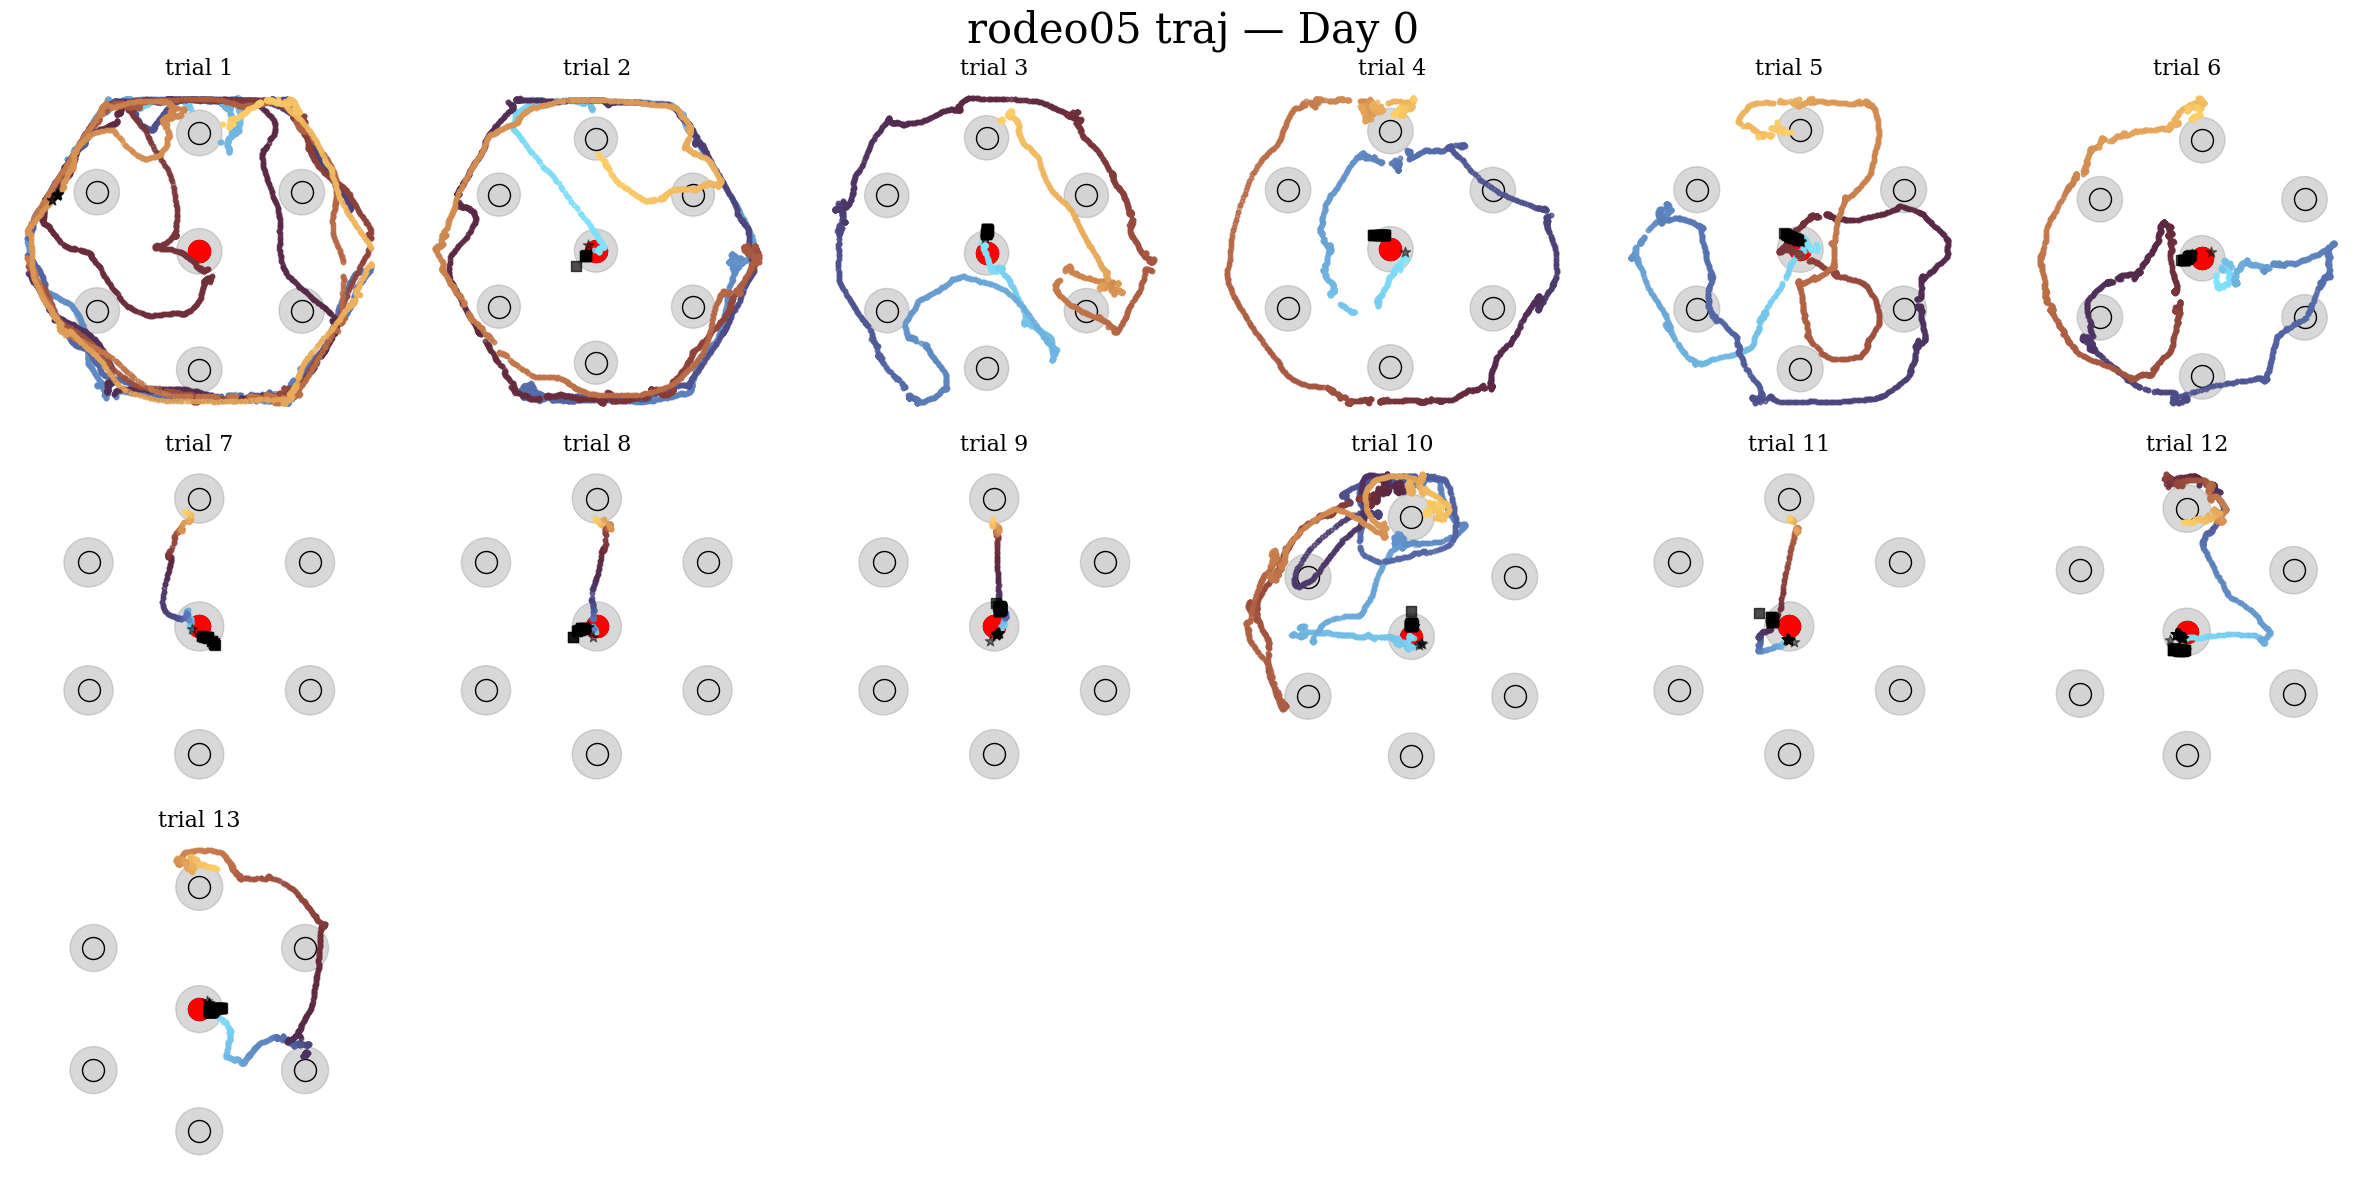

In [12]:
# ----- Config -----
jump_thresh = 0.5
ext_time_s = 1
hex_round = (0.55/3)/np.sqrt(3)  # radius of hex
#hex_round = (0.55/2)/np.sqrt(3)

traj_cmap = plt.get_cmap("managua")  

#os.makedirs(f"{mouse_id}fig/traj", exist_ok=True)


last_day = df["day"].max()
for di, day in enumerate(days):
    if day != last_day:
        continue
    d = df[df["day"] == day].sort_index()

    hex_centers = hex_centers_by_day[day]
    
    # timestamp & dt 
    t_dt = d.index.tz_convert("US/Eastern")
    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
    dt[0] = np.median(dt[1:])  
    median_dt = np.median(dt)
    speed_th = jump_thresh / median_dt 

    
    # traj clean: remove jumps
    xw = d["x"].to_numpy()
    yw = -d["y"].to_numpy()

    mask_edge = (d["x"].abs() > 0.8) | (d["y"].abs() > 0.75)

    dx = np.concatenate(([0], np.diff(xw)))
    dy = np.concatenate(([0], np.diff(yw)))
    speed = np.hypot(dx, dy) / dt
    jumps = speed > speed_th

    ext_frames = max(1, int(ext_time_s / median_dt))
    mask_jump = np.convolve(jumps.astype(int), np.ones(ext_frames, dtype=int), mode="same") > 0

    mask = mask_edge | mask_jump

    x_clean = xw.copy(); 
    x_clean[mask] = np.nan
    y_clean = yw.copy(); 
    y_clean[mask] = np.nan
    
    #x_clean = pd.Series(x_clean).interpolate().rolling(5,center=True).mean().to_numpy()
    #y_clean = pd.Series(y_clean).interpolate().rolling(5,center=True).mean().to_numpy()


    #x_clean = d['x'].to_numpy().copy()
    #y_clean = -d['y'].to_numpy().copy()  # y flip

    # trials: skip first three
    ends = np.where(d["sess_end"]==1)[0][1:]-1
    if len(ends) == 0:
        print(f"[Warning] No trials found for day {day}")
        continue
    starts = np.concatenate(([1], ends[:-1]+1))

    trial_idx = []
    color_lst = []
    ht_idx = []
    ht2_idx = []

    for sf, ef in zip(starts, ends):

        # which part of the trial to use
        idx_all = np.arange(sf-50, ef+1)
        last_trial = idx_all[:49]
        idx = idx_all[49:]
        mask_state = d["s"].isin(["foraging","reward"]).to_numpy()[idx]
        
        '''
        idx = np.arange(sf, ef+1)
        mask_state = d["s"].isin(["lightsOut"]).to_numpy()[idx]
        mask_state_ = np.where(d["s"].isin(["foraging","reward"]).to_numpy()[idx]==True)[0][-50:]
        last_trial = idx[mask_state_[:-1]]
        '''

        finite_mask = np.isfinite(x_clean[idx]) & np.isfinite(y_clean[idx])
        valid_mask = finite_mask & mask_state
        if not valid_mask.any():
            continue
        
        idx_in_prev = None
        if sf != 1:
            mask_state2 = d["s"].isin(["lightsOut"]).to_numpy()[last_trial]
            #mask_state2 = d["s"].isin(["foraging","reward"]).to_numpy()[last_trial]

            finite_mask2 = np.isfinite(x_clean[last_trial]) & np.isfinite(y_clean[last_trial])
            valid_mask2 = finite_mask2 & mask_state2
            if not valid_mask2.any():
                continue
            idx_in_prev = last_trial[valid_mask2]

        idx_out = np.concatenate([idx[0:1], idx[valid_mask]])
        #idx_out = np.concatenate([np.atleast_1d(idx[mask_state_[-1]]), idx[valid_mask]])
        center_holding_time = d["center_ht"][idx_out[-1]]/1000

        cumsum_dt = np.cumsum(dt[idx_out])
        # Make the first False after the last True also True in ht_mask
        ht_mask = cumsum_dt <= center_holding_time
        if np.any(ht_mask):
            last_true = np.where(ht_mask)[0].max() 
            if last_true + 1 < len(ht_mask):
                ht_mask[last_true + 1] = True
        else:
            # If no True, set the first one True
            ht_mask[0] = True
        idx_out_ht = idx_out[ht_mask]
        idx_out_other = idx_out[~ht_mask]

        if idx_in_prev is not None and idx_in_prev.any():
            cumsum_dt_rev = np.cumsum(dt[idx_in_prev][::-1])
            ht_mask_rev = cumsum_dt_rev <= center_holding_time
            if np.any(ht_mask_rev):
                last_true = np.where(ht_mask_rev)[0].max()
                if last_true + 1 < len(ht_mask_rev):
                    ht_mask_rev[last_true + 1] = True
            else:
                # If no True, set the first one True
                ht_mask_rev[0] = True
            idx_in_prev_ht = idx_in_prev[::-1][ht_mask_rev][::-1]  
        else:
            idx_in_prev_ht = []
        
        ht2_idx.append(idx_in_prev_ht)

        # M number of points in a trial (without ht)
        M = len(idx_out_other)
        if M == 0:
            continue
        colors = [traj_cmap(i/(M-1)) for i in range(M)] if M > 1 else [traj_cmap(0.5)]
        colors = list(reversed(colors))

        trial_idx.append(idx_out_other)
        color_lst.append(colors)
        ht_idx.append(idx_out_ht)

    # ----- Trajectory plot -----
    ncols = min(6, len(trial_idx)) 
    if ncols == 0:
        continue
    nrows = int(np.ceil(len(trial_idx) / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    fig.suptitle("{} traj — Day {}".format(mouse_id, day), fontsize=30)

    used_idxs = []  
    for ci in range(len(trial_idx)):
        colors = color_lst[ci]
        idx_this_trial_other = trial_idx[ci]
        idx_this_trial_ht = ht_idx[ci]
        ax = axes[ci]

        # all the hex centers
        for xc, yc in hex_centers:
            circle = Circle((xc, yc), radius=hex_round, color="gray", alpha=0.3, zorder=0)
            ax.add_patch(circle)

        ax.scatter(hex_centers[:,0], hex_centers[:,1],
                s=250, c="lightgray", edgecolor="k", label="Hex Centers")

        ax.scatter(0, 0,  # Maze center
                s=250, c="r", marker="o", label="Maze Center")

        for ti in range(len(idx_this_trial_other)):
            # Holding time scatters
            sel = idx_this_trial_other[ti]
            ax.scatter(x_clean[sel], y_clean[sel], s=10, color=colors[ti], alpha=0.5)

        if len(ht2_idx) > 0:
            idx_this_trial_prev_ht = ht2_idx[ci]
            if len(idx_this_trial_prev_ht) >= 1:
                for hti in range(len(idx_this_trial_prev_ht)):
                    sel_ht = idx_this_trial_prev_ht[hti]
                    ax.scatter(x_clean[sel_ht], y_clean[sel_ht], s=60, marker="s", color = "k", alpha = 0.7)

        if len(idx_this_trial_ht) >= 1:
            for hti in range(len(idx_this_trial_ht)):
                sel_ht = idx_this_trial_ht[hti]
                ax.scatter(x_clean[sel_ht], y_clean[sel_ht], s=60, marker="*", color = "k", alpha = 0.5)

        ax.set_title(f"trial {ci+1}", fontsize=16)
        ax.set_aspect("equal")
        ax.axis("off")

        used_idxs.append(ci)

        print(ci)

    # remove axes never used
    for i, ax in enumerate(axes):
        if i not in used_idxs:
            ax.remove()

    plt.tight_layout()
    plt.show()

    #fig.savefig(f"{mouse_id}fig/traj/perTrial_2LM_Outbound_day_{day}.png", dpi=300, bbox_inches="tight")
    #plt.close(fig)

### By trial: Inbound

C:\Users\sunr\AppData\Local\Temp\ipykernel_35396\3366387353.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  LM_holding_time = d['lm_ht'][idx_out[-1]]/1000


0
1
2
3
4
5
6
7
8
9
10
11
12


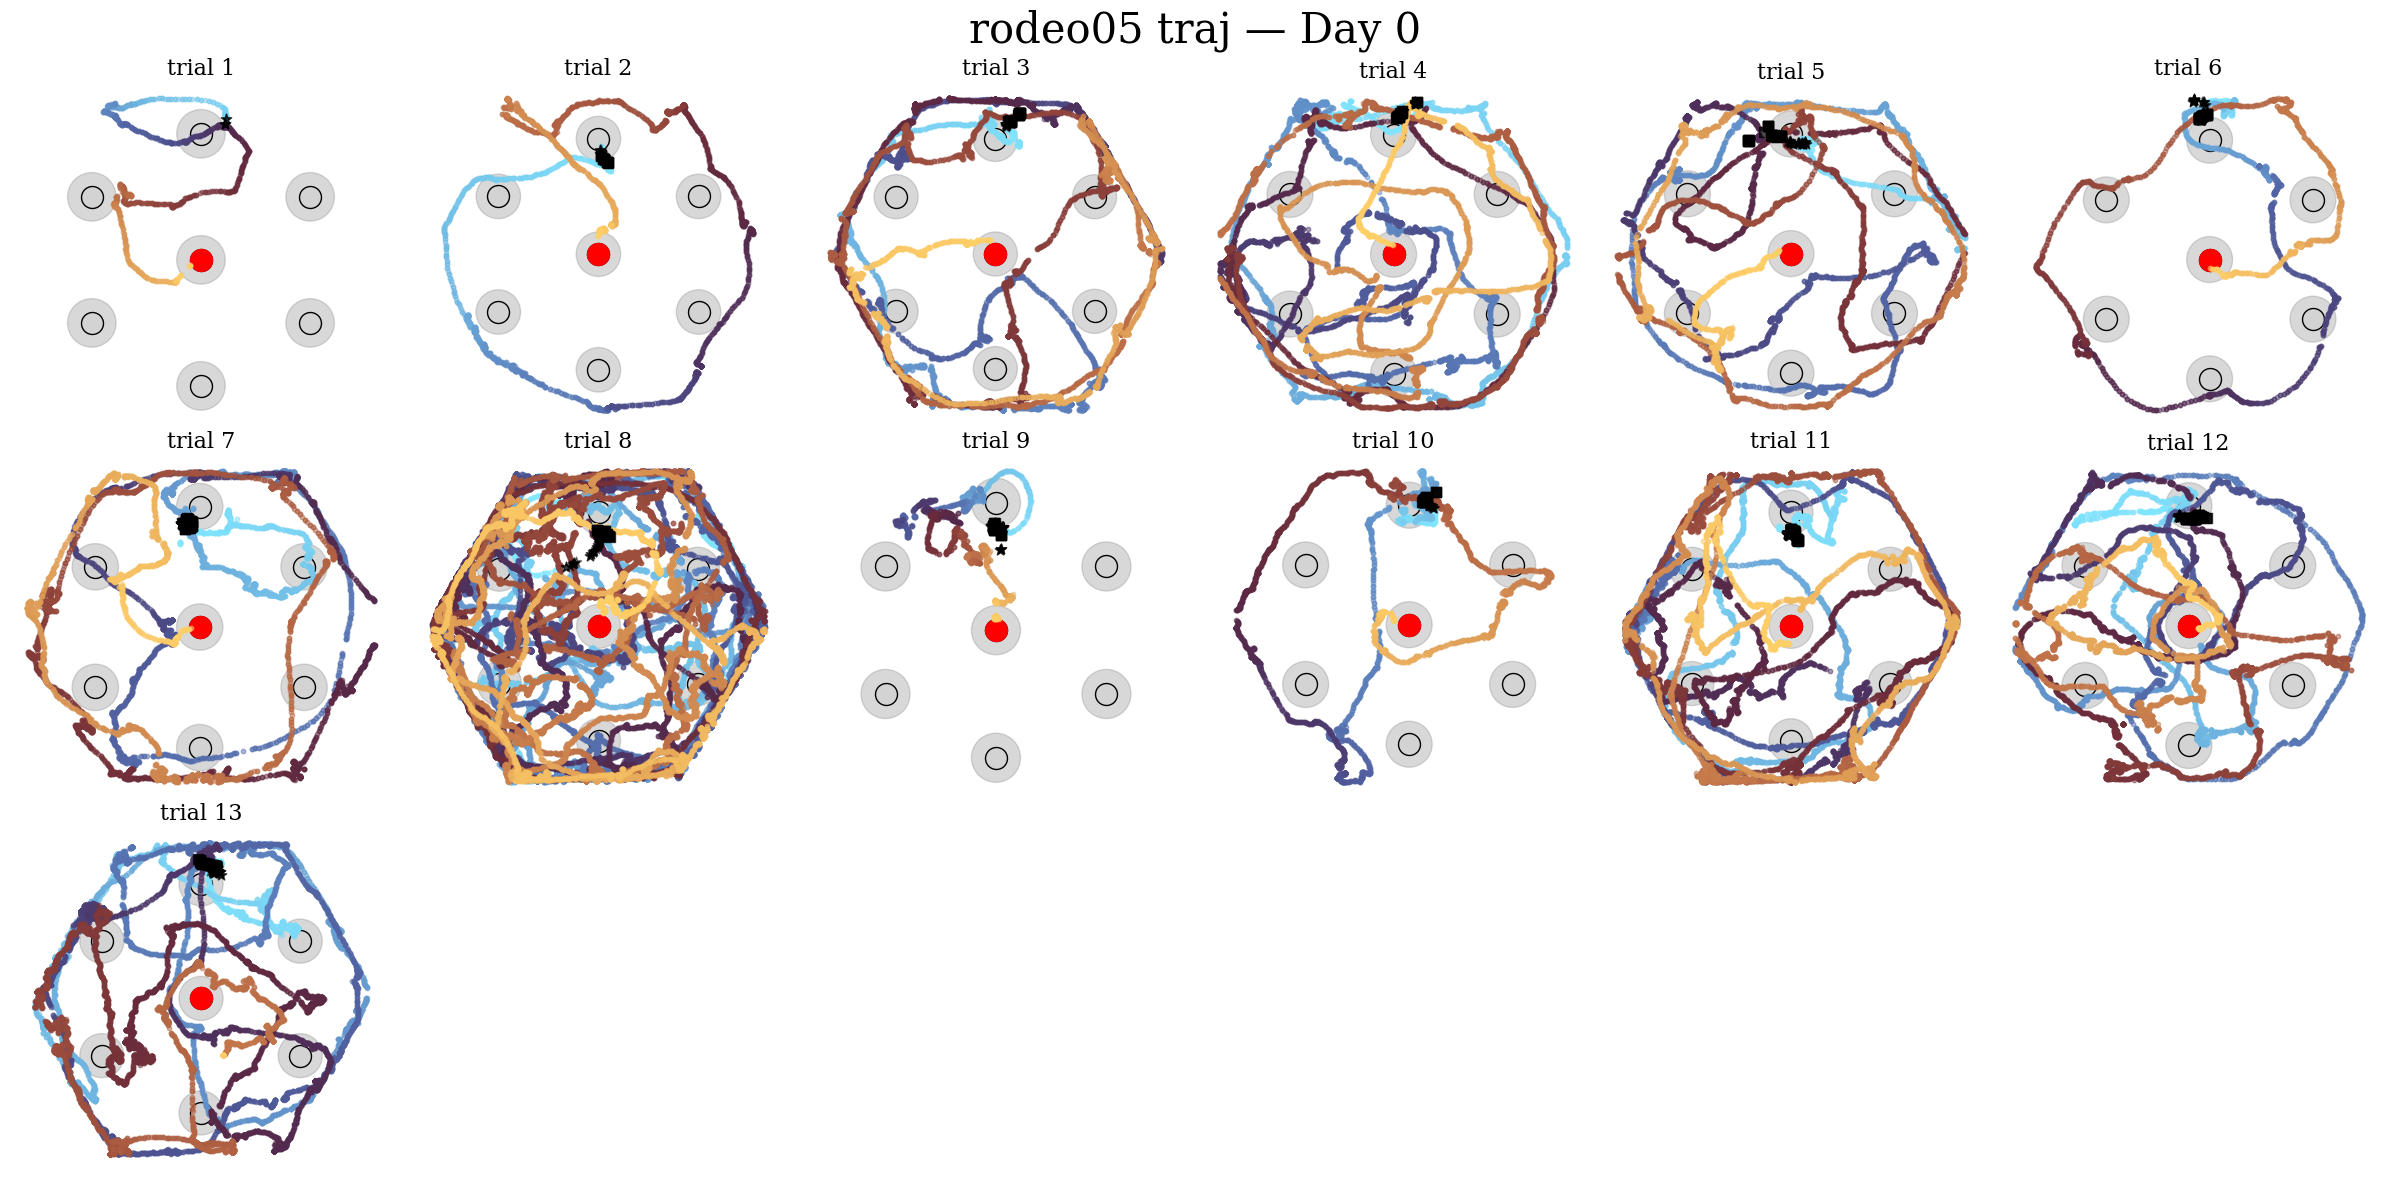

In [13]:
# ----- Config -----
jump_thresh = 0.5
ext_time_s = 1   
hex_round = (0.55/3)/np.sqrt(3)  # radius of hex
#hex_round = (0.55/2)/np.sqrt(3)

traj_cmap = plt.get_cmap("managua")  

#os.makedirs(f"{mouse_id}fig/traj", exist_ok=True)

last_day = df["day"].max()
for di, day in enumerate(days):
    if day != last_day:
        continue
    d = df[df["day"]==day].sort_index().copy()

    hex_centers = hex_centers_by_day[day]

    # timestamp & dt 
    t_dt = d.index.tz_convert("US/Eastern")
    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
    dt[0] = np.median(dt[1:])  
    median_dt = np.median(dt)
    speed_th = jump_thresh / median_dt 

    
    # traj clean: remove jumps
    xw = d["x"].to_numpy()
    yw = -d["y"].to_numpy()

    mask_edge = (d["x"].abs() > 0.8) | (d["y"].abs() > 0.75)

    dx = np.concatenate(([0], np.diff(xw)))
    dy = np.concatenate(([0], np.diff(yw)))
    speed = np.hypot(dx, dy) / dt
    jumps = speed > speed_th

    ext_frames = max(1, int(ext_time_s / median_dt))
    mask_jump = np.convolve(jumps.astype(int), np.ones(ext_frames, dtype=int), mode="same") > 0

    mask = mask_edge | mask_jump

    x_clean = xw.copy(); 
    x_clean[mask] = np.nan
    y_clean = yw.copy(); 
    y_clean[mask] = np.nan
    
    #x_clean = pd.Series(x_clean).interpolate().rolling(5,center=True).mean().to_numpy()
    #y_clean = pd.Series(y_clean).interpolate().rolling(5,center=True).mean().to_numpy()


    #x_clean = d['x'].to_numpy().copy()
    #y_clean = -d['y'].to_numpy().copy()  # y flip

    # trials: skip first three
    ends = np.where(d["sess_end"]==1)[0][1:]-1
    if len(ends) == 0:
        print(f"[Warning] No trials found for day {day}")
        continue
    starts = np.concatenate(([1], ends[:-1]+1))

    trial_idx = []
    color_lst = []
    ht_idx = []
    ht2_idx = []

    for sf, ef in zip(starts, ends):

        # which part of the trial to use

        '''
        idx_all = np.arange(sf-50, ef+1)
        last_trial = idx_all[:49]
        idx = idx_all[49:]
        mask_state = d["s"].isin(["foraging","reward"]).to_numpy()[idx]
        
        '''
        idx = np.arange(sf, ef+1)
        mask_state = d["s"].isin(["lightsOut"]).to_numpy()[idx]
        mask_state_ = np.where(d["s"].isin(["foraging","reward"]).to_numpy()[idx]==True)[0][-50:]
        if mask_state_.size == 0:
            continue  # Skip this trial if no foraging/reward state found
        last_trial = idx[mask_state_[:-1]]
        

        finite_mask = np.isfinite(x_clean[idx]) & np.isfinite(y_clean[idx])
        valid_mask = finite_mask & mask_state
        if not valid_mask.any():
            continue
        
        idx_in_prev = None
        if sf != 1:
            #mask_state2 = d["s"].isin(["lightsOut"]).to_numpy()[last_trial]
            mask_state2 = d["s"].isin(["foraging","reward"]).to_numpy()[last_trial]

            finite_mask2 = np.isfinite(x_clean[last_trial]) & np.isfinite(y_clean[last_trial])
            valid_mask2 = finite_mask2 & mask_state2
            if not valid_mask2.any():
                continue
            idx_in_prev = last_trial[valid_mask2]

        #idx_out = np.concatenate([idx[0:1], idx[valid_mask]])
        idx_out = np.concatenate([np.atleast_1d(idx[mask_state_[-1]]), idx[valid_mask]])
        LM_holding_time = d['lm_ht'][idx_out[-1]]/1000

        cumsum_dt = np.cumsum(dt[idx_out])
        # Make the first False after the last True also True in ht_mask
        ht_mask = cumsum_dt <= LM_holding_time  
        if np.any(ht_mask):
            last_true = np.where(ht_mask)[0].max() 
            if last_true + 1 < len(ht_mask):
                ht_mask[last_true + 1] = True
        else:
            # If no True, set the first one True
            ht_mask[0] = True
        idx_out_ht = idx_out[ht_mask]
        idx_out_other = idx_out[~ht_mask]

        if idx_in_prev is not None and idx_in_prev.any():
            cumsum_dt_rev = np.cumsum(dt[idx_in_prev][::-1])
            ht_mask_rev = cumsum_dt_rev <= LM_holding_time  
            if np.any(ht_mask_rev):
                last_true = np.where(ht_mask_rev)[0].max()
                if last_true + 1 < len(ht_mask_rev):
                    ht_mask_rev[last_true + 1] = True
            else:
                # If no True, set the first one True
                ht_mask_rev[0] = True
            idx_in_prev_ht = idx_in_prev[::-1][ht_mask_rev][::-1]  
        else:
            idx_in_prev_ht = []
        
        ht2_idx.append(idx_in_prev_ht)

        # M number of points in a trial (without ht)
        M = len(idx_out_other)
        if M == 0:
            continue
        colors = [traj_cmap(i/(M-1)) for i in range(M)] if M > 1 else [traj_cmap(0.5)]
        colors = list(reversed(colors))

        trial_idx.append(idx_out_other)
        color_lst.append(colors)
        ht_idx.append(idx_out_ht)

    # ----- Trajectory plot -----
    ncols = min(6, len(trial_idx)) 
    if ncols == 0:
        continue
    nrows = int(np.ceil(len(trial_idx) / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    fig.suptitle("{} traj — Day {}".format(mouse_id, day), fontsize=30)

    used_idxs = []  
    for ci in range(len(trial_idx)):
        colors = color_lst[ci]
        idx_this_trial_other = trial_idx[ci]
        idx_this_trial_ht = ht_idx[ci]
        ax = axes[ci]

        # all the hex centers
        for xc, yc in hex_centers:
            circle = Circle((xc, yc), radius=hex_round, color="gray", alpha=0.3, zorder=0)
            ax.add_patch(circle)

        ax.scatter(hex_centers[:,0], hex_centers[:,1],
                s=250, c="lightgray", edgecolor="k", label="Hex Centers")

        ax.scatter(0, 0,  # Maze center
                s=250, c="r", marker="o", label="Maze Center")

        for ti in range(len(idx_this_trial_other)):
            # Holding time scatters
            sel = idx_this_trial_other[ti]
            ax.scatter(x_clean[sel], y_clean[sel], s=10, color=colors[ti], alpha=0.5)

        if len(ht2_idx) > 0:
            idx_this_trial_prev_ht = ht2_idx[ci]
            if len(idx_this_trial_prev_ht) >= 1:
                for hti in range(len(idx_this_trial_prev_ht)):
                    sel_ht = idx_this_trial_prev_ht[hti]
                    ax.scatter(x_clean[sel_ht], y_clean[sel_ht], s=60, marker="s", color = "k", alpha = 0.7)

        if len(idx_this_trial_ht) >= 1:
            for hti in range(len(idx_this_trial_ht)):
                sel_ht = idx_this_trial_ht[hti]
                ax.scatter(x_clean[sel_ht], y_clean[sel_ht], s=60, marker="*", color = "k", alpha = 0.5)

        ax.set_title(f"trial {ci+1}", fontsize=16)
        ax.set_aspect("equal")
        ax.axis("off")

        used_idxs.append(ci)

        print(ci)

    # remove axes never used
    for i, ax in enumerate(axes):
        if i not in used_idxs:
            ax.remove()

    plt.tight_layout()
    plt.show()

    #fig.savefig(f"{mouse_id}fig/traj/perTrial_2LM_Inbound_day_{day}.png", dpi=300, bbox_inches="tight")
    #plt.close(fig)

## Try

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


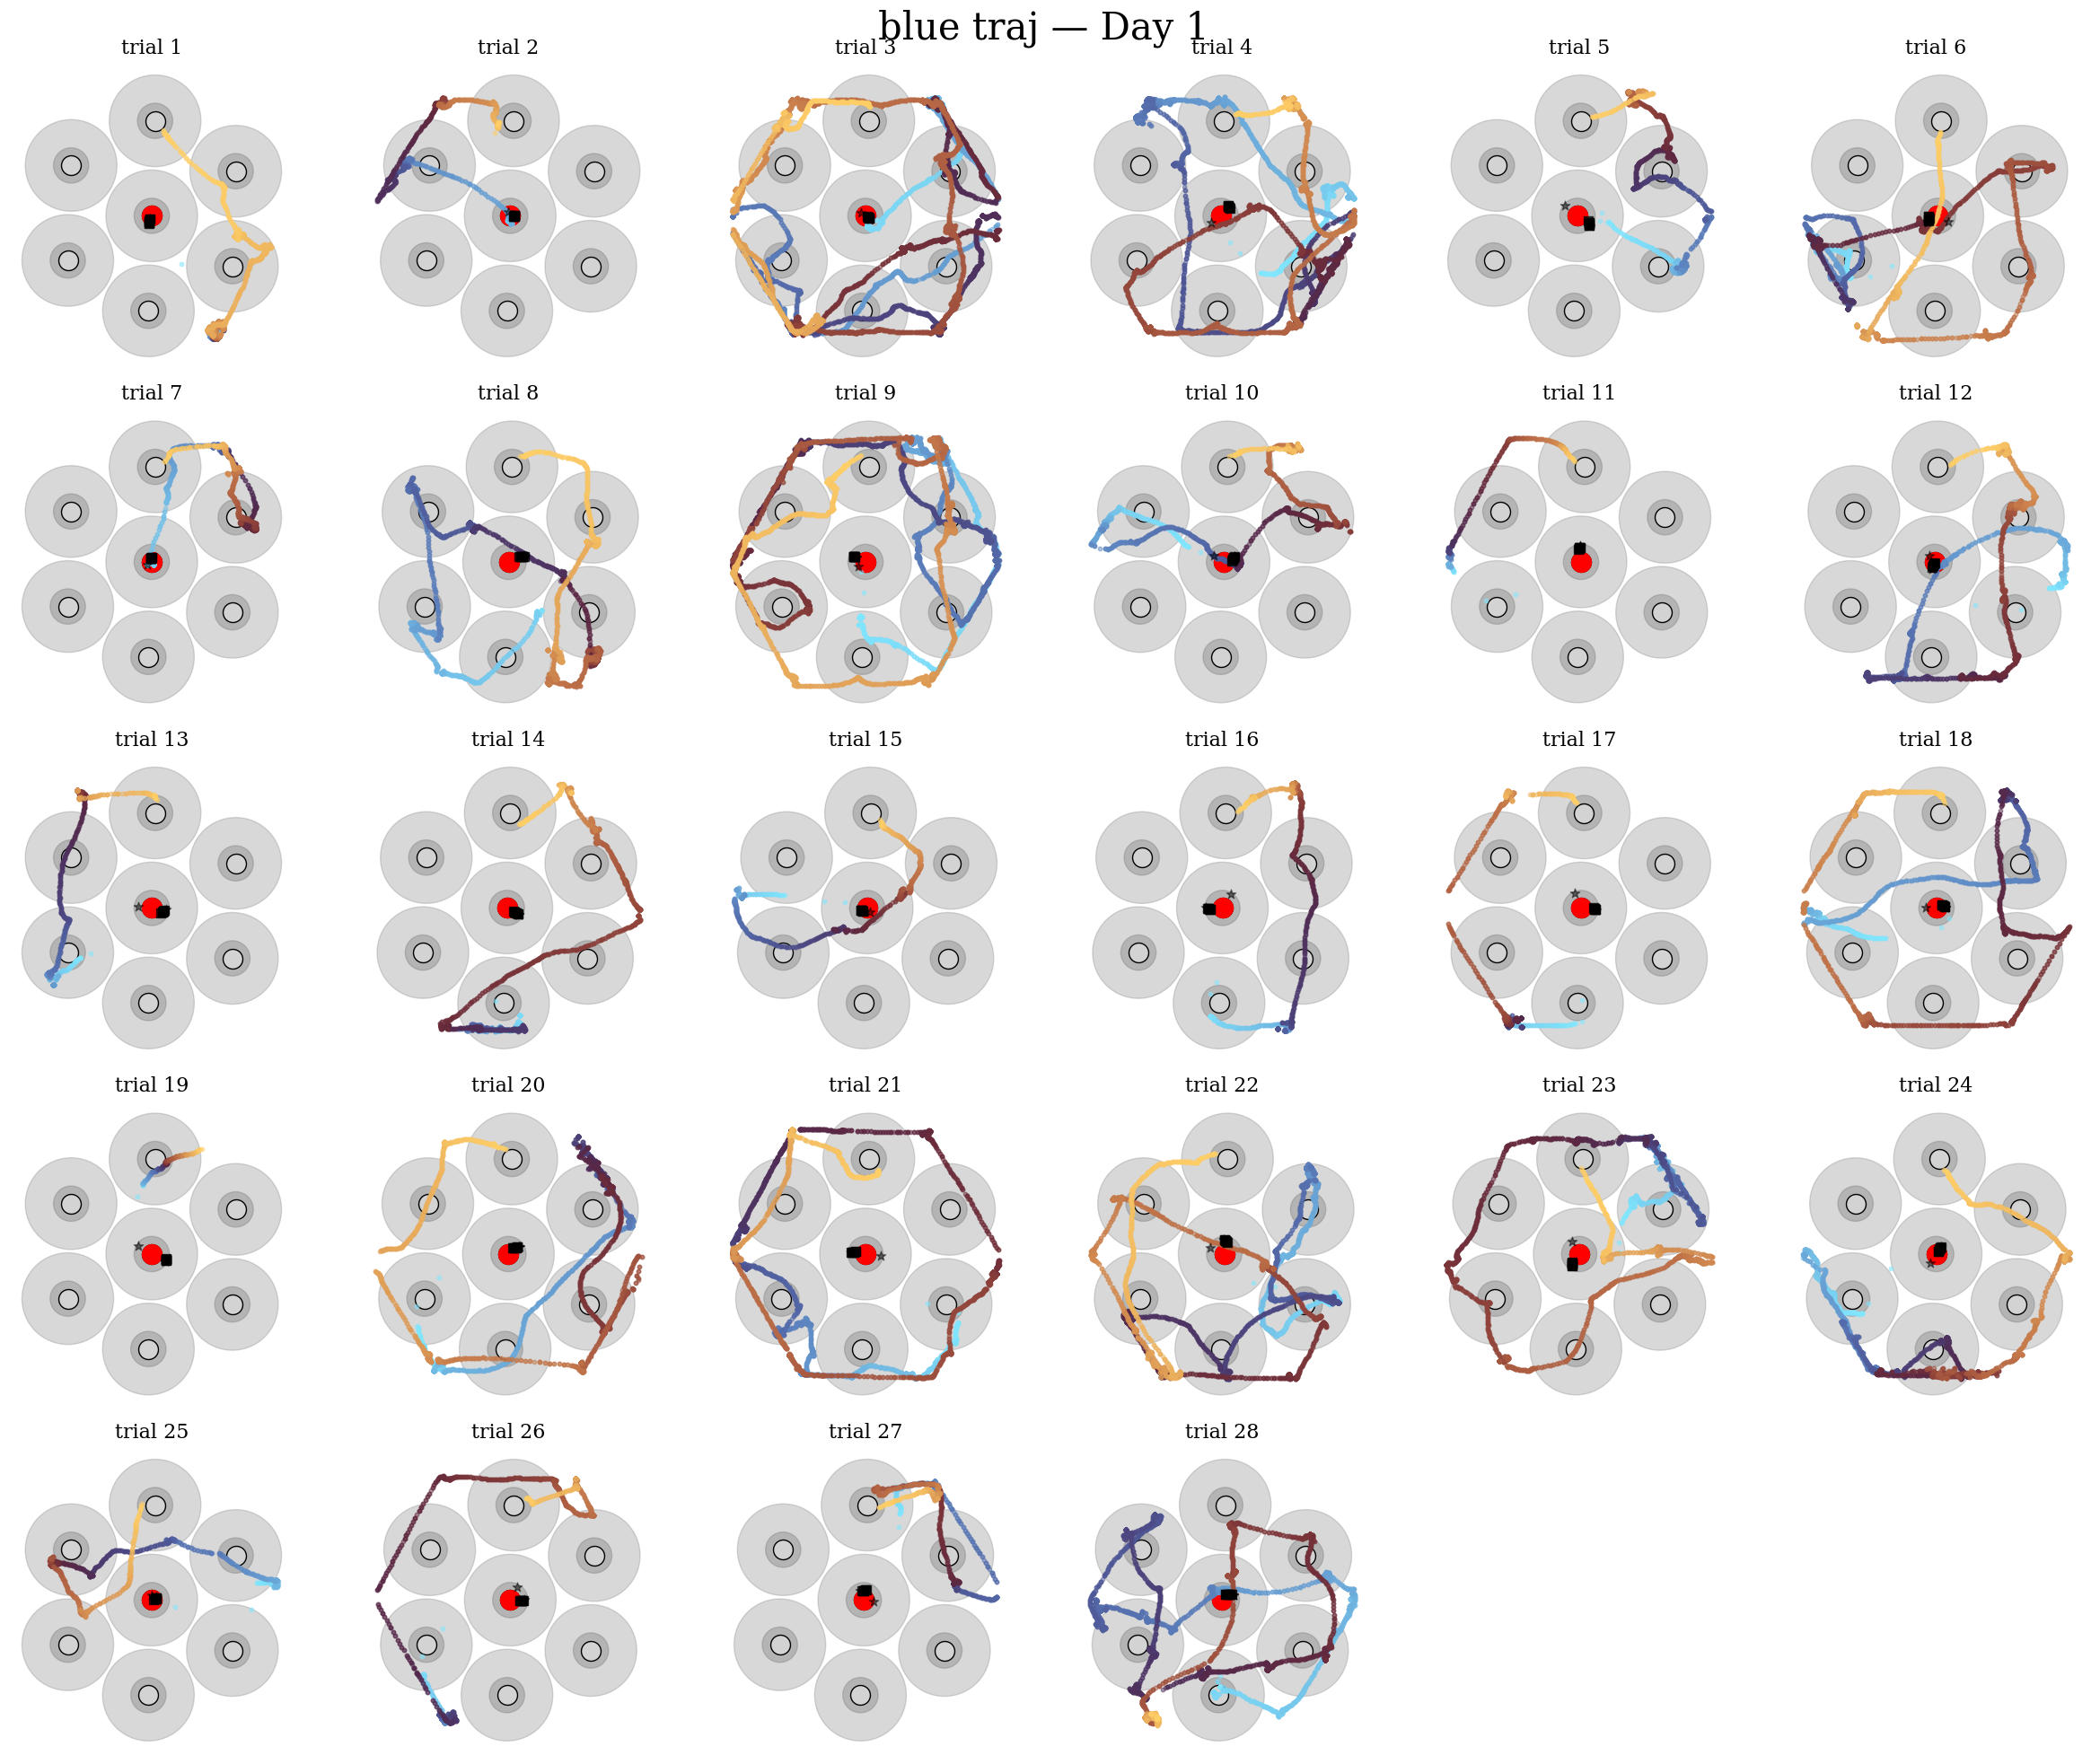

In [120]:
# ----- Config -----
jump_thresh = 0.5
ext_time_s = 1   
#hex_round = 0.275
hex_round = (0.55/3)/np.sqrt(3)

traj_cmap = plt.get_cmap("managua")  

os.makedirs(f"{mouse_id}fig/traj", exist_ok=True)


last_day = df["day"].max()
for day, day_df in df.groupby("day"):
    #if day != last_day:
    if day != 1:
        continue
    d = day_df.copy()
    d = d.sort_index()

    hex_centers = hex_centers_by_day[day]

    if day <= 6:
        center_holding_time = 0.1
    else:
        center_holding_time = center_holding_time_list[di] / 1000

    # timestamp & dt 
    t_dt = d.index.tz_convert("US/Eastern")
    dt = t_dt.to_series().diff().dt.total_seconds().to_numpy()
    dt[0] = np.median(dt[1:])  
    median_dt = np.median(dt)
    speed_th = jump_thresh / median_dt 

    
    # traj clean: remove jumps
    xw = d["x"].to_numpy()
    yw = -d["y"].to_numpy()

    mask_edge = (d["x"].abs() > 0.8) | (d["y"].abs() > 0.75)

    dx = np.concatenate(([0], np.diff(xw)))
    dy = np.concatenate(([0], np.diff(yw)))
    speed = np.hypot(dx, dy) / dt
    jumps = speed > speed_th

    ext_frames = max(1, int(ext_time_s / median_dt))
    mask_jump = np.convolve(jumps.astype(int), np.ones(ext_frames, dtype=int), mode="same") > 0

    mask = mask_edge | mask_jump

    x_clean = xw.copy(); 
    x_clean[mask] = np.nan
    y_clean = yw.copy(); 
    y_clean[mask] = np.nan
    
    #x_clean = pd.Series(x_clean).interpolate().rolling(5,center=True).mean().to_numpy()
    #y_clean = pd.Series(y_clean).interpolate().rolling(5,center=True).mean().to_numpy()


    #x_clean = d['x'].to_numpy().copy()
    #y_clean = -d['y'].to_numpy().copy()  # y flip

    # trials: skip first three
    ends = np.where(d["sess_end"]==1)[0][1:]-1
    if len(ends) == 0:
        print(f"[Warning] No trials found for day {day}")
        continue
    starts = np.concatenate(([1], ends[:-1]+1))

    trial_idx = []
    color_lst = []
    ht_idx = []
    ht2_idx = []

    for sf, ef in zip(starts, ends):

        # which part of the trial to use

        
        idx_all = np.arange(sf-50, ef+1)
        last_trial = idx_all[:49]
        idx = idx_all[49:]
        mask_state = d["s"].isin(["foraging","reward"]).to_numpy()[idx]
        
        '''
        idx = np.arange(sf, ef+1)
        mask_state = d["s"].isin(["lightsOut"]).to_numpy()[idx]
        mask_state_ = np.where(d["s"].isin(["foraging","reward"]).to_numpy()[idx]==True)[0][-50:]
        last_trial = idx[mask_state_[:-1]]
        '''

        finite_mask = np.isfinite(x_clean[idx]) & np.isfinite(y_clean[idx])
        valid_mask = finite_mask & mask_state
        if not valid_mask.any():
            continue
        
        idx_in_prev = None
        if sf != 1:
            mask_state2 = d["s"].isin(["lightsOut"]).to_numpy()[last_trial]
            #mask_state2 = d["s"].isin(["foraging","reward"]).to_numpy()[last_trial]

            finite_mask2 = np.isfinite(x_clean[last_trial]) & np.isfinite(y_clean[last_trial])
            valid_mask2 = finite_mask2 & mask_state2
            if not valid_mask2.any():
                continue
            idx_in_prev = last_trial[valid_mask2]

        idx_out = np.concatenate([idx[0:1], idx[valid_mask]])
        #idx_out = np.concatenate([np.atleast_1d(idx[mask_state_[-1]]), idx[valid_mask]])

        cumsum_dt = np.cumsum(dt[idx_out])
        # Make the first False after the last True also True in ht_mask
        ht_mask = cumsum_dt <= center_holding_time
        if np.any(ht_mask):
            last_true = np.where(ht_mask)[0].max() 
            if last_true + 1 < len(ht_mask):
                ht_mask[last_true + 1] = True
        else:
            # If no True, set the first one True
            ht_mask[0] = True
        idx_out_ht = idx_out[ht_mask]
        idx_out_other = idx_out[~ht_mask]

        if idx_in_prev is not None and idx_in_prev.any():
            cumsum_dt_rev = np.cumsum(dt[idx_in_prev][::-1])
            ht_mask_rev = cumsum_dt_rev <= center_holding_time
            if np.any(ht_mask_rev):
                last_true = np.where(ht_mask_rev)[0].max()
                if last_true + 1 < len(ht_mask_rev):
                    ht_mask_rev[last_true + 1] = True
            else:
                # If no True, set the first one True
                ht_mask_rev[0] = True
            idx_in_prev_ht = idx_in_prev[::-1][ht_mask_rev][::-1]  
        else:
            idx_in_prev_ht = []
        
        ht2_idx.append(idx_in_prev_ht)

        # M number of points in a trial (without ht)
        M = len(idx_out_other)
        if M == 0:
            continue
        colors = [traj_cmap(i/(M-1)) for i in range(M)] if M > 1 else [traj_cmap(0.5)]
        colors = list(reversed(colors))

        trial_idx.append(idx_out_other)
        color_lst.append(colors)
        ht_idx.append(idx_out_ht)

    # ----- Trajectory plot -----
    ncols = min(6, len(trial_idx)) 
    if ncols == 0:
        continue
    nrows = int(np.ceil(len(trial_idx) / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()
    fig.suptitle("{} traj — Day {}".format(mouse_id, day), fontsize=30)

    used_idxs = []  
    for ci in range(len(trial_idx)):
        colors = color_lst[ci]
        idx_this_trial_other = trial_idx[ci]
        idx_this_trial_ht = ht_idx[ci]
        ax = axes[ci]

        # all the hex centers
        for xc, yc in hex_centers:
            circle1 = Circle((xc, yc), radius=0.275, color="gray", alpha=0.3, zorder=0)
            ax.add_patch(circle1)
            circle2 = Circle((xc, yc), radius=hex_round, color="gray", alpha=0.4, zorder=0)
            ax.add_patch(circle2)

        ax.scatter(hex_centers[:,0], hex_centers[:,1],
                s=250, c="lightgray", edgecolor="k", label="Hex Centers")

        ax.scatter(0, 0,  # Maze center
                s=250, c="r", marker="o", label="Maze Center")

        for ti in range(len(idx_this_trial_other)):
            # Holding time scatters
            sel = idx_this_trial_other[ti]
            ax.scatter(x_clean[sel], y_clean[sel], s=10, color=colors[ti], alpha=0.5)

        if len(ht2_idx) > 0:
            idx_this_trial_prev_ht = ht2_idx[ci]
            if len(idx_this_trial_prev_ht) >= 1:
                for hti in range(len(idx_this_trial_prev_ht)):
                    sel_ht = idx_this_trial_prev_ht[hti]
                    ax.scatter(x_clean[sel_ht], y_clean[sel_ht], s=60, marker="s", color = "k", alpha = 0.7)

        if len(idx_this_trial_ht) >= 1:
            for hti in range(len(idx_this_trial_ht)):
                sel_ht = idx_this_trial_ht[hti]
                ax.scatter(x_clean[sel_ht], y_clean[sel_ht], s=60, marker="*", color = "k", alpha = 0.5)

        ax.set_title(f"trial {ci+1}", fontsize=16)
        ax.set_aspect("equal")
        ax.axis("off")

        used_idxs.append(ci)

        print(ci)

    # remove axes never used
    for i, ax in enumerate(axes):
        if i not in used_idxs:
            ax.remove()

    plt.tight_layout()
    plt.show()

    #fig.savefig(f"{mouse_id}fig/traj/perTrial_2LM_Outbound_day_{day}.png", dpi=300, bbox_inches="tight")
    #plt.close(fig)